<a href="https://colab.research.google.com/github/sznajder/FwdMuonTrigger/blob/master/FwdMuonMPGNNHitClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Neural Network for SEGMENT classification

### Based on:

https://github.com/jmduarte/gnn-fpga/blob/master/README.md

https://github.com/jmduarte/heptrkx-gnn-tracking/blob/master/README.md

https://github.com/jmduarte/gnn-fpga/blob/master/gnn/MPNN_HitClassifier.ipynb



In [1]:
# System imports
from __future__ import print_function
from __future__ import division
import os
import sys
import multiprocessing as mp
from timeit import default_timer as timer

# Externals
import math
import numpy as np
import pandas as pd
from collections import namedtuple
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, find
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import cKDTree
import sklearn.metrics
from sklearn.model_selection import train_test_split

# Torch imports
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from google.colab import drive

# Mount google drive on remote Colab machine
drive.mount('/content/gdrive', force_remount=False)
sys.path.append('gdrive/My Drive/Colab Notebooks')

!ls 'gdrive/My Drive/Colab Notebooks/Data'
data_dir = 'gdrive/My Drive/Colab Notebooks/Data'

# Input and Output files and events to read
infile = data_dir+'/graphs.npz'
events_start=0
events_end=100


# Local imports
#from estimator import Estimator
#from acts import process_hits_files, select_barrel_hits

#%matplotlib notebook
#%matplotlib ipympl
%matplotlib inline

# Training concurrency
import os
os.environ['OMP_NUM_THREADS'] = '4'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

cuda = False

if cuda:
    np_to_torch = lambda x, volatile=False: (
        Variable(torch.from_numpy(x.astype(np.float32)), volatile=volatile).cuda())
else:
    np_to_torch = lambda x, volatile=False: (
        Variable(torch.from_numpy(x.astype(np.float32)), volatile=volatile))

torch_to_np = lambda x: x.cpu().data.numpy()

# Graph is a namedtuple of (X, Ri, Ro, y) for convenience
feature_names = ['vh_sim_r', 'vh_sim_phi', 'vh_sim_z']
feature_scale = np.array([1000., 180. / 6., 1000.])
Graph = namedtuple('Graph', ['X', 'Ri', 'Ro', 'y'])

# Sparse graph uses the indices for the Ri, Ro matrices
SparseGraph = namedtuple('SparseGraph',['X', 'Ri_rows', 'Ri_cols', 'Ro_rows', 'Ro_cols', 'y'])

def graph_to_sparse(graph):
    Ri_rows, Ri_cols = graph.Ri.nonzero()
    Ro_rows, Ro_cols = graph.Ro.nonzero()
    return dict(X=graph.X, y=graph.y,
                Ri_rows=Ri_rows, Ri_cols=Ri_cols,
                Ro_rows=Ro_rows, Ro_cols=Ro_cols)

def sparse_to_graph(X, Ri_rows, Ri_cols, Ro_rows, Ro_cols, y, dtype=np.uint8):
    n_nodes, n_edges = X.shape[0], Ri_rows.shape[0]
    Ri = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ro = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ri[Ri_rows, Ri_cols] = 1
    Ro[Ro_rows, Ro_cols] = 1
    return Graph(X, Ri, Ro, y)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
_about.txt	   graphs		  ntuple_qqH_ZZ4mu.root
bolsas_astro.txt   jet_images.h5	  ntuple_SingleMuon_Endcap_9.root
bolsas_fisica.txt  model_best.pt	  ntuple_SingleNeutrino_PU200_63.root
events.root	   ntuple_bkg_ZZ4mu.root  VBFHZZ_background.csv
GOOG.csv	   ntuple_ggH_ZZ4mu.root  VBFHZZ_signal.csv


## PYTORCH module implementing a Message Passing GNN

https://github.com/jmduarte/gnn-fpga/blob/master/gnn/model.py

In [2]:
"""
This module implements the PyTorch modules that define the
message-passing graph neural networks for hit or segment classification.

"""

##############################################################

class EdgeNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, hidden_dim=8, hidden_activation=nn.Tanh):
        super(EdgeNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim*2, hidden_dim),
            hidden_activation(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid())
    def forward(self, X, Ri, Ro):
        # Select the features of the associated nodes
        bo = torch.bmm(Ro.transpose(1, 2), X)
        bi = torch.bmm(Ri.transpose(1, 2), X)
        B = torch.cat([bo, bi], dim=2)
        # Apply the network to each edge
        return self.network(B).squeeze(-1)

##############################################################

class NodeNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, output_dim, hidden_activation=nn.Tanh):
        super(NodeNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim*3, output_dim),
            hidden_activation(),
            nn.Linear(output_dim, output_dim),
            hidden_activation())
    def forward(self, X, e, Ri, Ro):
        bo = torch.bmm(Ro.transpose(1, 2), X)
        bi = torch.bmm(Ri.transpose(1, 2), X)
        Rwo = Ro * e[:,None]
        Rwi = Ri * e[:,None]
        mi = torch.bmm(Rwi, bo)
        mo = torch.bmm(Rwo, bi)
        M = torch.cat([mi, mo, X], dim=2)
        return self.network(M)

##############################################################

class NodeClassifier(nn.Module):
    """
    A message-passing graph neural network model which performs
    binary classification of nodes.
    """
    def __init__(self, input_dim=4, hidden_dim=8, n_iters=1, hidden_activation=nn.Tanh):
        super(NodeClassifier, self).__init__()
        self.n_iters = n_iters
        # Setup the input network
        self.input_network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            hidden_activation())
        # Setup the edge network
        self.edge_network = EdgeNetwork(input_dim+hidden_dim, hidden_dim, hidden_activation)
        # Setup the node layers
        self.node_network = NodeNetwork(input_dim+hidden_dim, hidden_dim, hidden_activation)
        # Setup the output network
        self.output_network = nn.Sequential(
            nn.Linear(input_dim+hidden_dim, 1),
            nn.Sigmoid())

    def forward(self, inputs):
        """Apply forward pass of the model"""
        X, Ri, Ro = inputs
        # Apply input network to get hidden representation
        H = self.input_network(X)
        # Shortcut connect the inputs onto the hidden representation
        H = torch.cat([H, X], dim=-1)
        # Loop over iterations of edge and node networks
        for i in range(self.n_iters):
            # Apply edge network
            e = self.edge_network(H, Ri, Ro)
            # Apply node network
            H = self.node_network(H, e, Ri, Ro)
            # Shortcut connect the inputs onto the hidden representation
            H = torch.cat([H, X], dim=-1)
        # Apply final output network
        return self.output_network(H).squeeze(-1)

##############################################################

class SegmentClassifier(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, input_dim=2, hidden_dim=8, n_iters=3, hidden_activation=nn.Tanh):
        super(SegmentClassifier, self).__init__()
        self.n_iters = n_iters
        # Setup the input network
        self.input_network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            hidden_activation())
        # Setup the edge network
        self.edge_network = EdgeNetwork(input_dim+hidden_dim, hidden_dim,
                                        hidden_activation)
        # Setup the node layers
        self.node_network = NodeNetwork(input_dim+hidden_dim, hidden_dim,
                                        hidden_activation)

    def forward(self, inputs):
        """Apply forward pass of the model"""
        X, Ri, Ro = inputs
        # Apply input network to get hidden representation
        H = self.input_network(X)
        # Shortcut connect the inputs onto the hidden representation
        H = torch.cat([H, X], dim=-1)
        # Loop over iterations of edge and node networks
        for i in range(self.n_iters):
            # Apply edge network
            e = self.edge_network(H, Ri, Ro)
            # Apply node network
            H = self.node_network(H, e, Ri, Ro)
            # Shortcut connect the inputs onto the hidden representation
            H = torch.cat([H, X], dim=-1)
        # Apply final edge network
        return self.edge_network(H, Ri, Ro)


################################################################################
'''
from torch_geometric.nn.conv import SAGEConv

class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = SAGEConv(in_channels = NN_input, out_channels = NN_input, flow = 'source_to_target',concat = True)
    self.lin1 = torch.nn.Linear(NN_input, int(3*NN_input))
    self.lin2 = torch.nn.Linear(int(3*NN_input), int(3*NN_input))
    self.lin3 = torch.nn.Linear(int(3*NN_input),1)
    self.act3 = torch.nn.Sigmoid()     
 
  
  
  def forward(self, data):
    x, edge_index = data['x'], data['edge_index']
    for aux_i in range(x.shape[0]):

      aux_x = torch.tensor([[]],dtype=torch.float32)

      aux_x = x[aux_i]   
      aux_x = self.conv1(aux_x,edge_index[aux_i])
      aux_x = self.lin1(aux_x)
      aux_x = self.lin2(aux_x)
      aux_x = self.lin3(aux_x)
      aux_x = self.act3(aux_x)
      print("see aux_X before")
      print(aux_x)
      aux_x = aux_x.squeeze()
      print(aux_x)
      input()
      if aux_i == 0:
        aux_out = aux_x
      else:
        aux_out = torch.cat([aux_out,aux_x],dim = -1)
      print("see aux_out")
      print(aux_out)
      input()

    return aux_x   
'''     

'\nfrom torch_geometric.nn.conv import SAGEConv\n\nclass Net(torch.nn.Module):\n  def __init__(self):\n    super(Net, self).__init__()\n    self.conv1 = SAGEConv(in_channels = NN_input, out_channels = NN_input, flow = \'source_to_target\',concat = True)\n    self.lin1 = torch.nn.Linear(NN_input, int(3*NN_input))\n    self.lin2 = torch.nn.Linear(int(3*NN_input), int(3*NN_input))\n    self.lin3 = torch.nn.Linear(int(3*NN_input),1)\n    self.act3 = torch.nn.Sigmoid()     \n \n  \n  \n  def forward(self, data):\n    x, edge_index = data[\'x\'], data[\'edge_index\']\n    for aux_i in range(x.shape[0]):\n\n      aux_x = torch.tensor([[]],dtype=torch.float32)\n\n      aux_x = x[aux_i]   \n      aux_x = self.conv1(aux_x,edge_index[aux_i])\n      aux_x = self.lin1(aux_x)\n      aux_x = self.lin2(aux_x)\n      aux_x = self.lin3(aux_x)\n      aux_x = self.act3(aux_x)\n      print("see aux_X before")\n      print(aux_x)\n      aux_x = aux_x.squeeze()\n      print(aux_x)\n      input()\n      if au

## PYTORCH module implementing the Estimator

https://github.com/jmduarte/gnn-fpga/blob/master/gnn/estimator.py

In [0]:
"""
This module contains the Estimator class implementation which provides
code for doing the training of a PyTorch model.
"""

from __future__ import print_function

from datetime import datetime
from timeit import default_timer as timer

import numpy as np

import shutil 
import os

import torch

def logger(s):
    """Simple logger function which prints date/time"""
    print(datetime.now(), s)

class Estimator():
    """Estimator class"""

    def __init__(self, model, loss_func, opt='Adam',
                 train_losses=None, valid_losses=None,
                 cuda=False, l1=0.):

        self.model = model
        if cuda:
            self.model.cuda()
        self.loss_func = loss_func
        if opt == 'Adam':
            self.optimizer = torch.optim.Adam(self.model.parameters())
        elif opt == 'SGD':
            self.optimizer = torch.optim.SGD(self.model.parameters())

        self.train_losses = train_losses if train_losses is not None else []
        self.valid_losses = valid_losses if valid_losses is not None else []
        self.l1 = l1

        logger('Model: \n%s' % model)
        logger('Parameters: %i' %
               sum(param.numel() for param in model.parameters()))

    def l1_penalty(self, arr):
        return torch.abs(arr).sum()
        
    def training_step(self, inputs, targets):
        """Applies single optimization step on batch"""
        self.model.zero_grad()
        self.optimizer.zero_grad()
        outputs = self.model(inputs)
        node_weights = [layer.weight for layer in self.model.node_network.network if hasattr(layer, 'weight')]
        edge_weights = [layer.weight for layer in self.model.edge_network.network if hasattr(layer, 'weight')]
        l1_regularization = self.l1 * sum([self.l1_penalty(arr) for arr in node_weights]) + self.l1 * sum([self.l1_penalty(arr) for arr in edge_weights])
        loss = self.loss_func(outputs, targets) + l1_regularization 
        loss.backward()
        self.optimizer.step()
        return loss

    def save_checkpoint(self, state, is_best, filename='checkpoint.pt'):
#        directory = os.path.dirname(filename)
        directory = data_dir
        try:
            os.stat(directory)
        except:
            os.mkdir(directory)
        torch.save(state, filename)
        if is_best:
            bestfilename = directory+'/model_best.pt'
            shutil.copyfile(filename, bestfilename)
            
    def load_checkpoint(self, filename='checkpoint.pt'):
        checkpoint = torch.load(filename)
        self.model.load_state_dict(checkpoint['state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.valid_losses = checkpoint['valid_losses']
        self.train_losses = checkpoint['train_losses']
    
    def fit_gen(self, train_generator, n_batches=1, n_epochs=1,
                valid_generator=None, n_valid_batches=1, verbose=0, 
                filename='checkpoint.pt'):
        """Runs batch training for a number of specified epochs."""
        epoch_start = len(self.train_losses)
        epoch_end = epoch_start + n_epochs
        if len(self.valid_losses) > 0:
            best_valid_loss = self.valid_losses[-1]
        else:
            best_valid_loss = 99999999
        for i in range(epoch_start, epoch_end):
            logger('Epoch %i' % i)
            start_time = timer()
            sum_loss = 0

            # Train the model
            self.model.train()
            
            for j in range(n_batches):
                batch_input, batch_target = next(train_generator)
                batch_loss = (self.training_step(batch_input, batch_target)
                              .cpu().data.item())
                sum_loss += batch_loss
                if verbose > 0:
                    logger('  Batch %i loss %f' % (j, batch_loss))
            end_time = timer()
            avg_loss = sum_loss / n_batches
            self.train_losses.append(avg_loss)
            logger('  training loss %.3g time %gs' %
                   (avg_loss, (end_time - start_time)))

            with torch.no_grad():
                # Evaluate the model on the validation set
                if (valid_generator is not None) and (n_valid_batches > 0):
                    self.model.eval()
                    valid_loss = 0
                    for j in range(n_valid_batches):
                        valid_input, valid_target = next(valid_generator)
                        valid_loss += (self.loss_func(self.model(valid_input), valid_target)
                                       .cpu().data.item())
                    valid_loss = valid_loss / n_valid_batches
                    self.valid_losses.append(valid_loss)
                    logger('  validate loss %.3g' % valid_loss)
                
                    #Save model checkpoint - modified
                    logger(' save checkpoint') 
                    is_best = valid_loss < best_valid_loss
                    best_valid_loss = min(valid_loss, best_valid_loss)
                    self.save_checkpoint({
                        'epoch': i + 1,
                        'state_dict': self.model.state_dict(),
                        'best_valid_loss': best_valid_loss,
                        'valid_losses': self.valid_losses,
                        'train_losses': self.train_losses,
                        'optimizer' : self.optimizer.state_dict(),
                    }, is_best, filename=filename)

    def predict(self, generator, n_batches, concat=True):
        with torch.no_grad():  
            self.model.eval()
            outputs = []
            for j in range(n_batches):
                test_input, test_target = next(generator)
                outputs.append(self.model(test_input))
            if concat:
                outputs = torch.cat(outputs)
            return outputs

    # DEPRECATED; MOVE TO BATCH GENERATOR VERSION
    def fit(self, train_input, train_target, batch_size=32, n_epochs=1,
            valid_input=None, valid_target=None):
        """Runs batch training for a number of specified epochs."""
        if type(train_input) == list:
            n_samples = train_input[0].size(0)
        else:
            n_samples = train_input.size(0)
        n_batches = (n_samples + batch_size - 1) // batch_size
        logger('Training samples: %i' % n_samples)
        logger('Batches per epoch: %i' % n_batches)
        if valid_input is not None:
            n_valid = (valid_input[0].size(0) if type(valid_input) == list
                       else valid_input.size(0))
            logger('Validation samples: %i' % n_valid)

        batch_idxs = np.arange(0, n_samples, batch_size)

        epoch_start = len(self.train_losses)
        epoch_end = epoch_start + n_epochs
        for i in range(epoch_start, epoch_end):
            logger('Epoch %i' % i)
            start_time = timer()
            sum_loss = 0

            self.model.train()
            for j in batch_idxs:
                # TODO: add support for more customized batching
                if type(train_input) is list:
                    batch_input = [ti[j:j+batch_size] for ti in train_input]
                else:
                    batch_input = train_input[j:j+batch_size]
                batch_target = train_target[j:j+batch_size]
                loss = self.training_step(batch_input, batch_target)
                sum_loss += loss.cpu().data.item()

            end_time = timer()
            avg_loss = sum_loss / n_batches
            self.train_losses.append(avg_loss)
            logger('  training loss %.3g time %gs' %
                   (avg_loss, (end_time - start_time)))

            # Evaluate the model on the validation set
            self.model.eval()
            if (valid_input is not None) and (valid_target is not None):
                valid_loss = (self.loss_func(self.model(valid_input), valid_target)
                              .cpu().data.item())
                self.valid_losses.append(valid_loss)
                logger('  validate loss %.3g' % valid_loss)



## Batch Generator

In [0]:
def batch_generator(X, Ri, Ro, y, n_samples=1, batch_size=1, train=True):
    volatile = not train
    batch_idxs = np.arange(0, n_samples, batch_size)
    # Loop over epochs
    while True:
        # Loop over batches
        for j in batch_idxs:
#            batch_X  = np_to_torch(  X[j:j+batch_size], volatile=volatile )
#            batch_Ri = np_to_torch( Ri[j:j+batch_size], volatile=volatile )
#            batch_Ro = np_to_torch( Ro[j:j+batch_size], volatile=volatile )
#            batch_y  = np_to_torch(  y[j:j+batch_size], volatile=volatile )
 
          with torch.set_grad_enabled(train):
            batch_X  = np_to_torch(  X[j:j+batch_size] )
            batch_Ri = np_to_torch( Ri[j:j+batch_size] )
            batch_Ro = np_to_torch( Ro[j:j+batch_size] )
            batch_y  = np_to_torch(  y[j:j+batch_size] )
            batch_inputs = [batch_X, batch_Ri, batch_Ro]
            yield batch_inputs, batch_y

## Network  Model and Training Configuration

In [0]:
# Model config
#hidden_dim = 64
hidden_dim = 16
#n_iters = 7
n_iters = 5

# Training config
batch_size = 10
n_epochs = 20
valid_frac = 0.2
test_frac = 0.2


## Load and prepare the graphs DATASET

In [6]:
# Load GRAPHS from inputfile
#sparse = np.load(infile, allow_pickle=True)
#gfile = np.load(infile)
#garray = gfile.f.arr_0 # convert file to 2D np.ndarrays
import glob
filenames =  glob.glob(data_dir+'/graphs/*.npz')

# Load the graphs into a list 
graphs = []
for f in filenames:
  gfile = np.load(f)
#  graph = SparseGraph(**dict(gfile.items()))
  graph = Graph(**dict(gfile.items()))
  graphs.append(graph)

# Get the matrix sizes in this batch
n_graphs = len(graphs)
n_features = graphs[0].X.shape[1] 
n_nodes    = np.array([g.X.shape[0] for g in graphs])
n_edges    = np.array([g.y.shape[0] for g in graphs])
max_nodes = n_nodes.max()
max_edges = n_edges.max()


print("n_graphs",n_graphs)
print("n_features",n_features)
print("n_nodes",n_nodes)
print("n_edges",n_edges)
print("max_nodes",max_nodes)
print("max_edges",max_edges)

# Define GRAPH tensors for the full dataset
n_samples = n_graphs
X  = np.zeros((n_samples, max_nodes, n_features), dtype=np.float32) # node features 
Ri = np.zeros((n_samples, max_nodes, max_edges) , dtype=np.float32)  # adjacency matrix
Ro = np.zeros((n_samples, max_nodes, max_edges) , dtype=np.float32)  #
y  = np.zeros((n_samples, max_edges), dtype=np.float32)             # target label

# Loop over graphs and fill the tensors ( with event # indexed  by i )
for i, g in enumerate(graphs):
  X[i,  :n_nodes[i]] = g.X 
  Ri[i, :n_nodes[i], :n_edges[i]] = g.Ri
  Ro[i, :n_nodes[i], :n_edges[i]] = g.Ro
  y[i,  :n_edges[i]] = g.y                 


n_graphs 1226
n_features 3
n_nodes [ 8  2  2 ...  5  2 13]
n_edges [ 7  1  1 ...  4  1 18]
max_nodes 24
max_edges 61


## Partition dataset into TRAIN , TEST and VALIDATION

In [7]:
%%time
# We round by batch_size to avoid partial batches
n_test  = int(n_samples * test_frac)     // batch_size * batch_size
n_valid = int(n_samples * valid_frac)    // batch_size * batch_size
n_train = (n_samples - n_valid - n_test) // batch_size * batch_size
n_train_batches = n_train // batch_size
n_valid_batches = n_valid // batch_size
n_test_batches  = n_test  // batch_size

# Partition the dataset into TEST, VALIDATION and TRAIN 
(train_X, test_X,  train_Ri, test_Ri,  train_Ro, test_Ro,  train_y, test_y)  = train_test_split(X, Ri, Ro, y, test_size=n_test)
(train_X, valid_X, train_Ri, valid_Ri, train_Ro, valid_Ro, train_y, valid_y) = train_test_split(X, Ri, Ro, y, test_size=n_valid)

# Prepare the batch samples
train_batcher = batch_generator(train_X, train_Ri, train_Ro, train_y, train=True , n_samples=n_train, batch_size=batch_size)
valid_batcher = batch_generator(valid_X, valid_Ri, valid_Ro, valid_y, train=False, n_samples=n_valid, batch_size=batch_size)
test_batcher  = batch_generator(test_X ,  test_Ri,  test_Ro, test_y , train=False, n_samples=n_test , batch_size=batch_size)

print('Graphs shapes:', X.shape , Ri.shape , Ro.shape , y.shape)
print('Graphs node features:', feature_names)
print("n_train, n_valid, n_test  = " , n_train, " , " , n_valid, " , " , n_test )
print('Train shapes:', train_X.shape , train_Ri.shape , train_Ro.shape , train_y.shape)
print('Valid shapes:', valid_X.shape , valid_Ri.shape , valid_Ro.shape , valid_y.shape)
print('Test shapes: ', test_X.shape  , test_Ri.shape  , test_Ro.shape  , test_y.shape)



Graphs shapes: (1226, 24, 3) (1226, 24, 61) (1226, 24, 61) (1226, 61)
Graphs node features: ['vh_sim_r', 'vh_sim_phi', 'vh_sim_z']
n_train, n_valid, n_test  =  740  ,  240  ,  240
Train shapes: (986, 24, 3) (986, 24, 61) (986, 24, 61) (986, 61)
Valid shapes: (240, 24, 3) (240, 24, 61) (240, 24, 61) (240, 61)
Test shapes:  (240, 24, 3) (240, 24, 61) (240, 24, 61) (240, 61)
CPU times: user 7.28 ms, sys: 11.4 ms, total: 18.6 ms
Wall time: 20.3 ms


## Construct the GNN model

In [8]:
# Construct the model
#model = EdgeClassifier(input_dim=n_features, hidden_dim=hidden_dim, n_iters=n_iters)
model = SegmentClassifier(input_dim=n_features, hidden_dim=hidden_dim, n_iters=n_iters) 
loss_func = nn.BCELoss()
estim = Estimator(model, loss_func=loss_func, cuda=cuda)

2020-05-22 10:56:51.531231 Model: 
SegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=16, bias=True)
    (1): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=38, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=1, bias=True)
      (3): Sigmoid()
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=57, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=16, bias=True)
      (3): Tanh()
    )
  )
)
2020-05-22 10:56:51.532057 Parameters: 1905


## Train the GNN

In [9]:
estim.fit_gen(train_batcher, n_batches=n_train_batches, n_epochs=n_epochs,valid_generator=valid_batcher, n_valid_batches=n_valid_batches)

2020-05-22 10:56:51.539200 Epoch 0
2020-05-22 10:56:52.272120   training loss 0.595 time 0.732463s
2020-05-22 10:56:52.353211   validate loss 0.52
2020-05-22 10:56:52.353367  save checkpoint
2020-05-22 10:56:52.360586 Epoch 1
2020-05-22 10:56:53.086481   training loss 0.438 time 0.725355s
2020-05-22 10:56:53.166622   validate loss 0.353
2020-05-22 10:56:53.166786  save checkpoint
2020-05-22 10:56:53.172840 Epoch 2
2020-05-22 10:56:53.887481   training loss 0.277 time 0.714445s
2020-05-22 10:56:53.968992   validate loss 0.21
2020-05-22 10:56:53.969476  save checkpoint
2020-05-22 10:56:53.975682 Epoch 3
2020-05-22 10:56:54.668447   training loss 0.166 time 0.691723s
2020-05-22 10:56:54.748219   validate loss 0.129
2020-05-22 10:56:54.748374  save checkpoint
2020-05-22 10:56:54.754294 Epoch 4
2020-05-22 10:56:55.461957   training loss 0.108 time 0.707181s
2020-05-22 10:56:55.542292   validate loss 0.0876
2020-05-22 10:56:55.542449  save checkpoint
2020-05-22 10:56:55.548458 Epoch 5
2020-0

## Evaluate Training


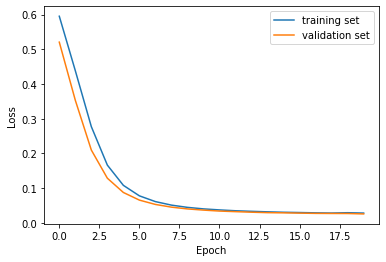

In [10]:
# Plot the loss
plt.figure()
plt.plot(estim.train_losses, label='training set')
plt.plot(estim.valid_losses, label='validation set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0);

## Evaluate Performance


AUC:  0.9913
Test set results with threshold of 0.4
Purity (Precision)= 0.5455
Signal Efficiency (Recall)=    0.4918
Accuracy=  0.9885


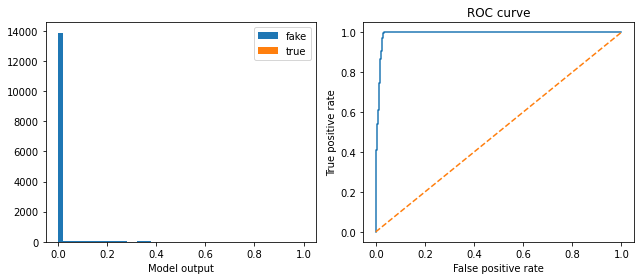

In [11]:
# Evaluate on TEST data
test_outputs = estim.predict(test_batcher, n_test_batches, concat=False)
test_pred = torch_to_np(estim.predict(test_batcher, n_test_batches))

flat_y = test_y.flatten()
flat_pred = test_pred.flatten()

# Compute the ROC curve
fpr, tpr, _ = sklearn.metrics.roc_curve(flat_y, flat_pred)
roc_auc = sklearn.metrics.auc(fpr, tpr)

thresh = 0.4

print('AUC:  %.4f' % roc_auc )
print('Test set results with threshold of', thresh)
print('Purity (Precision)= %.4f' % sklearn.metrics.precision_score(flat_y, flat_pred>thresh))
print('Signal Efficiency (Recall)=    %.4f' % sklearn.metrics.recall_score(flat_y, flat_pred>thresh))
print('Accuracy=  %.4f' % sklearn.metrics.accuracy_score(flat_y, flat_pred>thresh))


plt.figure(figsize=(9,4))

# Plot the model outputs
plt.subplot(121)
binning=dict(bins=50, range=(0,1), histtype='bar')
plt.hist(flat_pred[flat_y<thresh], label='fake', **binning)
plt.hist(flat_pred[flat_y>thresh], label='true', **binning)
plt.xlabel('Model output')
plt.legend(loc=0)

# Plot the ROC curve
plt.subplot(122)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.tight_layout()

## Visualize some samples

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00057666 0.00028075 0.00018676 0.00018692 0.00017724 0.00018784
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


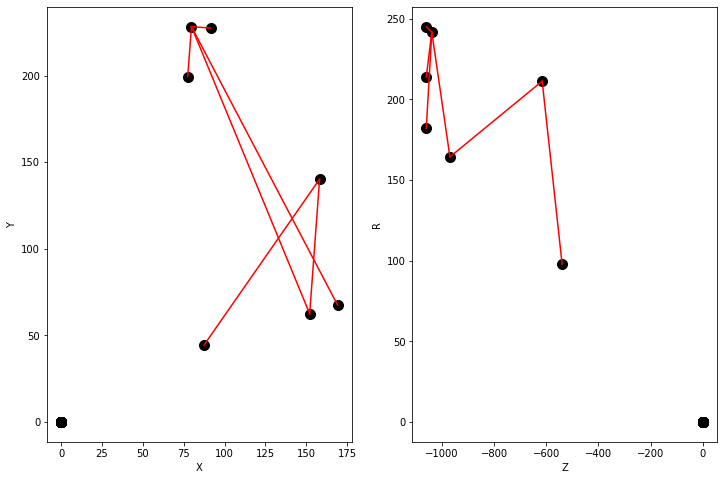

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00028587 0.00028462 0.00028326 0.00028657 0.00021305 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


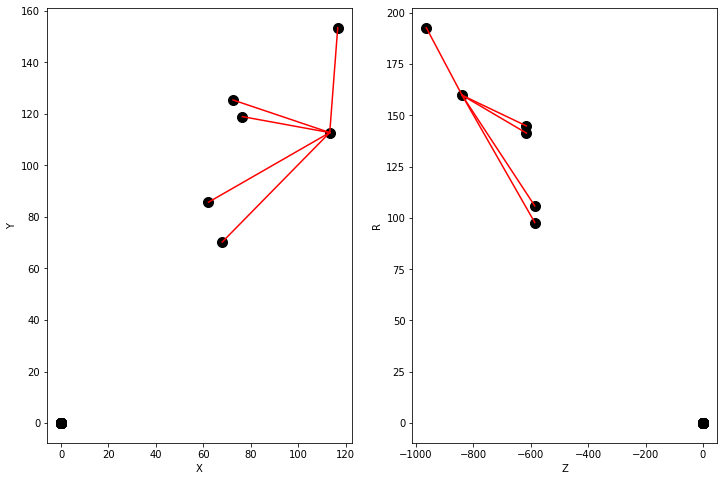

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.0004173  0.00041892 0.00042929 0.00043105 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


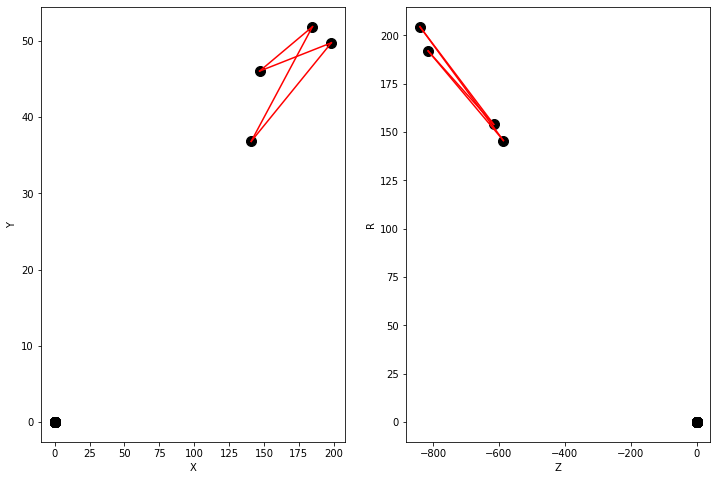

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00049233 0.00042109 0.00048227 0.00041299 0.00047848 0.00041023
 0.00029025 0.00028269 0.00022805 0.00021165 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


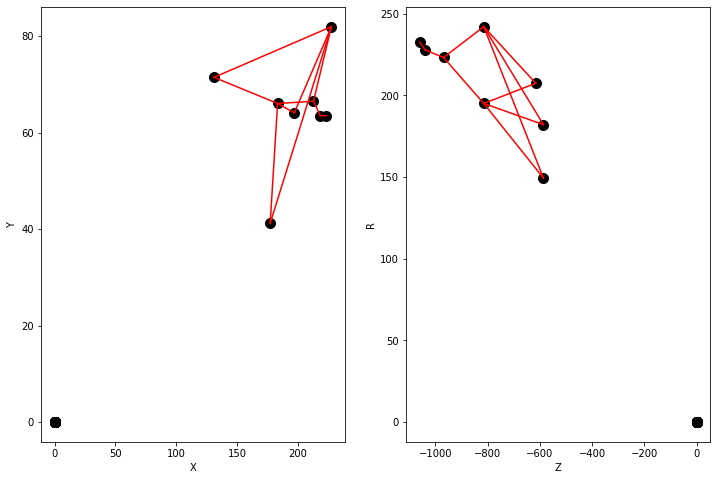

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.23837203 0.16170073 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


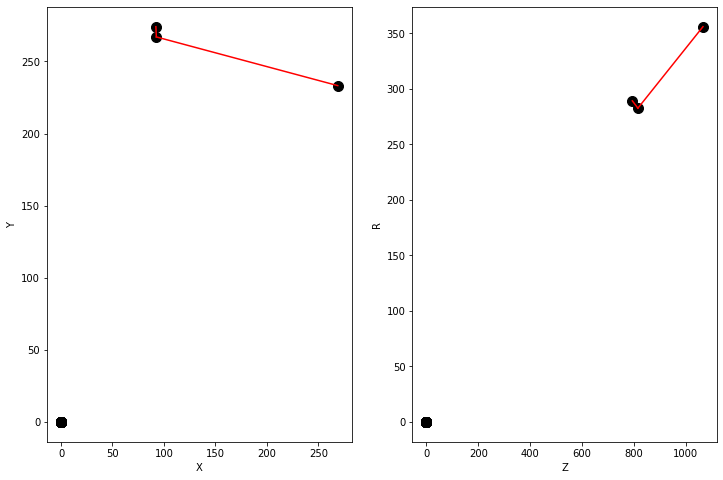

Y = [1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.19775811 0.19986194 0.20876977 0.2107452  0.36954844 0.3429758
 0.761466   0.64142025 0.36365587 0.41046923 0.30617115 0.37092367
 0.29301864 0.327635   0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.885, precision 0.667, recall 0.250


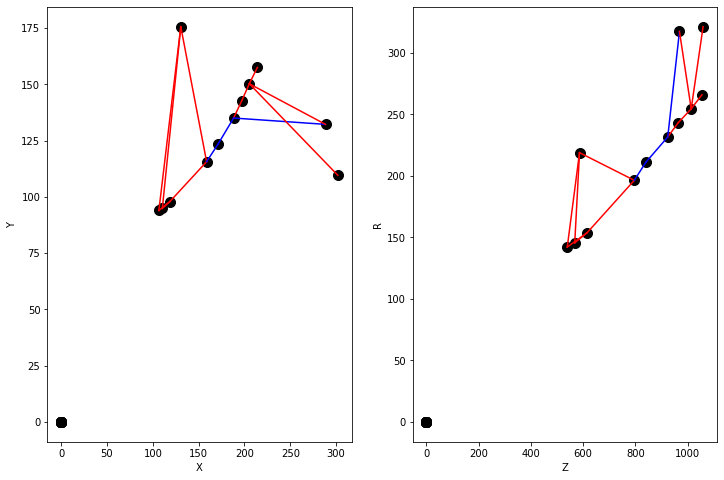

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00050638 0.00046046 0.00034349 0.00034873 0.00025828 0.00021505
 0.0001982  0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


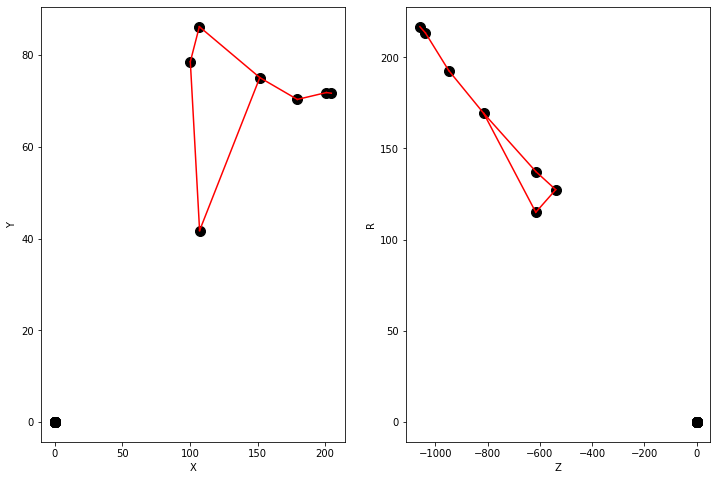

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.13802807 0.15199094 0.15214181 0.13299869 0.1465856  0.1467301
 0.11068074 0.12250375 0.12262139 0.10567495 0.11705888 0.11716896
 0.18337335 0.20030905 0.20051323 0.18713656 0.17456506 0.1728709
 0.64855564 0.34524187 0.34307986 0.17937012 0.18533082 0.17790596
 0.18382803 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.984, precision 0.000, recall 0.000


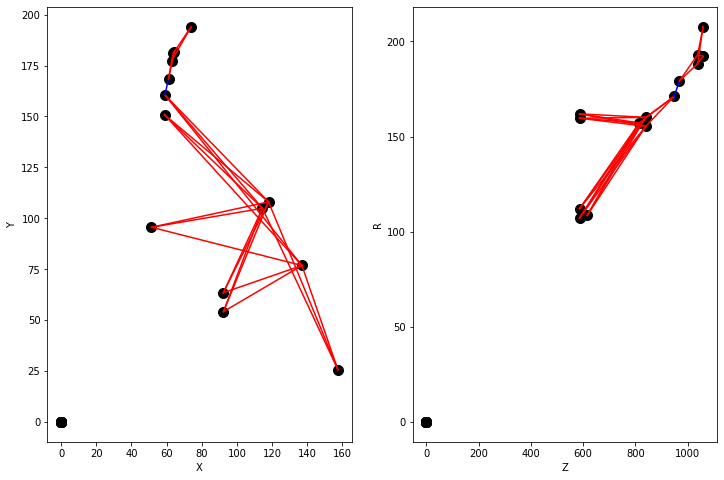

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00045648 0.0007133  0.00025245 0.00023577 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


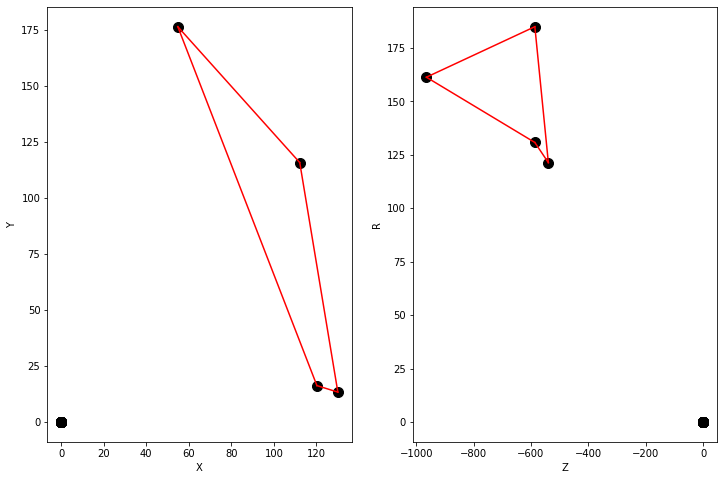

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.12553707 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


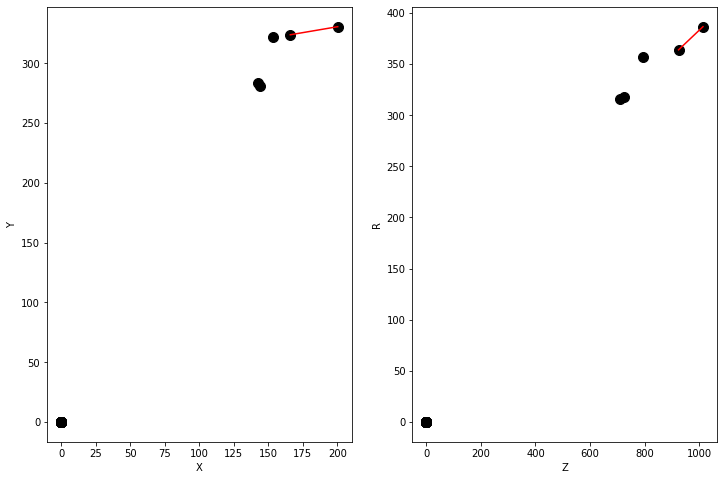

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.07419834 0.07436296 0.07309417 0.07325583 0.10474705 0.10759481
 0.10523359 0.10809256 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


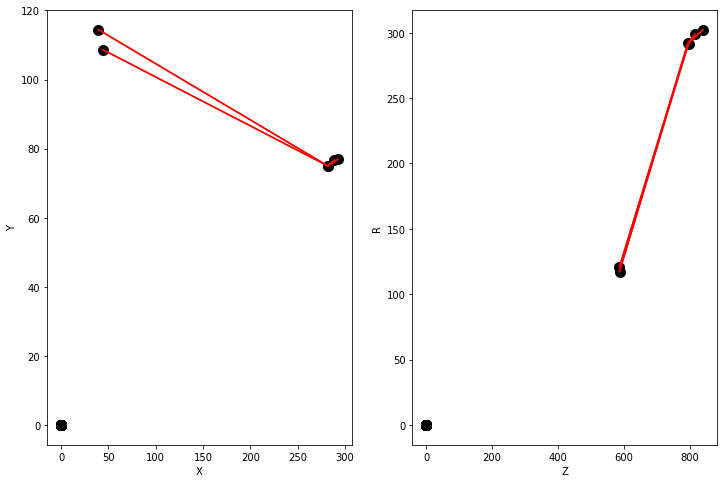

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00024734 0.00024587 0.00035596 0.00017639 0.00017675 0.00017295
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


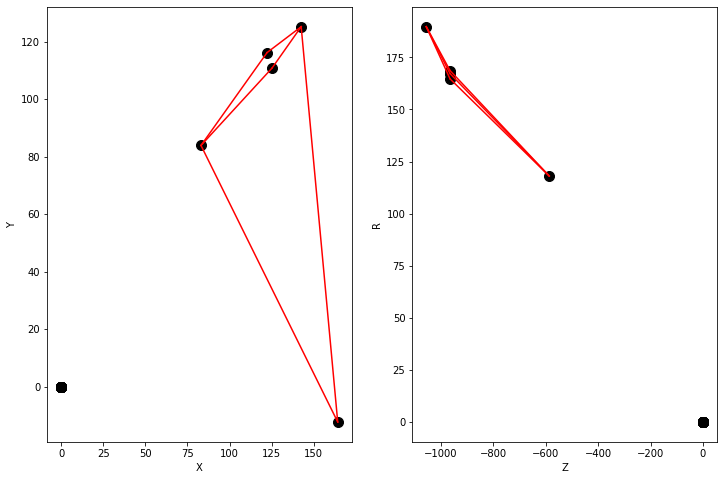

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00036176 0.00035148 0.00026816 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


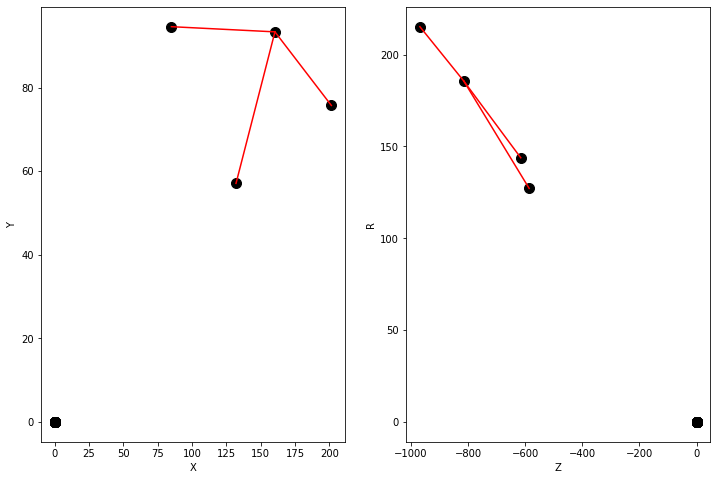

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.34472078 0.40600857 0.4150854  0.45278957 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.951, precision 0.000, recall 0.000


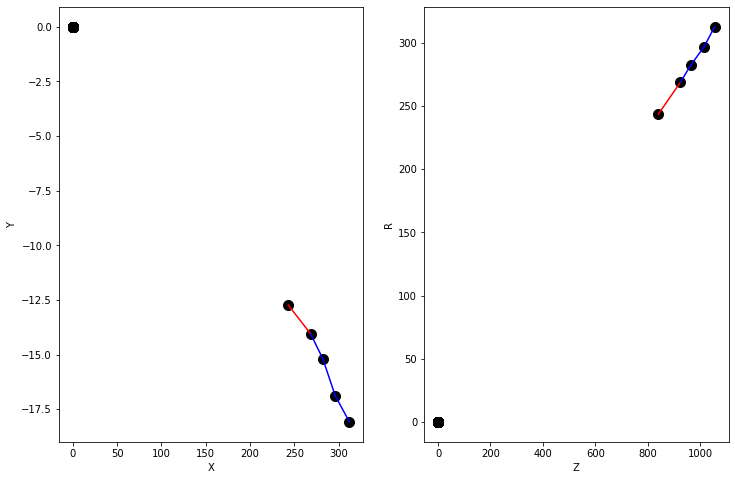

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00067527 0.00053052 0.0004322  0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


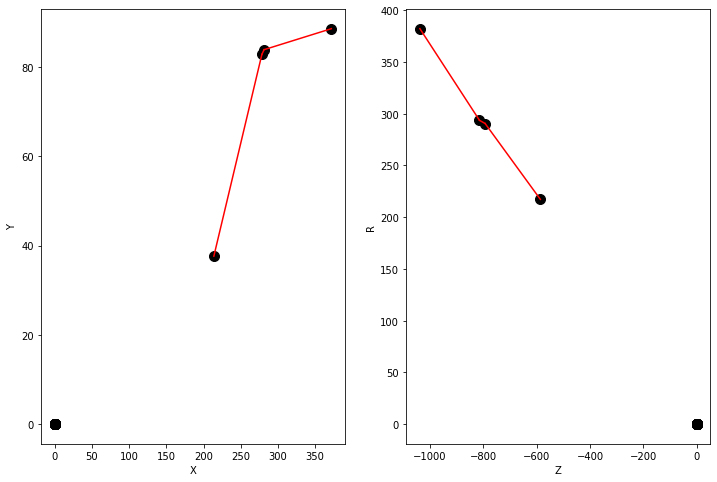

Y = [1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.24617702 0.21298897 0.2949381  0.24369195 0.58092296 0.5628014
 0.25507224 0.2747758  0.25423887 0.21949589 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.934, precision 1.000, recall 0.333


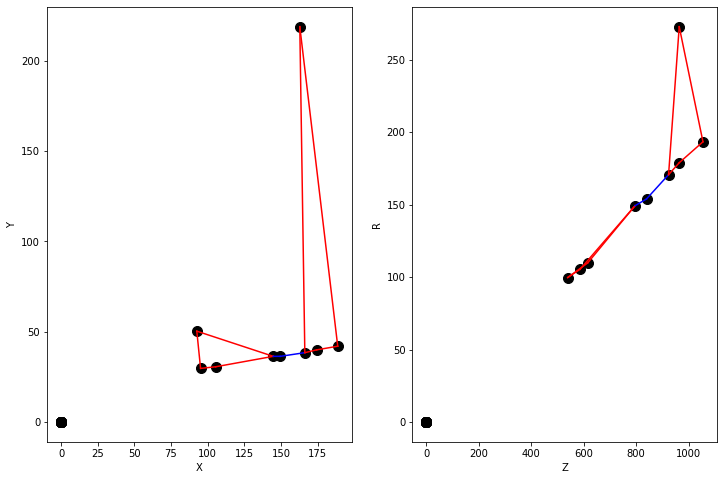

Y = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.16621211 0.15702939 0.17418951 0.16465966 0.3252096  0.30204907
 0.6714434  0.63796234 0.5338342  0.46390876 0.4165839  0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.902, precision 1.000, recall 0.455


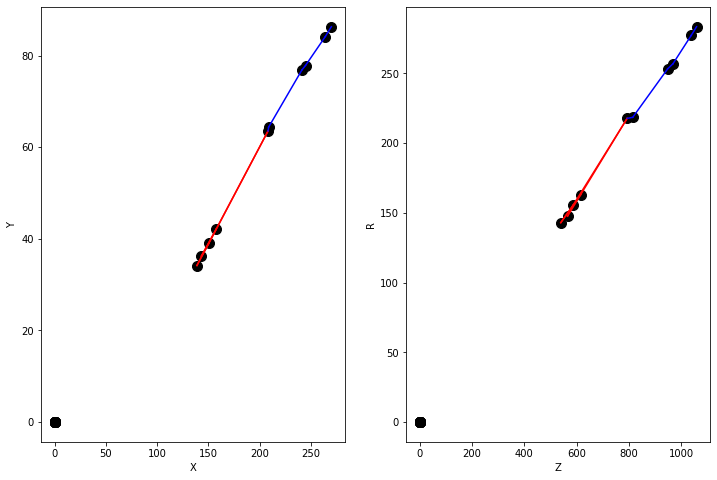

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00028461 0.00021693 0.00019726 0.00018384 0.0001748  0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


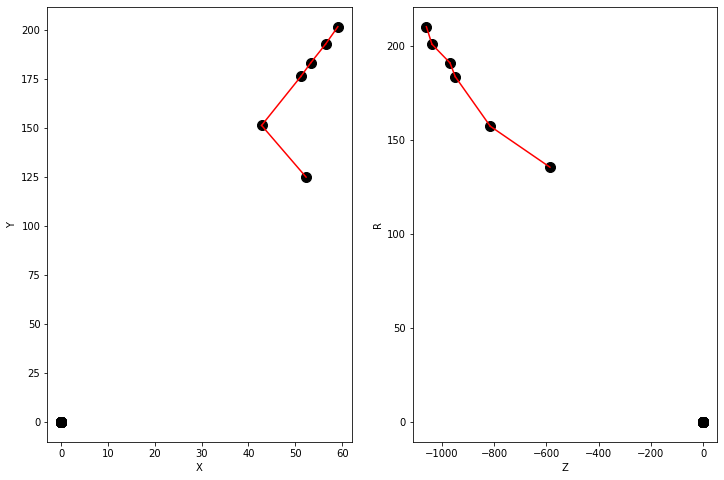

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00042938 0.00032889 0.00041381 0.00031646 0.00040885 0.00031408
 0.00025242 0.00024288 0.00022239 0.00020643 0.00019603 0.00016785
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


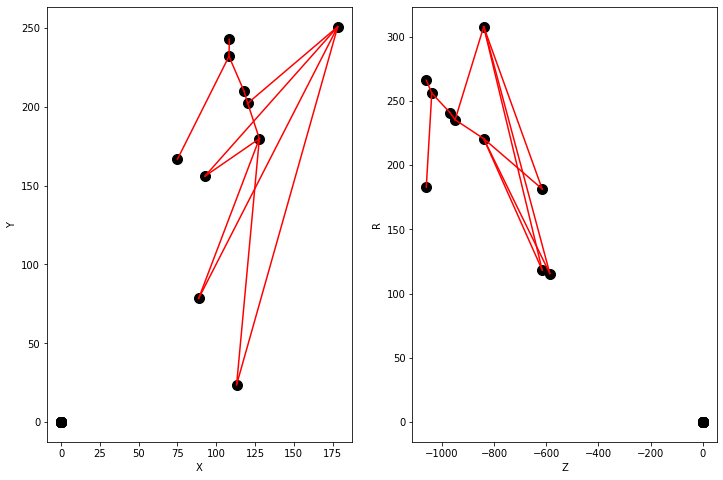

Y = [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.4633497  0.4657083  0.39157975 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.984, precision 1.000, recall 0.667


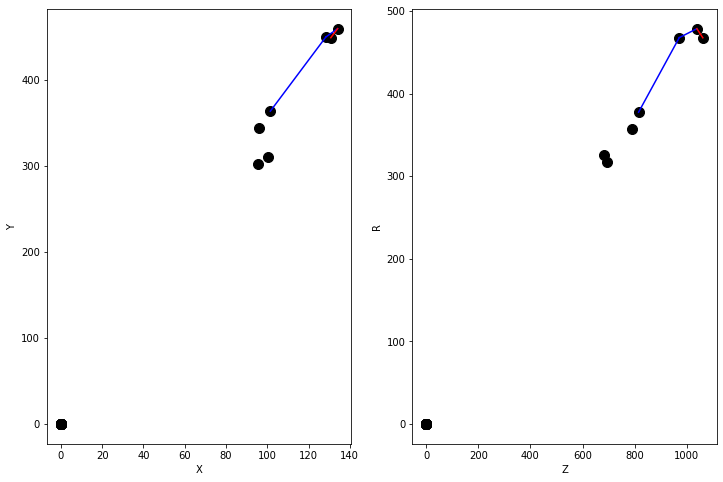

Y = [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.46640778 0.47134897 0.39571568 0.34457868 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.984, precision 1.000, recall 0.667


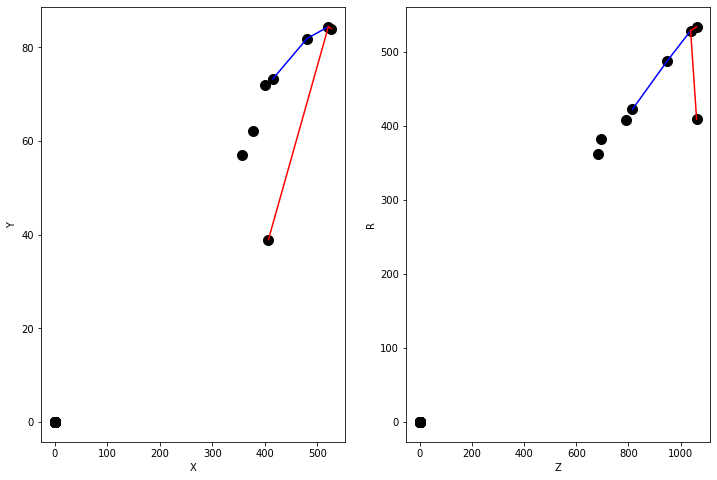

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00062243 0.00060966 0.00052505 0.00045817 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


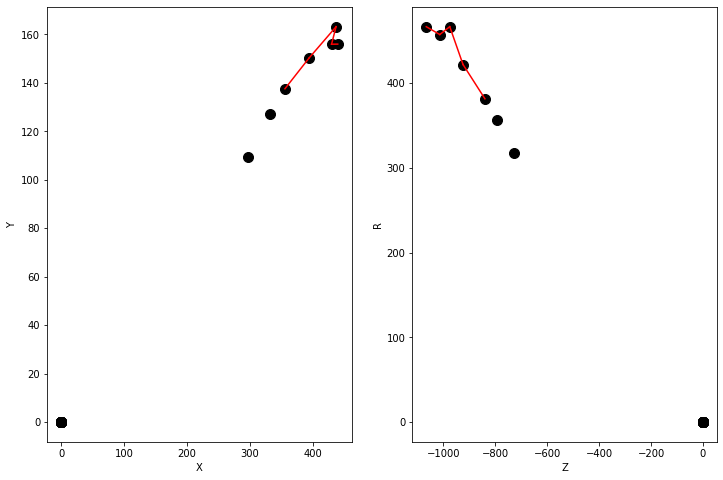

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.25484017 0.21708812 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


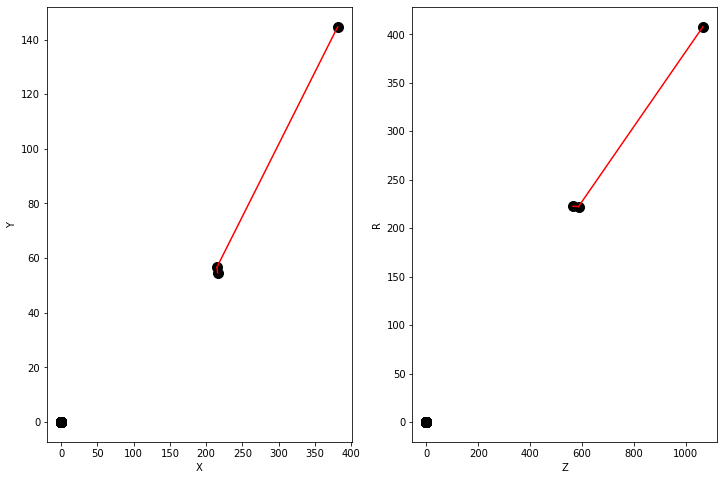

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.20095216 0.15331091 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


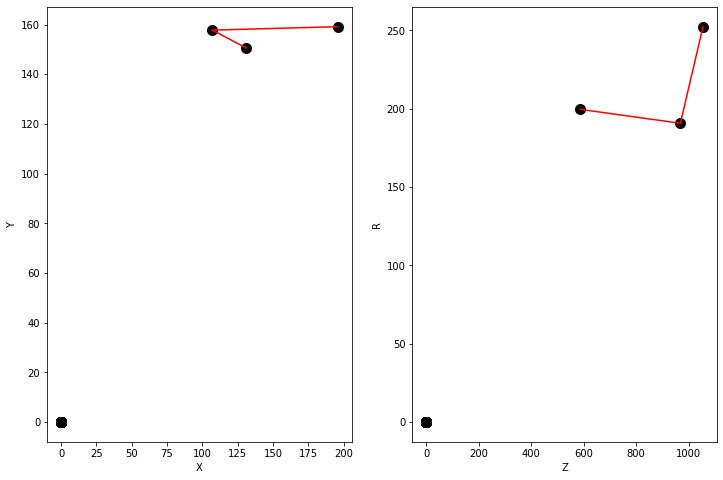

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00045952 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


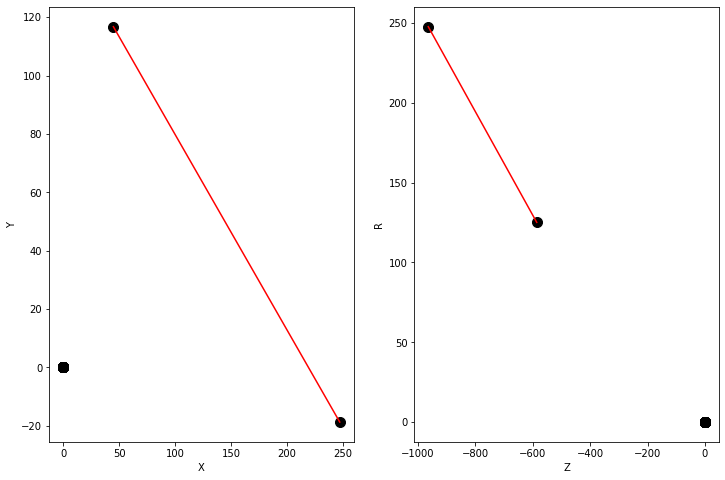

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.10419706 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


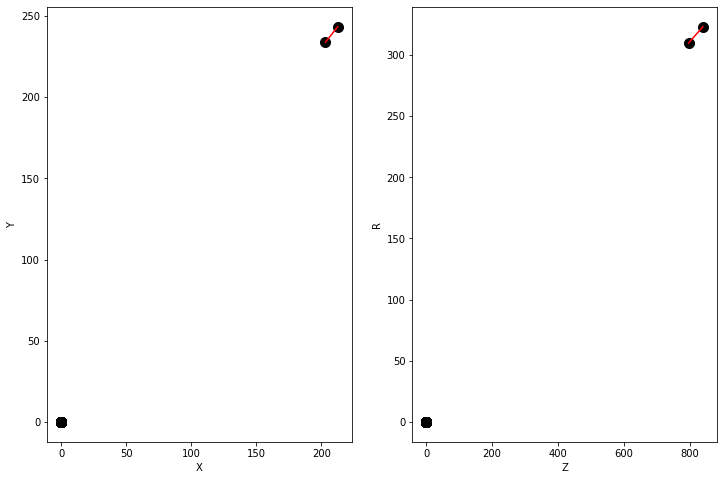

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00024162 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


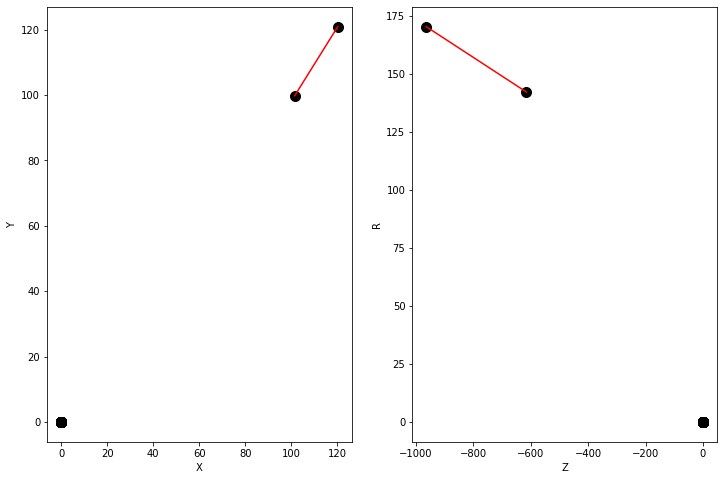

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00066749 0.00035901 0.00044433 0.00043116 0.00046209 0.00025832
 0.00025045 0.00024561 0.00024833 0.00025524 0.00019534 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


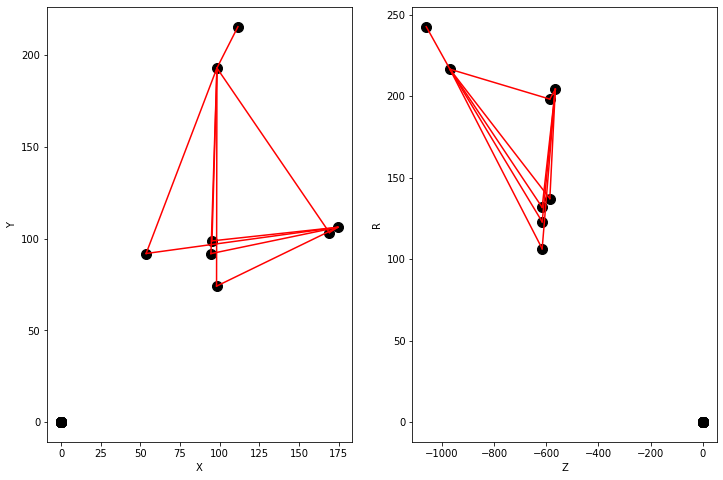

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.18949609 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


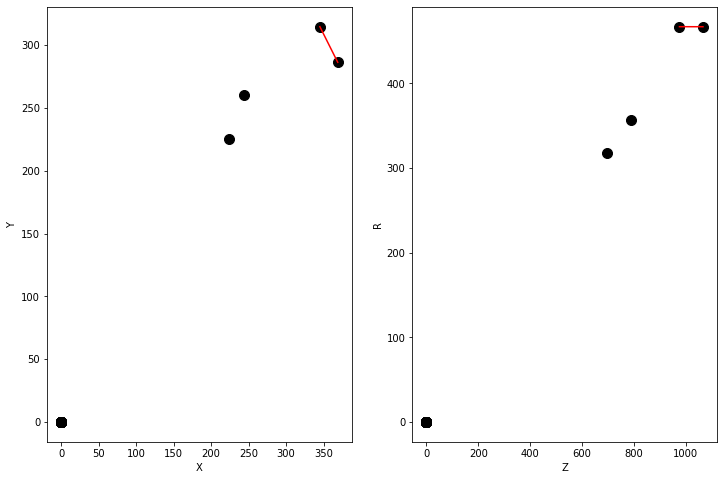

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00058577 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


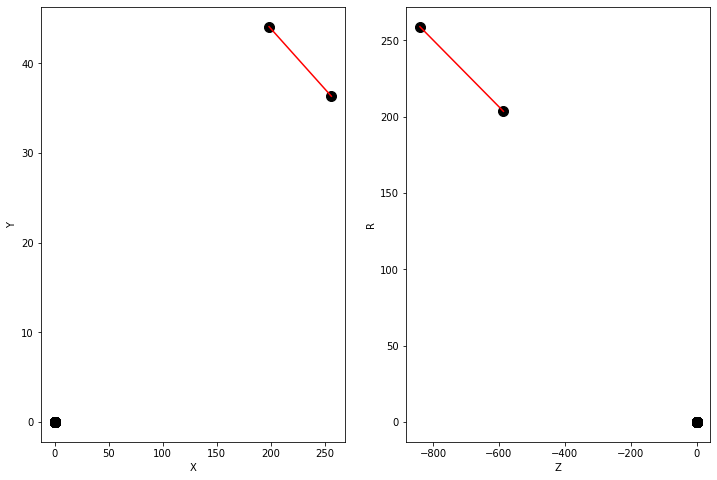

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00040787 0.00040875 0.00029702 0.00026488 0.00023977 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


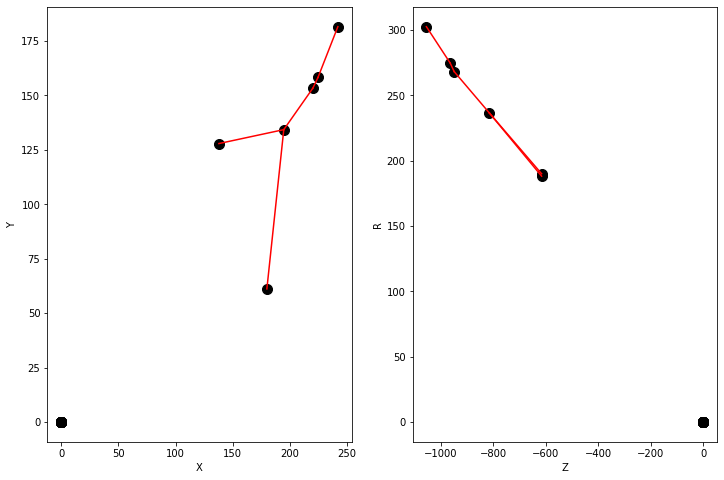

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00029566 0.000218   0.0001942  0.00018617 0.00017879 0.00017941
 0.00017145 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


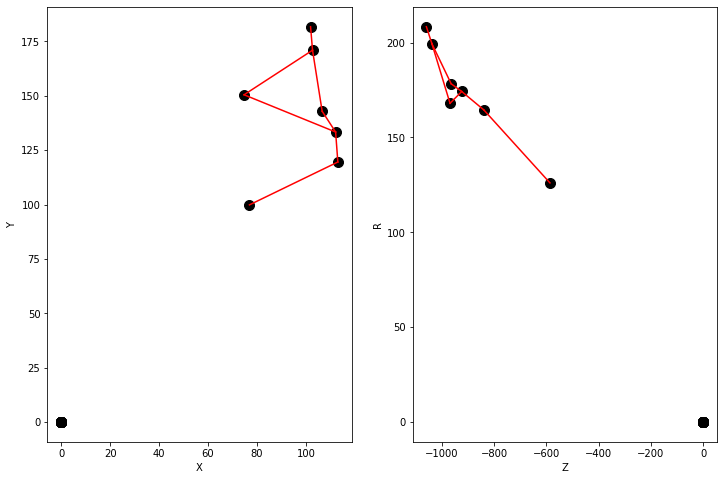

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00048787 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


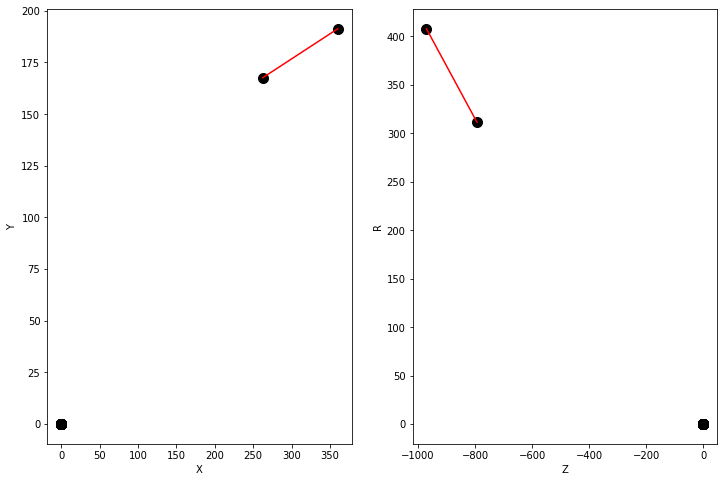

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.08238077 0.06725428 0.06049236 0.05047198 0.08049531 0.06538901
 0.20026723 0.12750193 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


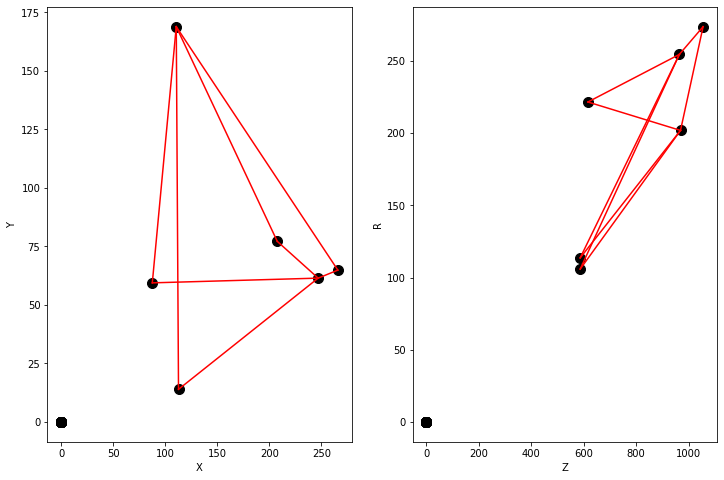

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.18243611 0.16122143 0.12368973 0.49434584 0.48805267 0.44447163
 0.37511283 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.951, precision 0.000, recall 0.000


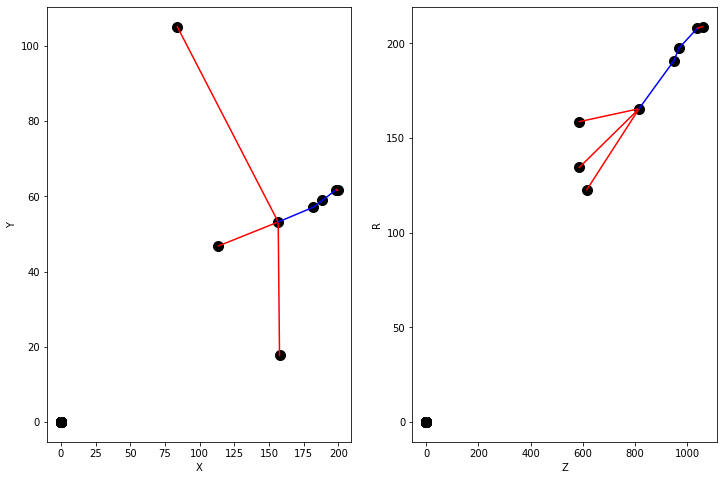

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.4071177  0.53778875 0.23019587 0.2719784  0.24997252 0.1531224
 0.26542267 0.22632374 0.47714287 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.951, precision 0.000, recall 0.000


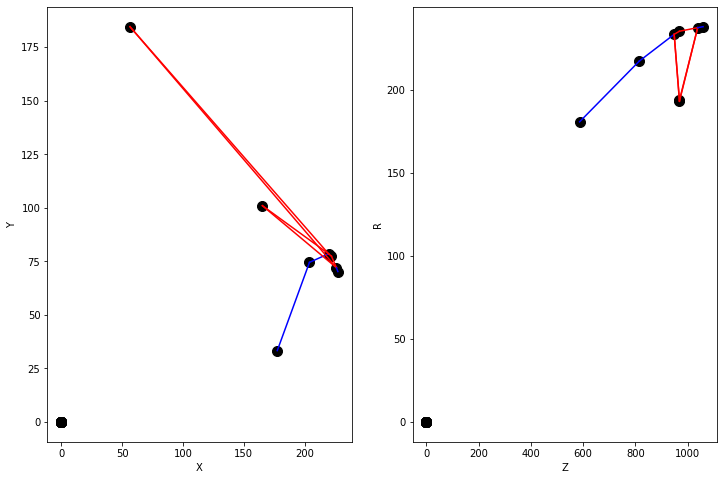

Y = [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.22919834 0.17739508 0.17652187 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.967, precision 0.000, recall 0.000


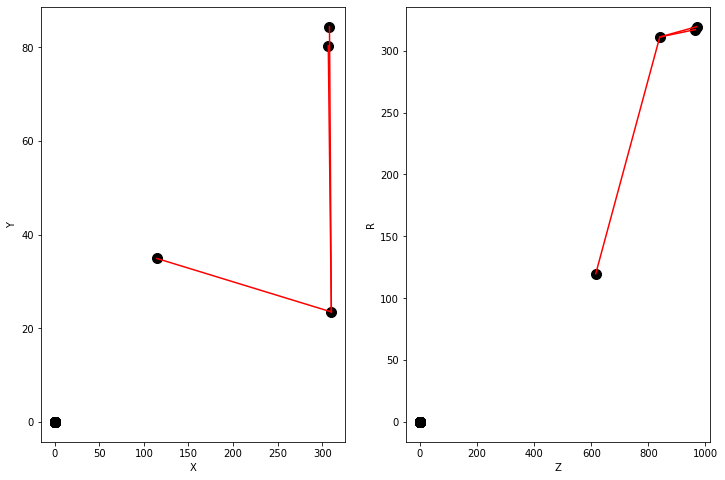

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00023637 0.0002343  0.00023238 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


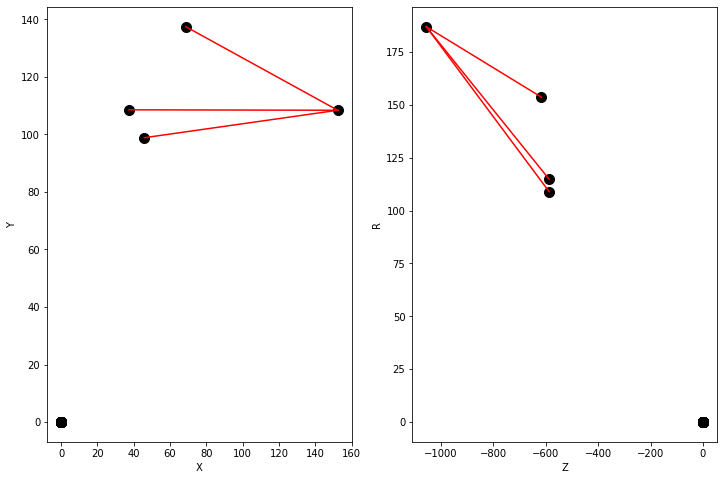

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00040941 0.00040217 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


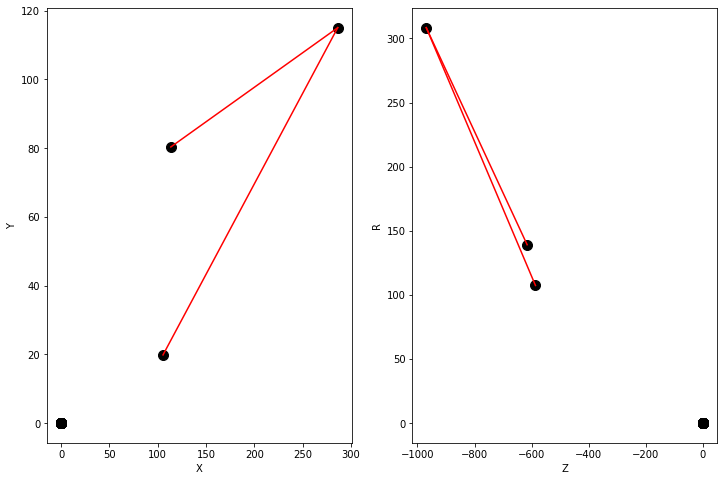

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.0002807  0.00071826 0.00027681 0.00070374 0.0002705  0.00070342
 0.00022887 0.00024576 0.00021482 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


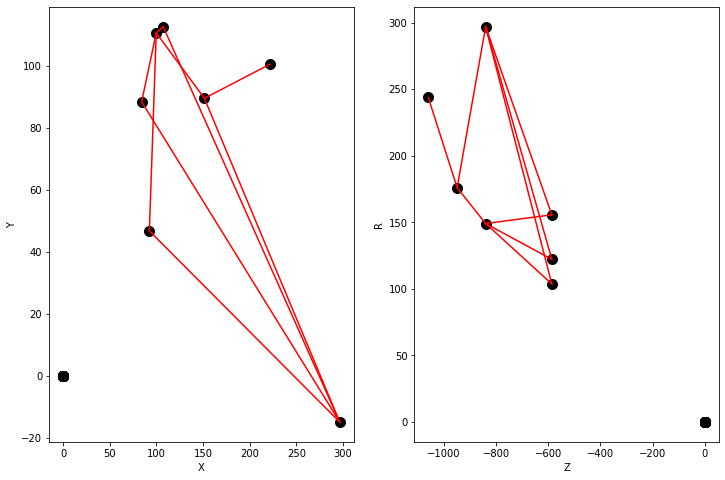

Y = [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.16944179 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.984, precision 0.000, recall 0.000


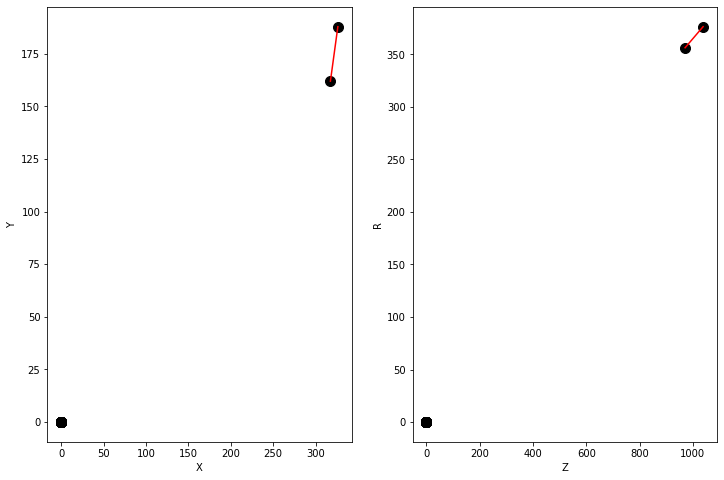

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00054446 0.00055788 0.00053542 0.0005499  0.00035183 0.00022124
 0.00041916 0.00035178 0.00022084 0.00041932 0.00030079 0.00028134
 0.00030802 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


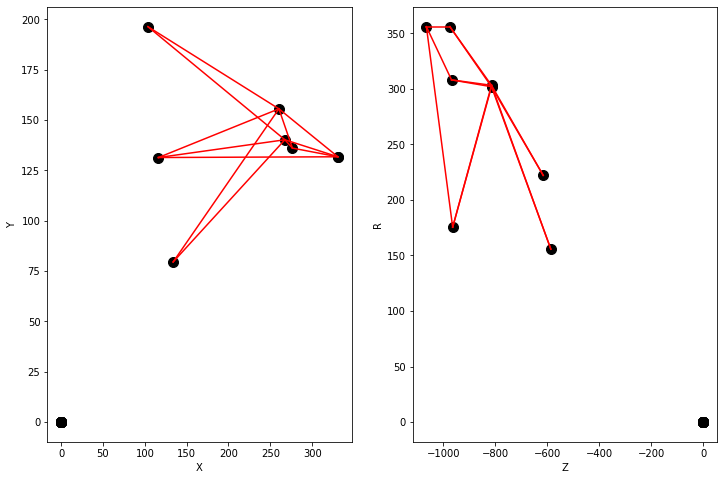

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.2431952  0.48232818 0.34172967 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.984, precision 0.000, recall 0.000


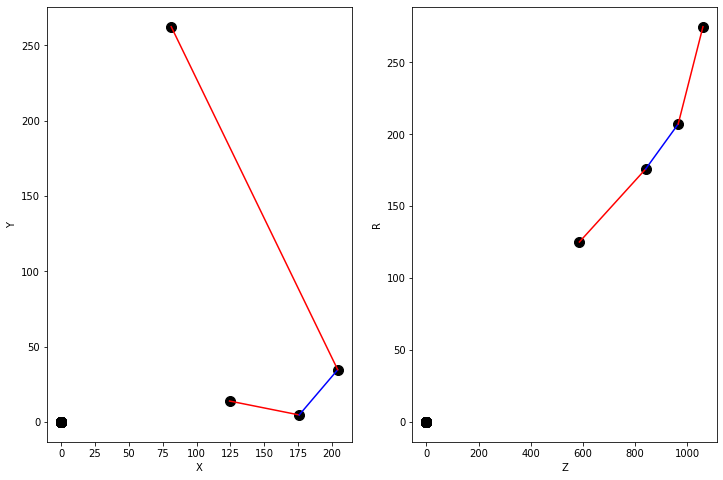

Y = [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.45476264 0.32445252 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.984, precision 1.000, recall 0.500


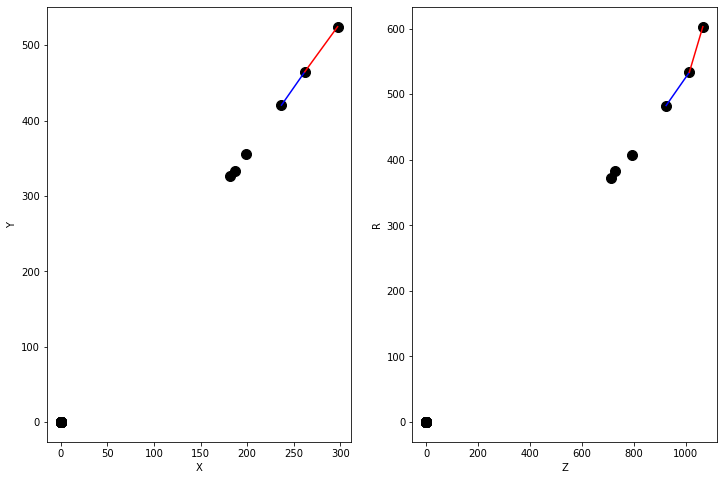

Y = [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.07967562 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.984, precision 0.000, recall 0.000


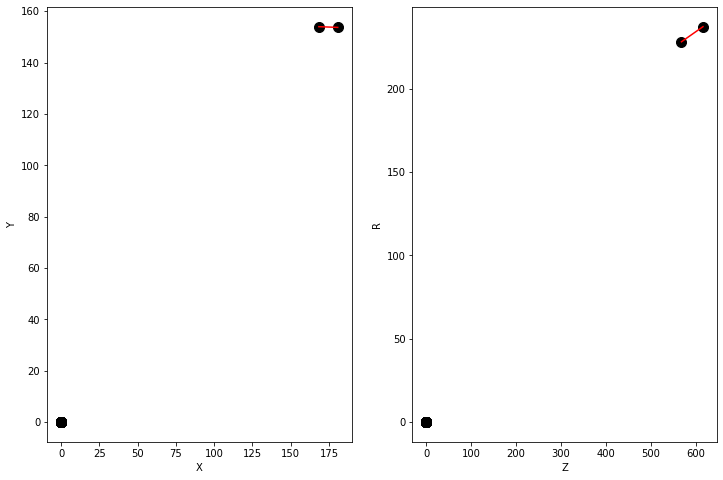

Y = [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.62493306 0.58724624 0.5599301  0.5364215  0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 1.000, recall 1.000


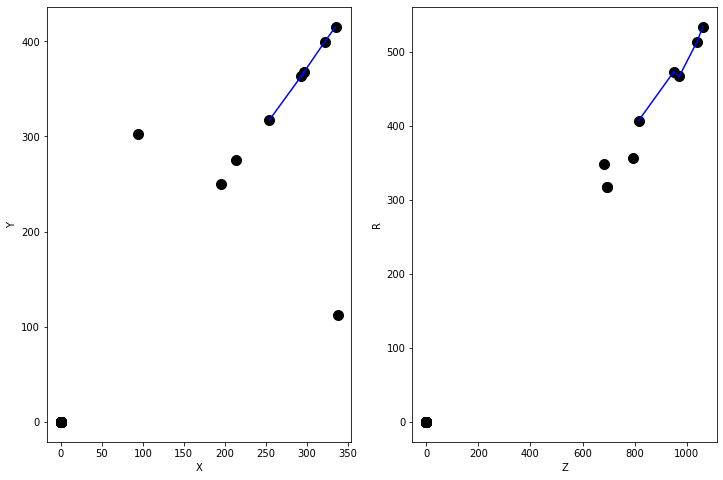

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.08635492 0.0681517  0.06038558 0.05886422 0.05349976 0.05189672
 0.10201088 0.07931345 0.07025313 0.06839991 0.06221531 0.06027245
 0.08372953 0.06726358 0.06304293 0.06263433 0.06105484 0.06062633
 0.46238235 0.39617905 0.2622453  0.2873506  0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 1.000, recall 1.000


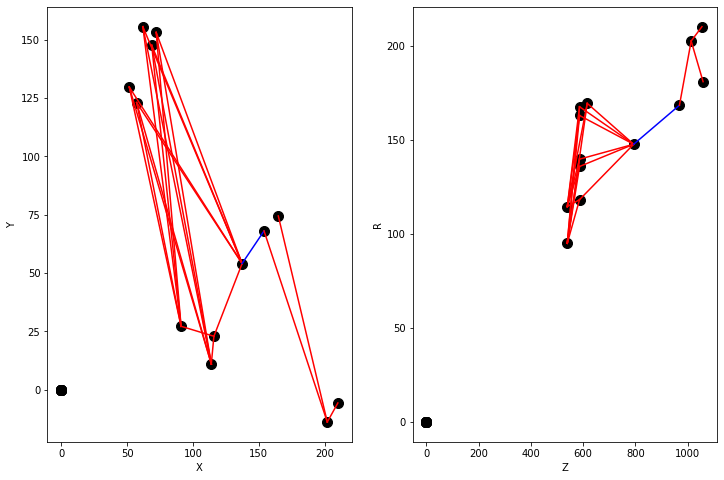

Y = [1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.3513556  0.50167406 0.5913403  0.58387035 0.49811846 0.4416677
 0.35509244 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.967, precision 1.000, recall 0.714


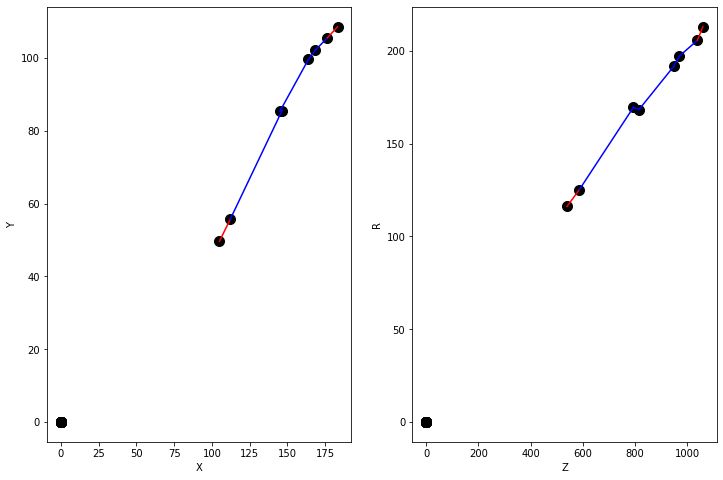

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.0003795  0.0002749  0.00037723 0.00027965 0.0002746  0.00026828
 0.00027238 0.00024791 0.00018881 0.00024088 0.00023958 0.00023561
 0.00023519 0.00016763 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


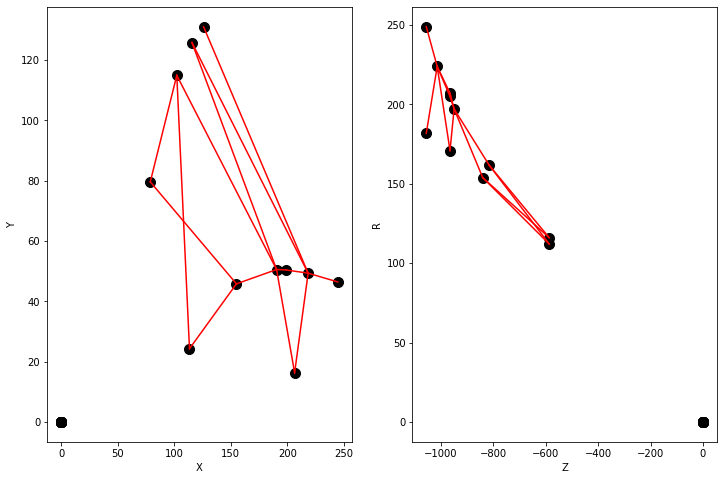

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.4254493  0.3738303  0.43621105 0.18075138 0.38368857 0.5956972
 0.20616323 0.22958942 0.22032663 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.951, precision 0.000, recall 0.000


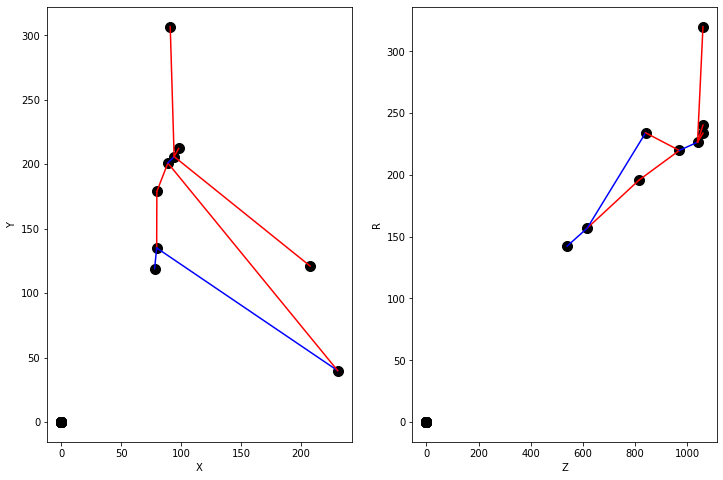

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00029186 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


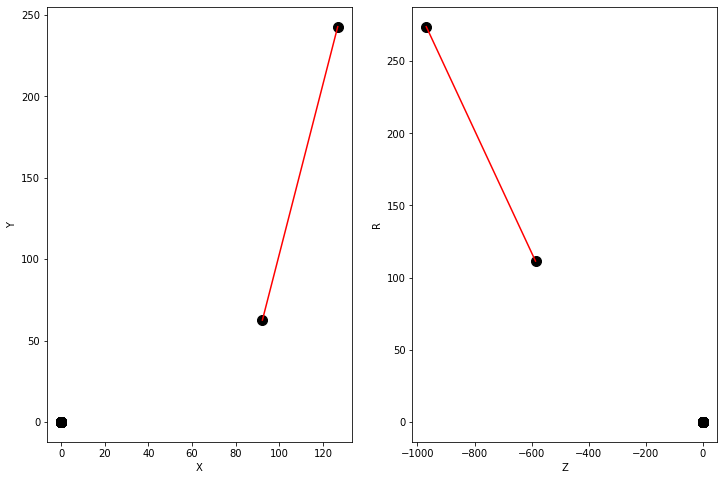

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.03980517 0.03449954 0.04056977 0.0351561  0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


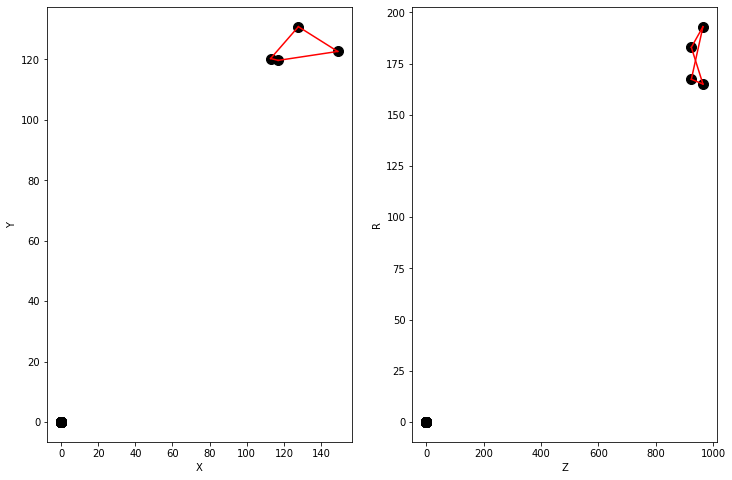

Y = [1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.16452318 0.17766796 0.15532517 0.24814682 0.27028224 0.22988231
 0.13349773 0.20929043 0.09653792 0.27113396 0.26995826 0.28525895
 0.17674483 0.1821967  0.17573449 0.18110132 0.21969005 0.22919782
 0.23913497 0.25042972 0.2677986  0.28157908 0.30600318 0.35506392
 0.46487752 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.869, precision 1.000, recall 0.111


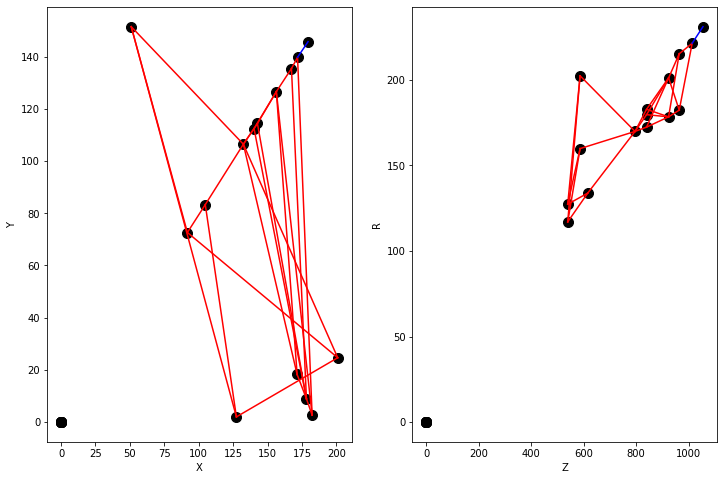

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.0771848  0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


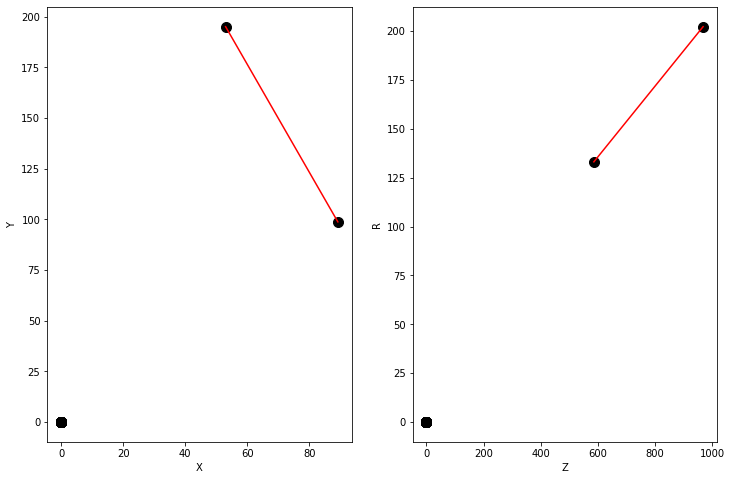

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.08820567 0.08827087 0.07822385 0.07822463 0.03014282 0.03005342
 0.0283268  0.02824164 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


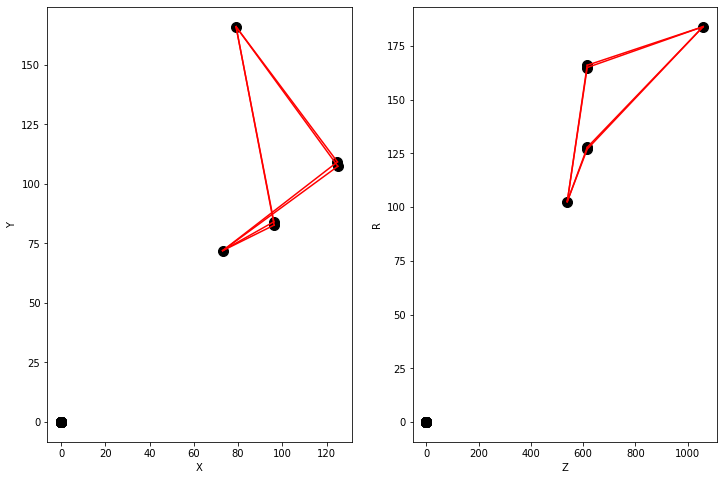

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00040205 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


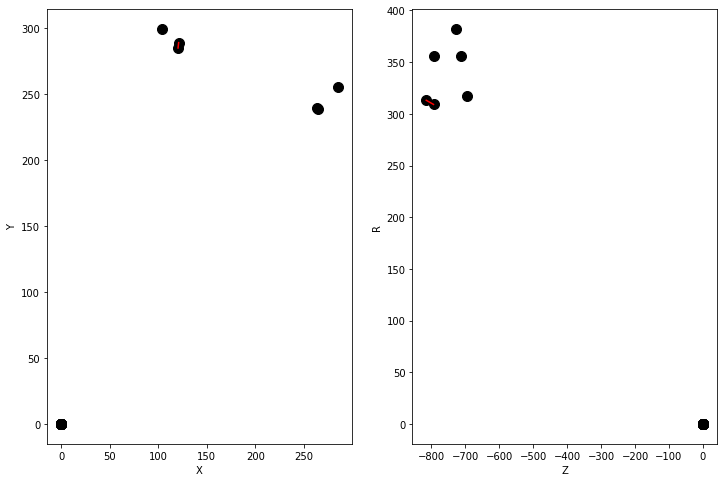

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00024002 0.00017782 0.00017153 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


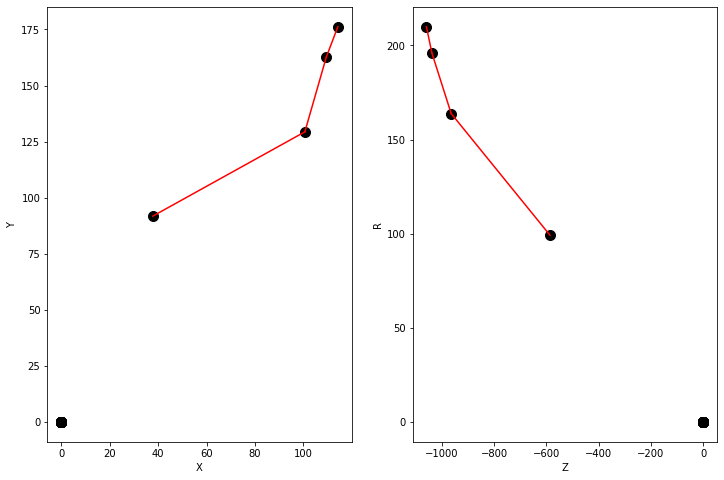

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.36677995 0.19490558 0.1994731  0.22476058 0.2354134  0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


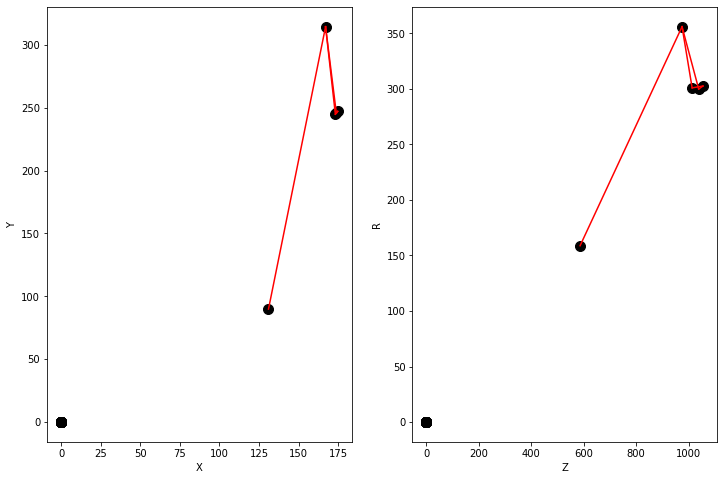

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00027007 0.00026818 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


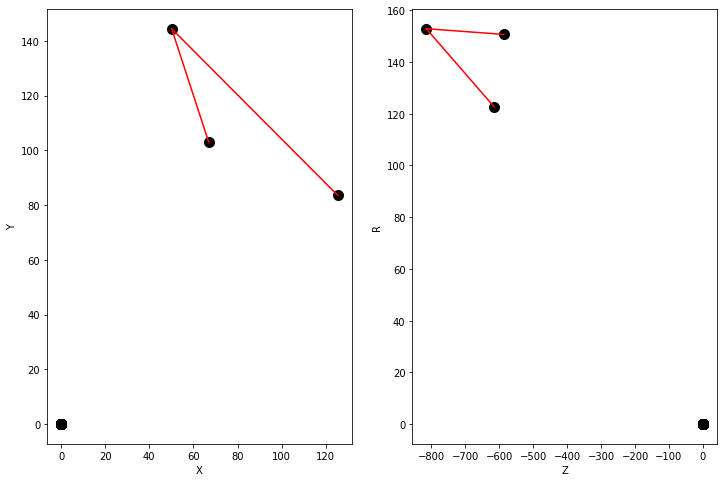

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.10049806 0.10116235 0.0960306  0.10000337 0.10061035 0.10127605
 0.09613598 0.10011534 0.087689   0.08826435 0.0837863  0.08724995
 0.08785234 0.08842941 0.08394051 0.08741275 0.07573621 0.07018074
 0.0686822  0.0636017  0.10212716 0.09488856 0.0741977  0.06874599
 0.2915042  0.2755167  0.2786368  0.26307392 0.21822514 0.23350741
 0.21593335 0.20596988 0.22023328 0.20348158 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


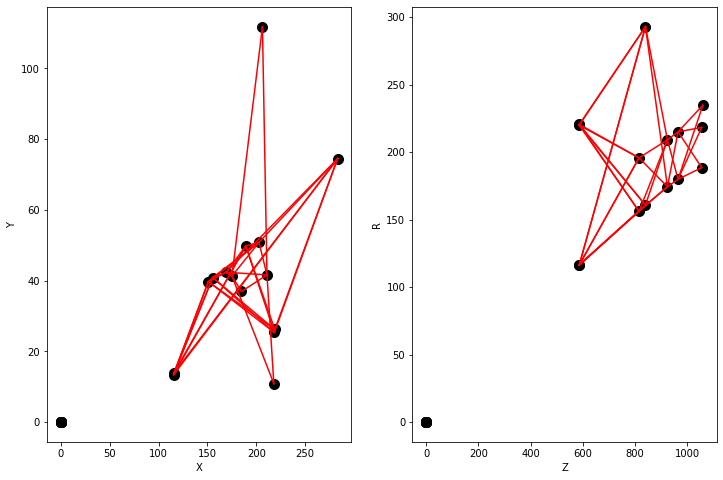

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00057702 0.00057331 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


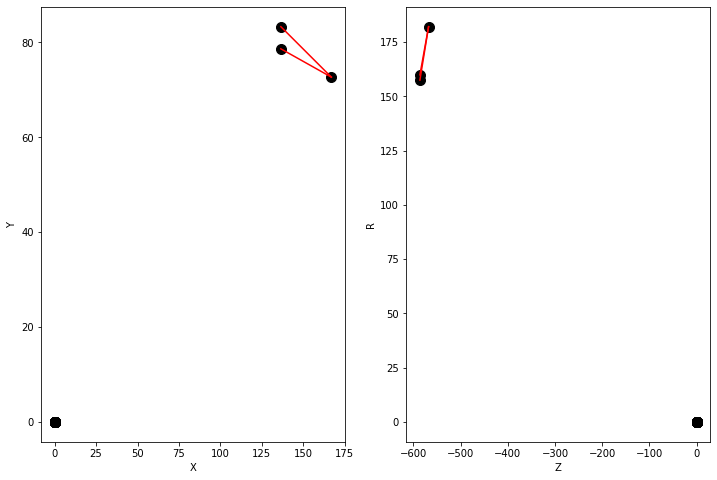

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00052178 0.00034683 0.00053394 0.00034918 0.00052557 0.0003466
 0.00037883 0.00036848 0.00020383 0.00027319 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


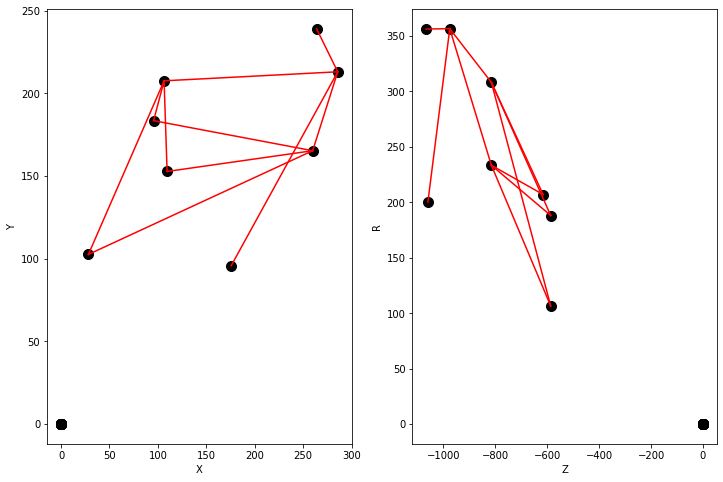

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00036896 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


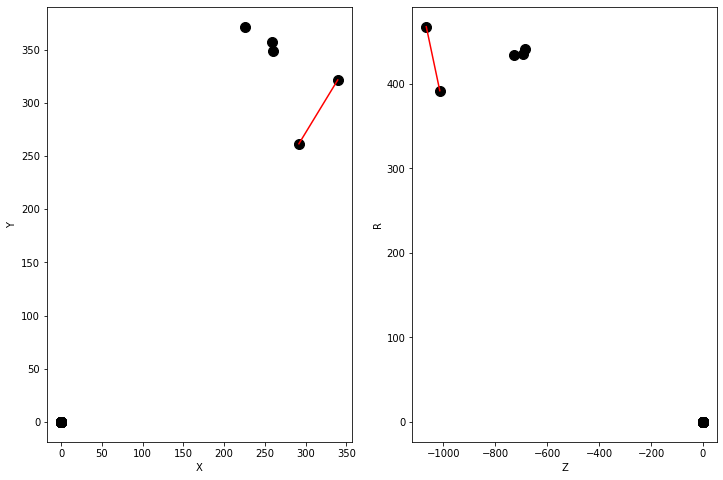

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.14795063 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


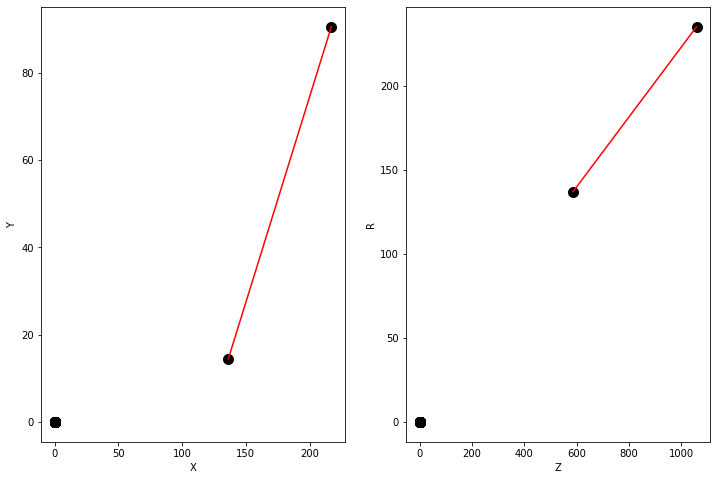

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00064924 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


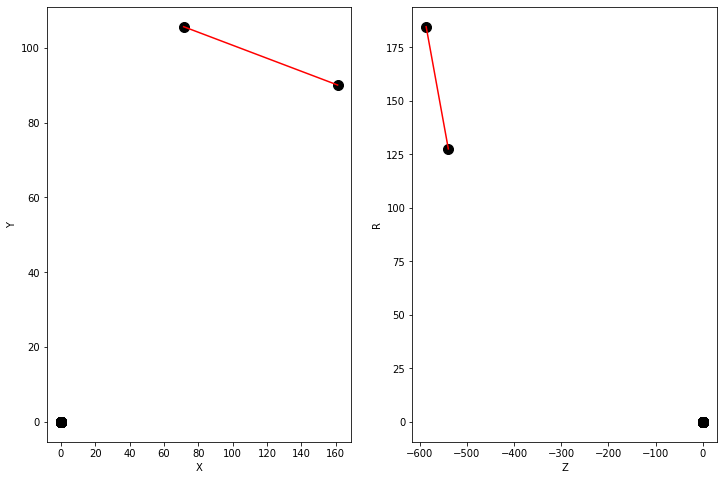

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00039126 0.00039155 0.00039778 0.00028959 0.00025752 0.00023468
 0.00021715 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


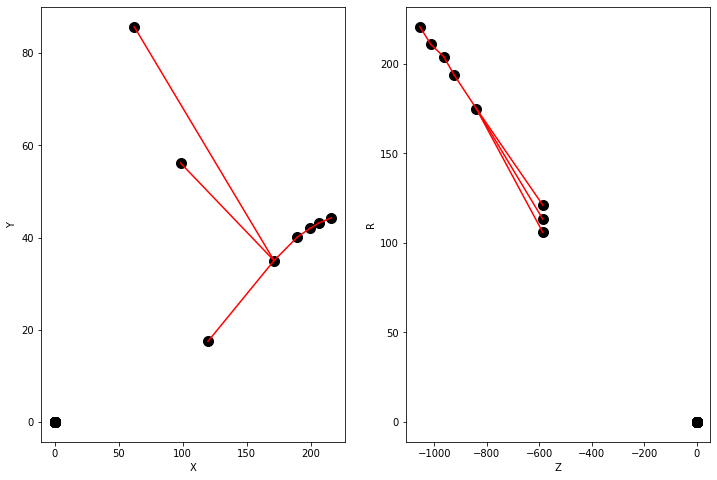

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.04714623 0.05250567 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


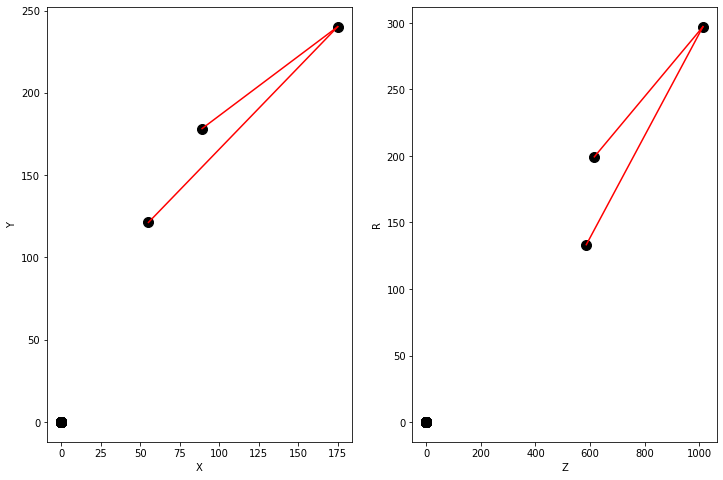

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00049119 0.00061275 0.00045997 0.0003533  0.00050327 0.00061781
 0.00048024 0.0003754  0.00035342 0.00036443 0.00037041 0.00037121
 0.00025893 0.00020957 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


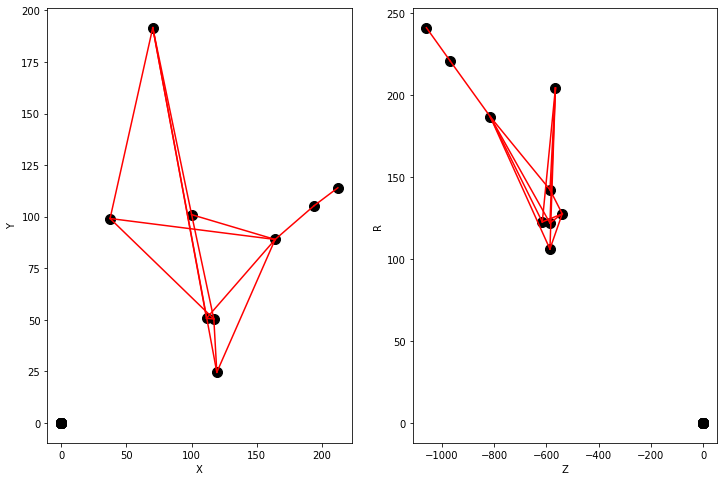

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00021613 0.00021968 0.00023656 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


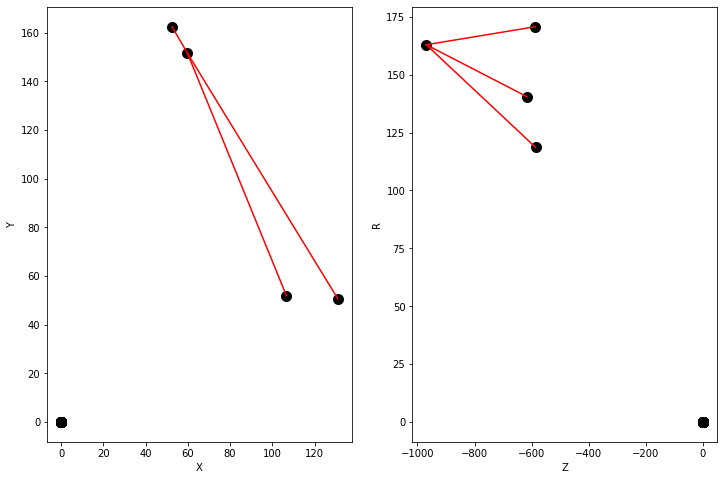

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.04985865 0.05234399 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


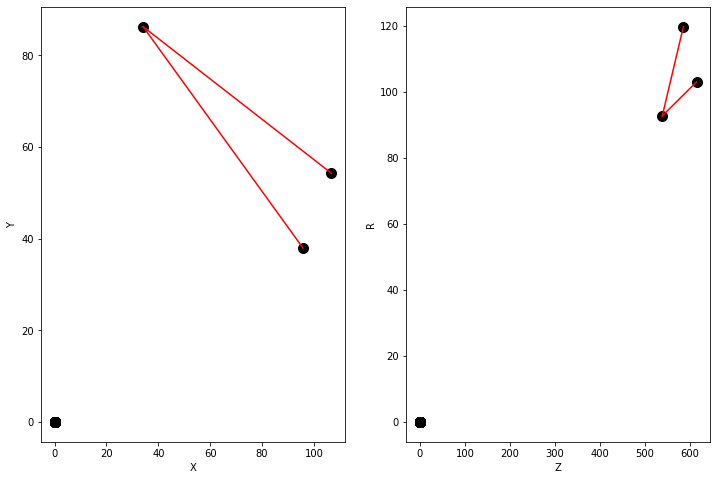

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.09022591 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


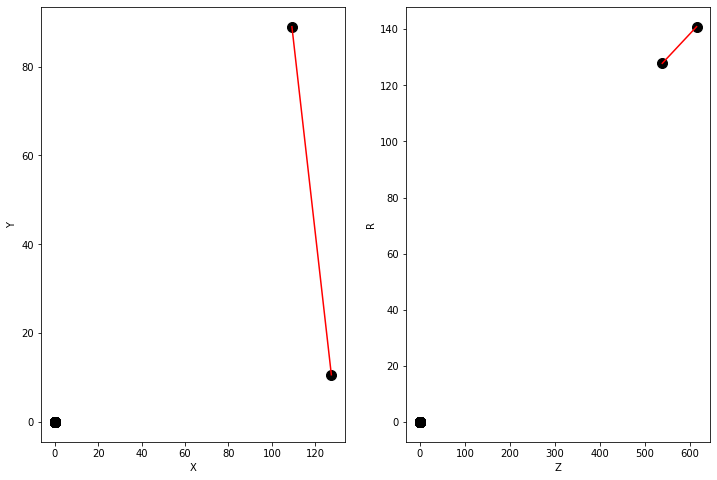

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00024603 0.0002182  0.00022836 0.00022626 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


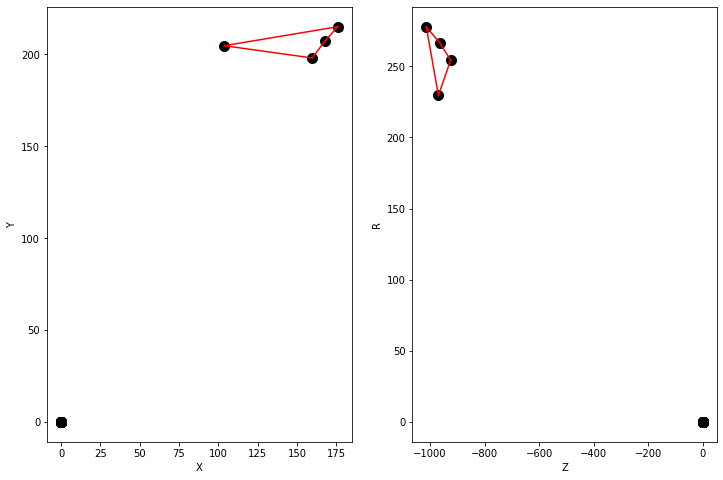

Y = [1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.28789786 0.28715882 0.56789523 0.5674097  0.33548912 0.3337202
 0.315106   0.28750926 0.26929078 0.26954448 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.918, precision 1.000, recall 0.286


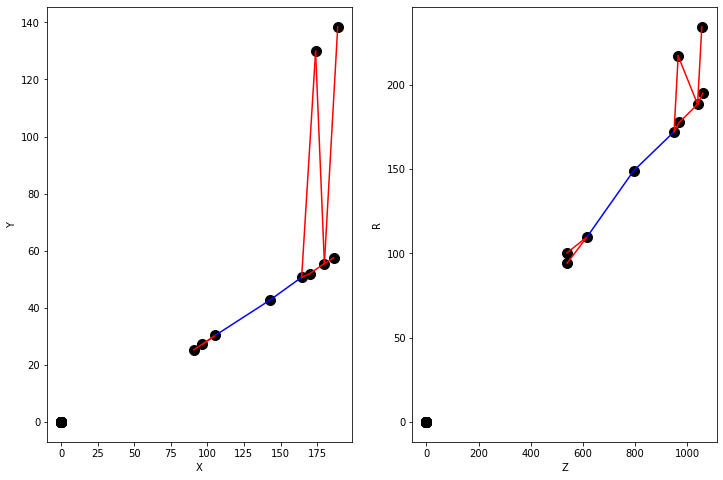

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00065806 0.00062956 0.00046775 0.00046784 0.00039427 0.000319
 0.0002795  0.00025499 0.00017116 0.00023795 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


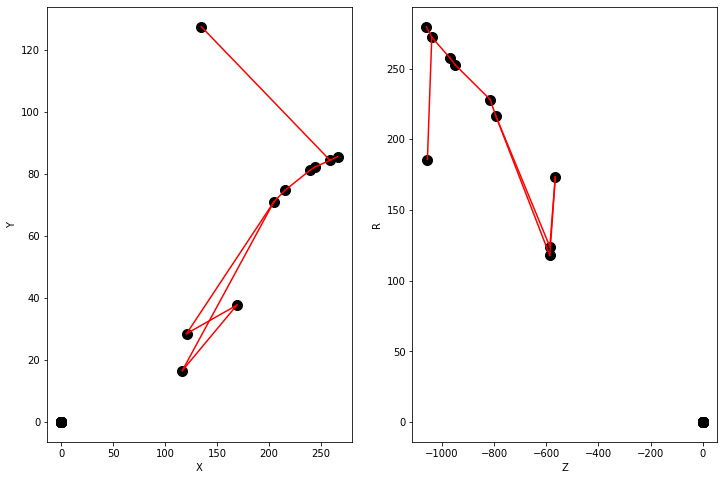

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00041374 0.00029239 0.00025611 0.00021376 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


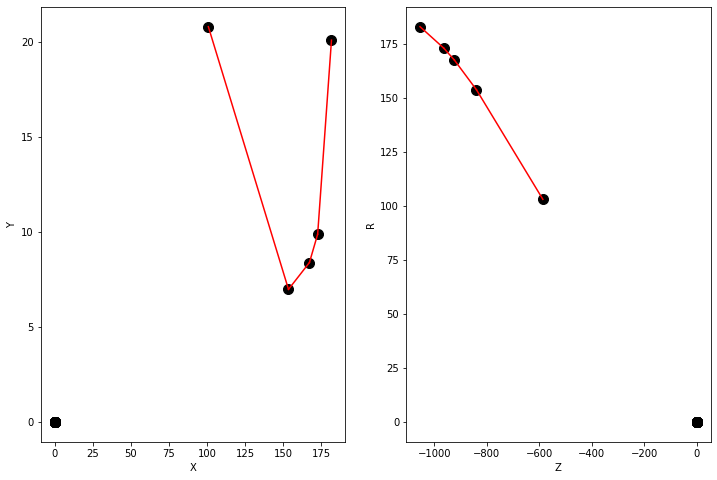

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.10856897 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


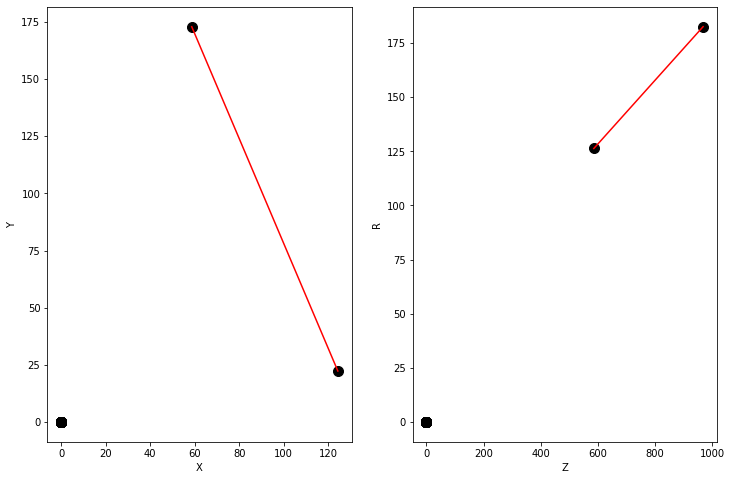

Y = [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.177289   0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.984, precision 0.000, recall 0.000


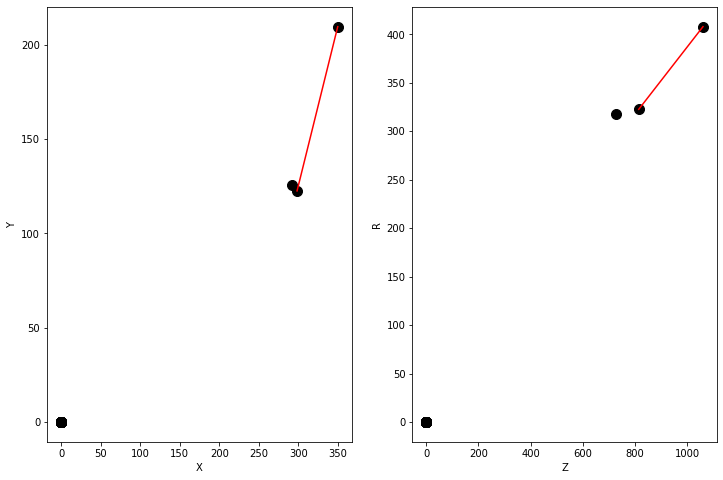

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00021523 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


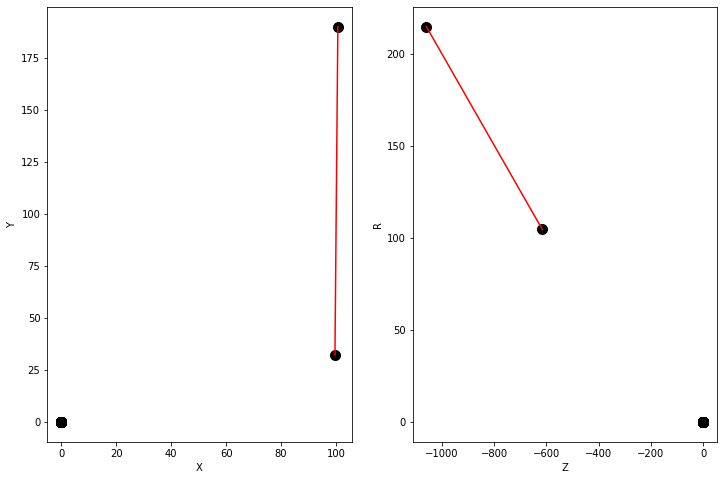

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00024854 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


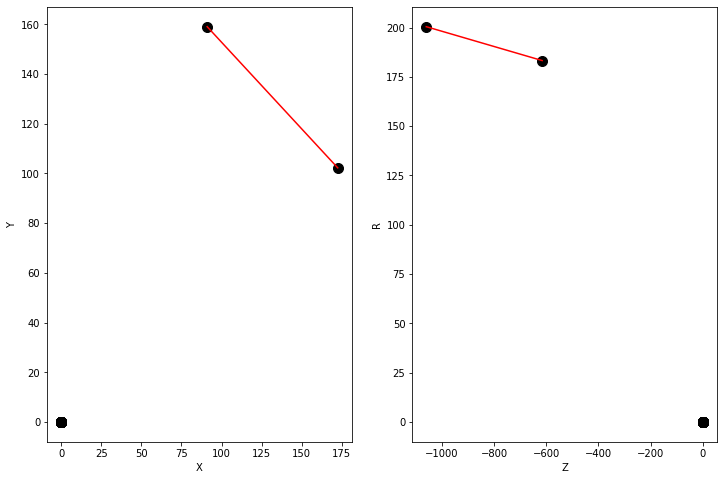

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.15102193 0.15043543 0.21956345 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


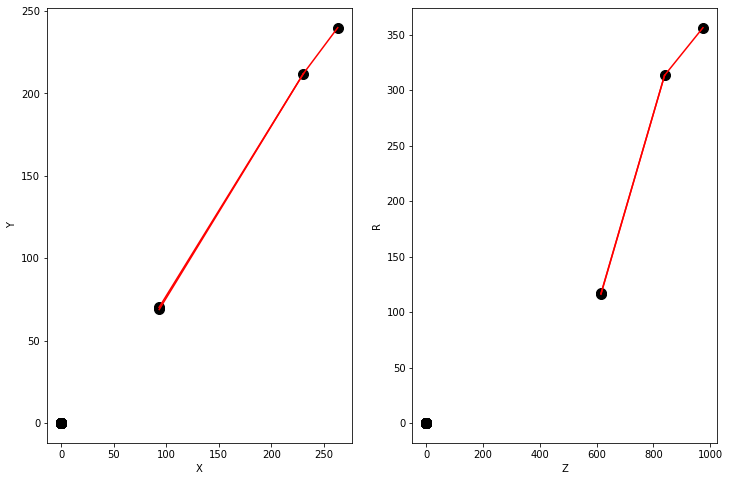

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.05531957 0.05368378 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


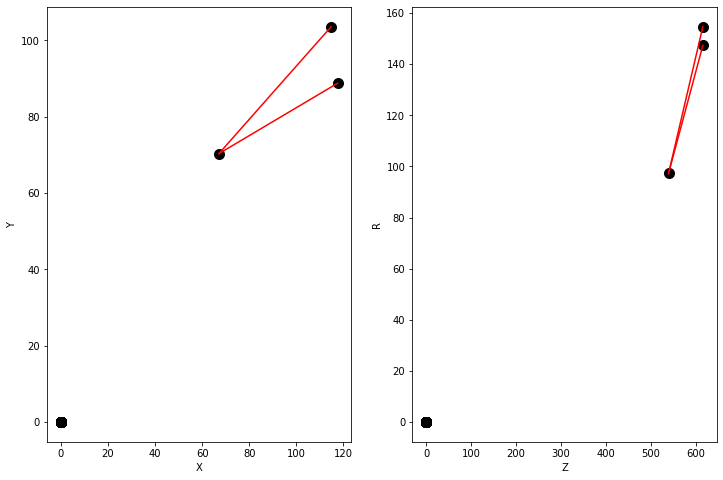

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.11558929 0.12491517 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


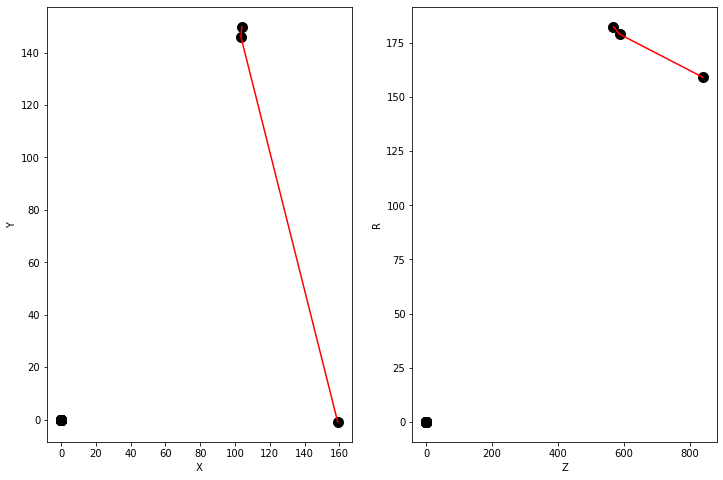

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.02754266 0.029046   0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


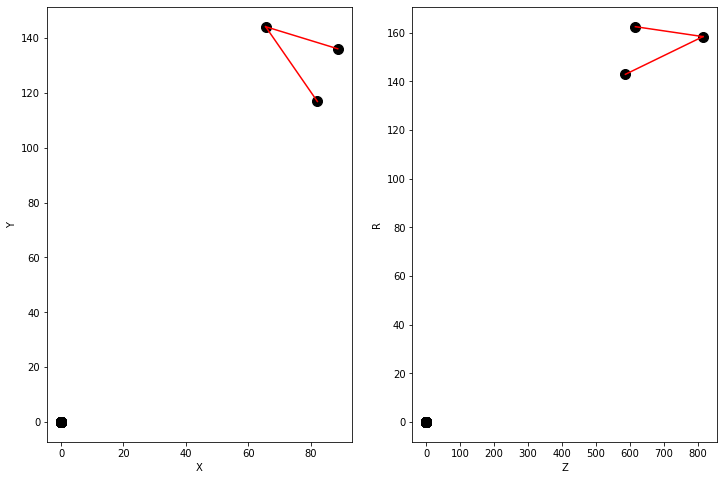

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00036328 0.00040704 0.00030555 0.00027405 0.00024805 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


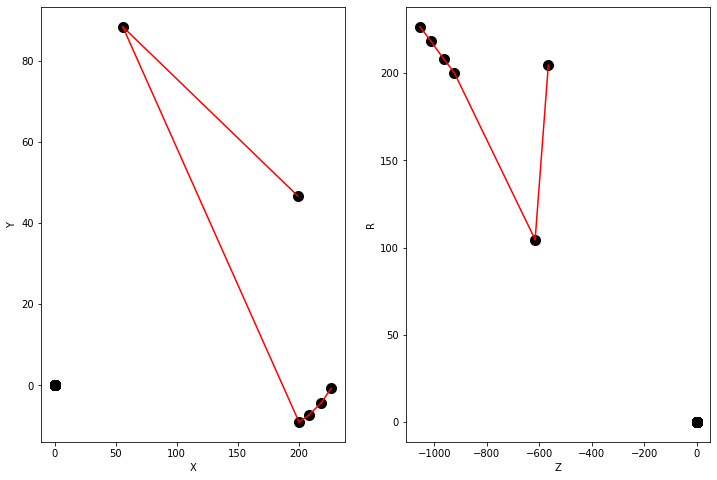

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00109813 0.00094691 0.00091574 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


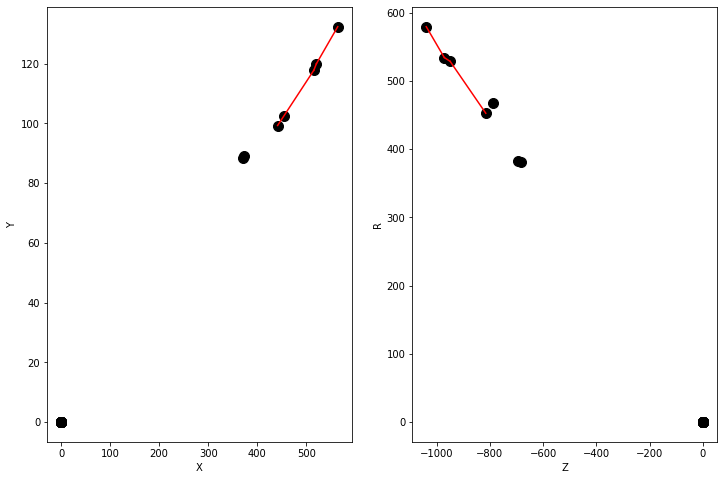

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00034825 0.00034076 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


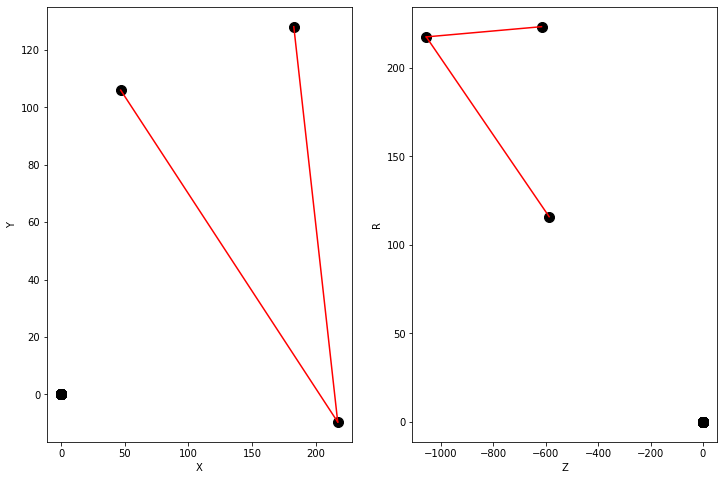

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00048873 0.00042452 0.00020224 0.0002629  0.00025975 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


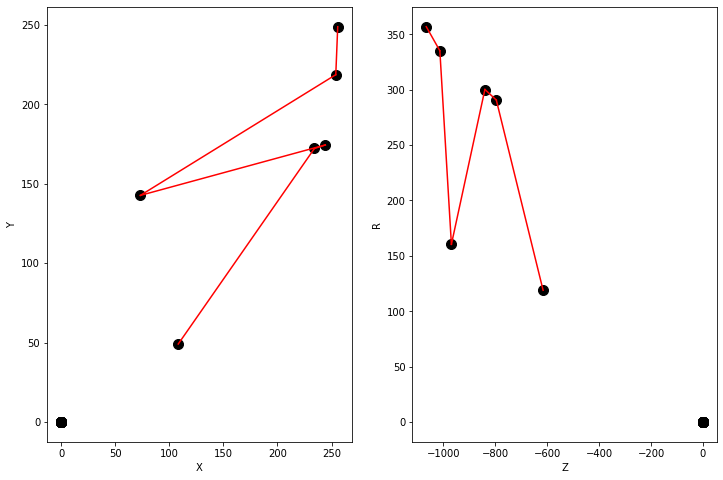

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.0551112  0.05533479 0.05966144 0.06083405 0.05936623 0.27271932
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


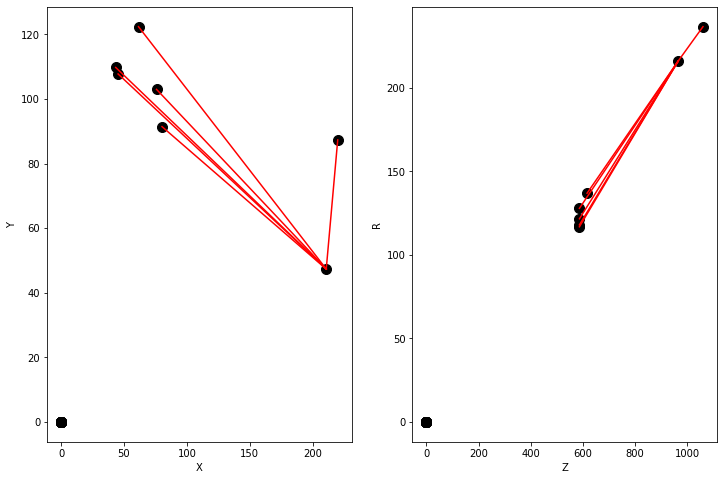

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00037261 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


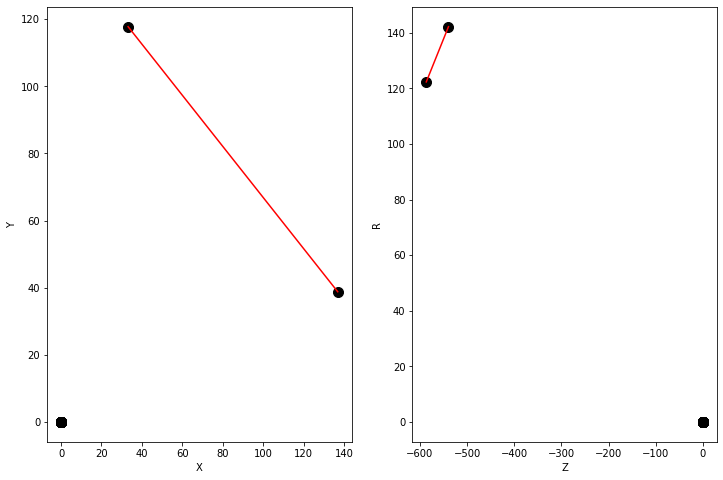

Y = [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.31121486 0.3570347  0.33484218 0.25107458 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.934, precision 0.000, recall 0.000


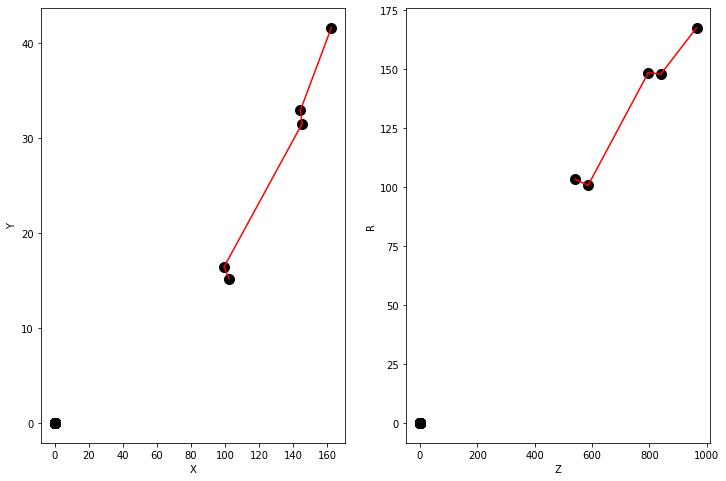

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00079314 0.00077864 0.00066796 0.00032027 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


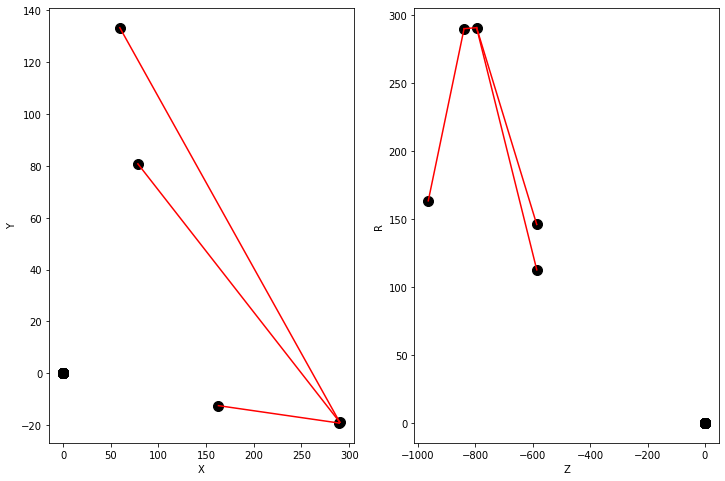

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.34069577 0.3481542  0.33591577 0.21843494 0.21182327 0.20524299
 0.19890173 0.31670925 0.30413195 0.42985806 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.984, precision 0.000, recall 0.000


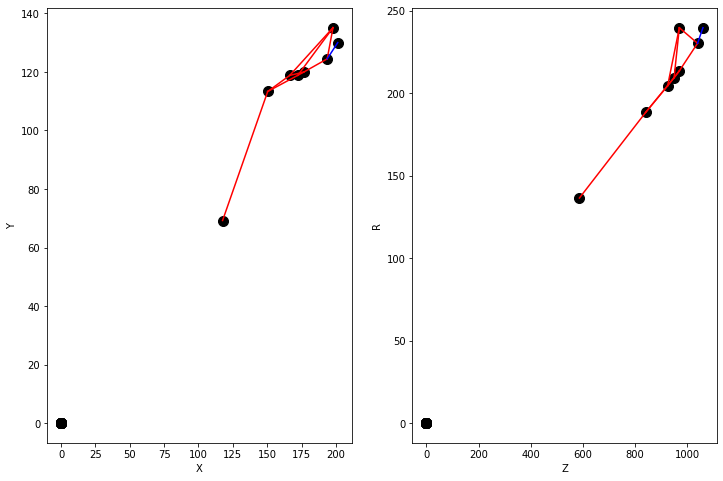

Y = [0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.24625969 0.2599083  0.34043702 0.32609093 0.47369093 0.40288937
 0.2774362  0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.984, precision 1.000, recall 0.667


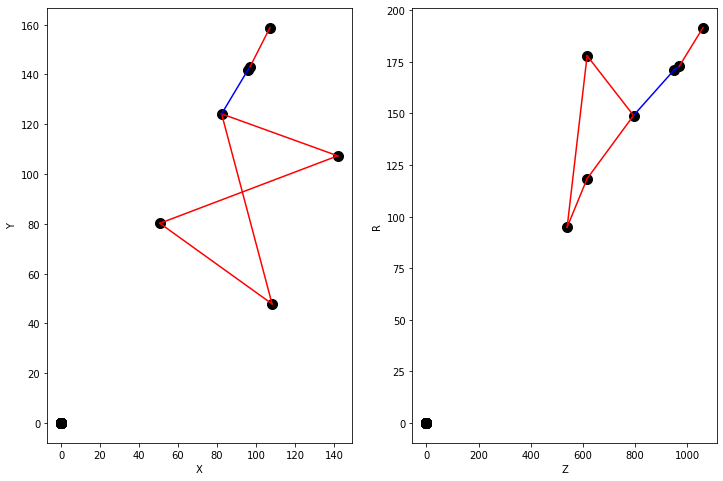

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00040219 0.00041394 0.00040577 0.00032185 0.00022048 0.00020429
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


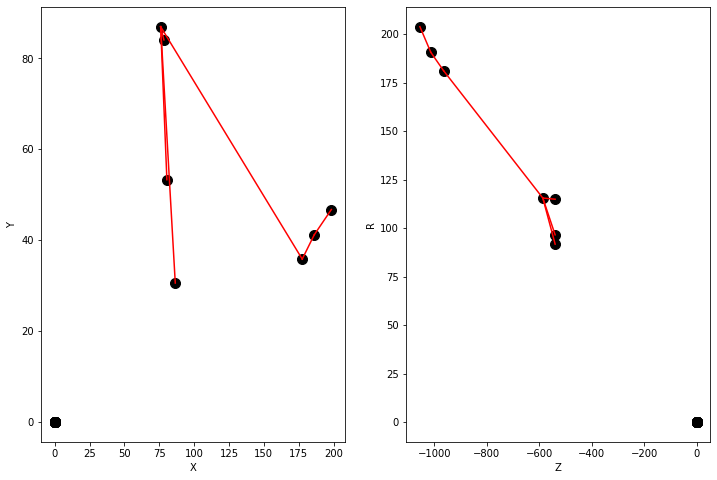

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.05079702 0.03278342 0.04207726 0.02781703 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


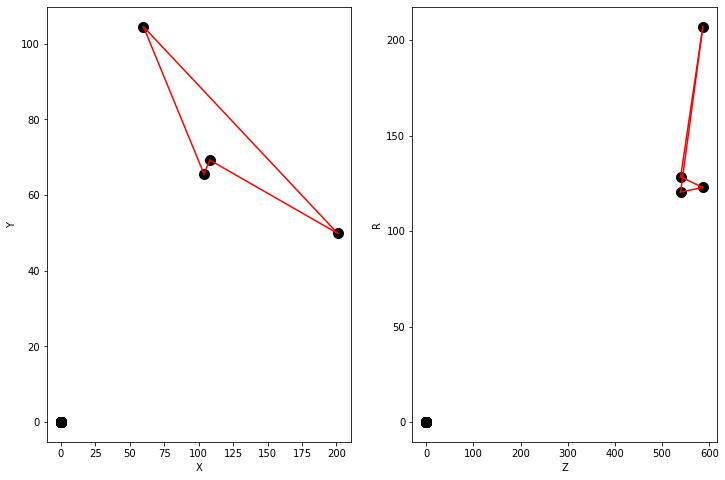

Y = [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.6121718  0.57461405 0.5559744  0.5019861  0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 1.000, recall 1.000


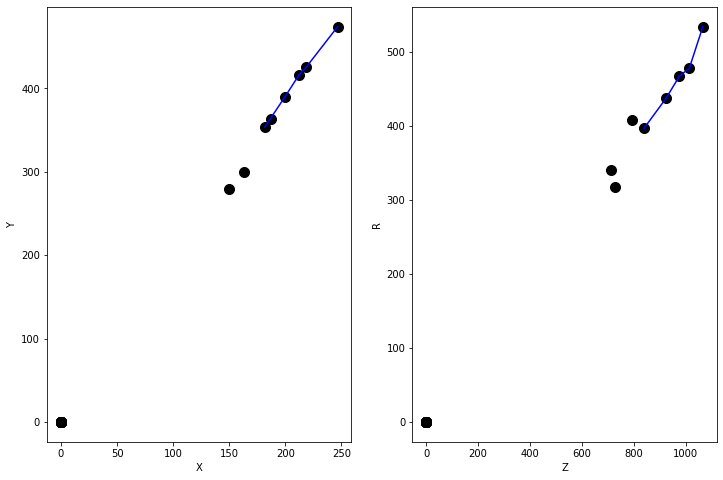

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.14496769 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


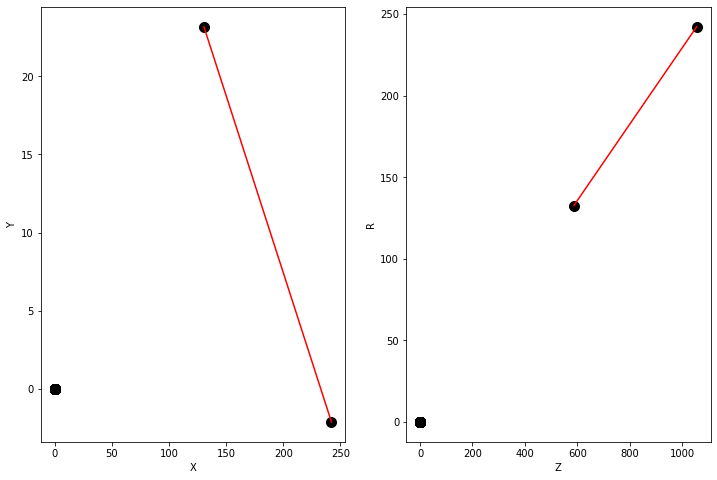

Y = [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.3968134  0.4068133  0.4386499  0.3592716  0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.967, precision 1.000, recall 0.500


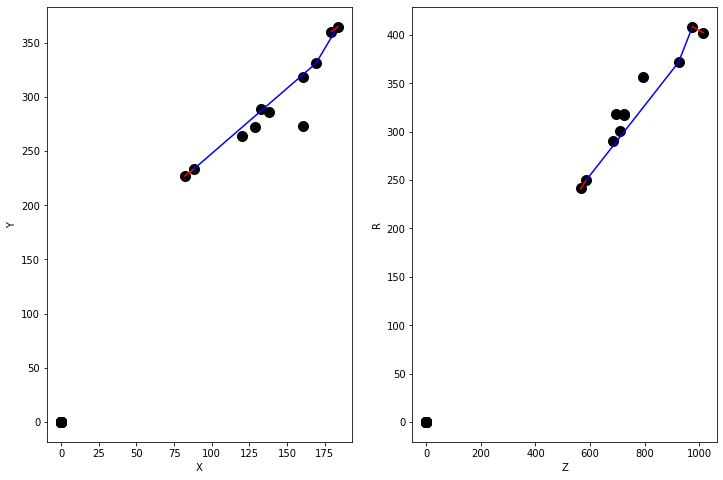

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00028747 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


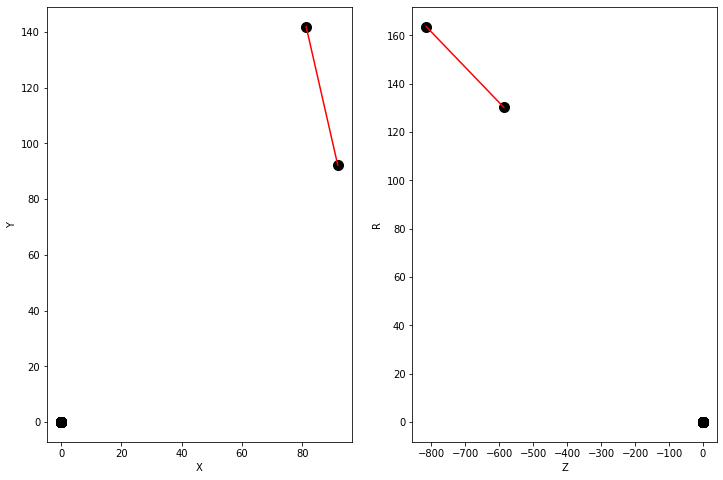

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.01827361 0.01828562 0.01847362 0.01688793 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


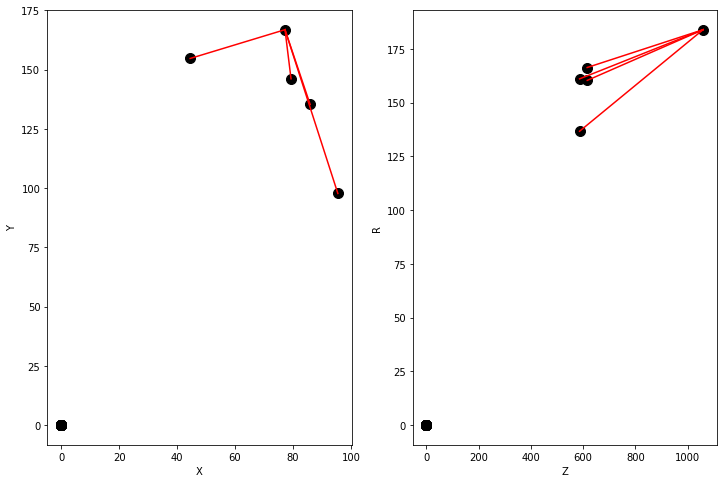

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.42715245 0.430322   0.4938361  0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.951, precision 0.000, recall 0.000


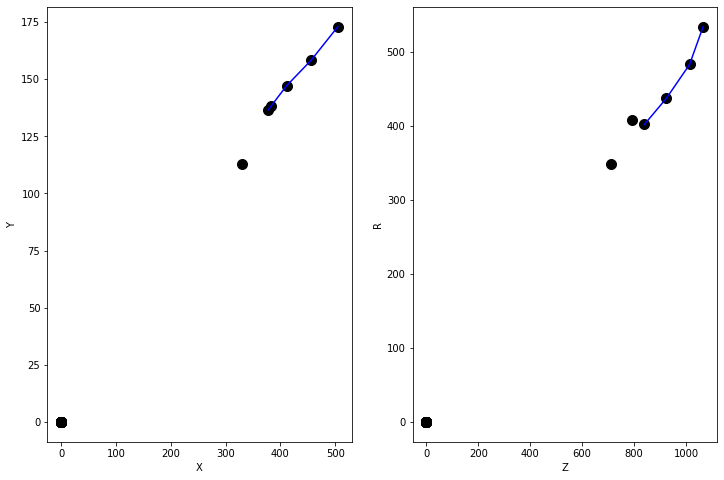

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00049833 0.00059788 0.00038007 0.00050272 0.00059385 0.00038835
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


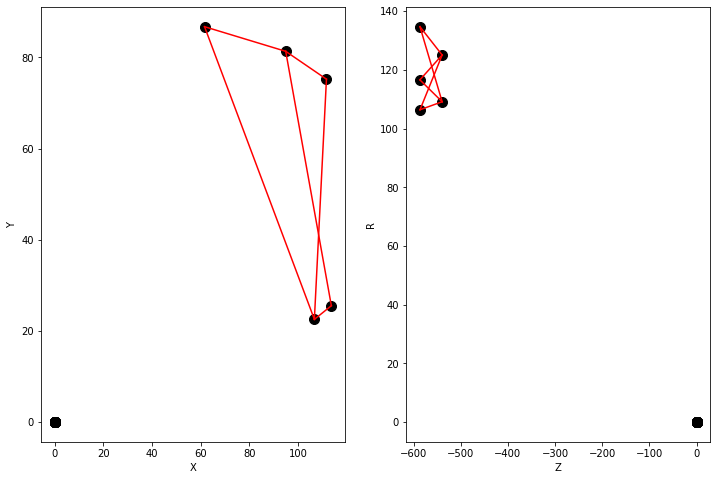

Y = [0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.33823073 0.327514   0.3254646  0.22857632 0.23073106 0.24388373
 0.7262102  0.58913    0.5856744  0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.984, precision 1.000, recall 0.750


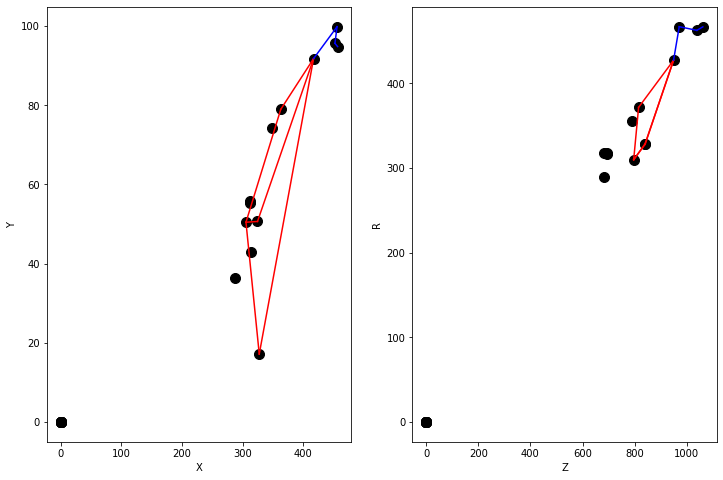

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.12079491 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


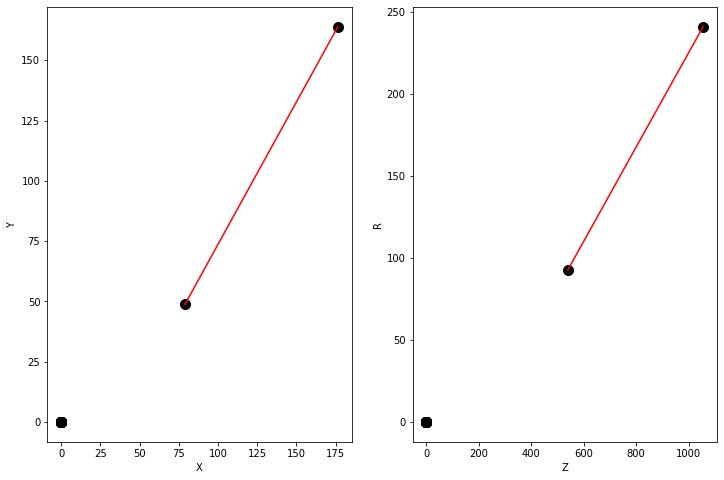

Y = [1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.28561214 0.28811926 0.18767819 0.22502066 0.23752901 0.1475764
 0.7253221  0.7291609  0.42610693 0.33994144 0.3770369  0.23879465
 0.4739703  0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.951, precision 1.000, recall 0.571


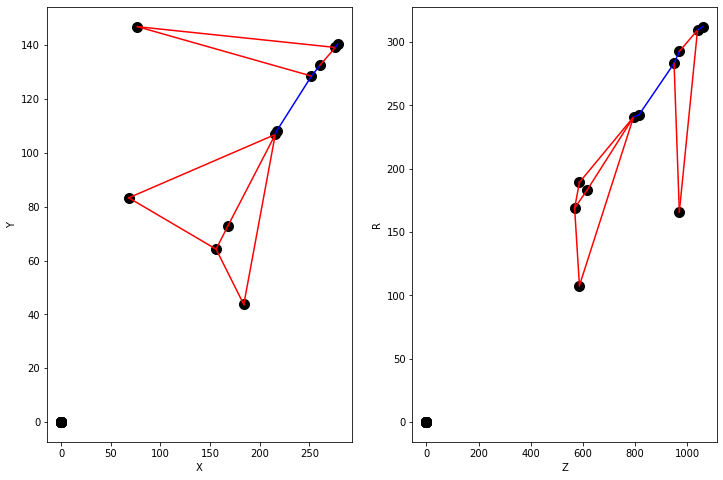

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.3644427  0.41688067 0.37273848 0.27211452 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.984, precision 0.000, recall 0.000


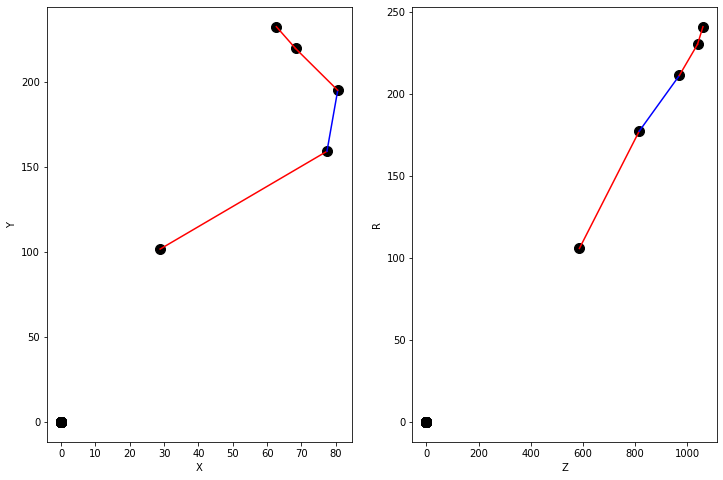

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.23354252 0.16224676 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


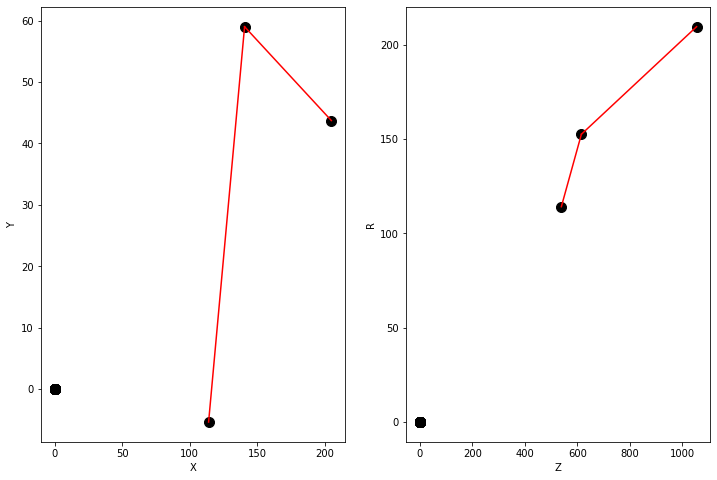

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.48613417 0.51580477 0.47921917 0.47652248 0.40843135 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.918, precision 0.000, recall 0.000


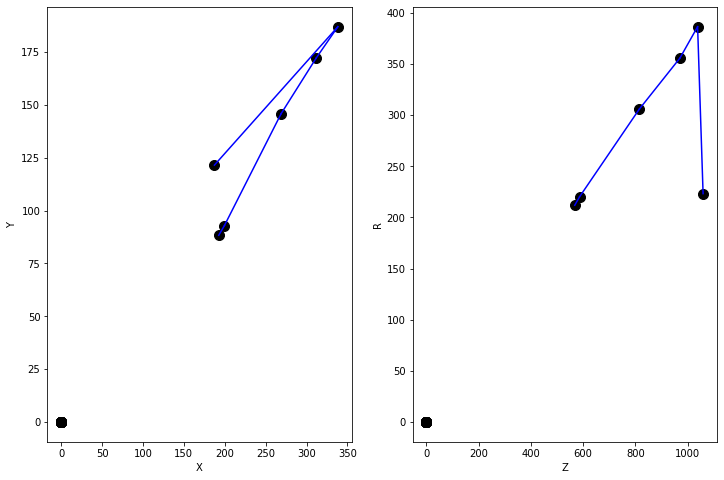

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00058024 0.00047001 0.00026061 0.00031259 0.00028238 0.00033668
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


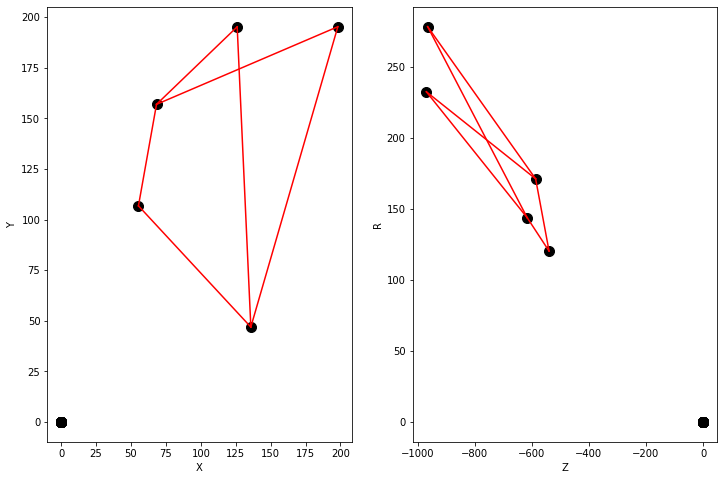

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00050099 0.00038484 0.00033385 0.00033132 0.00023224 0.00020635
 0.0001852  0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


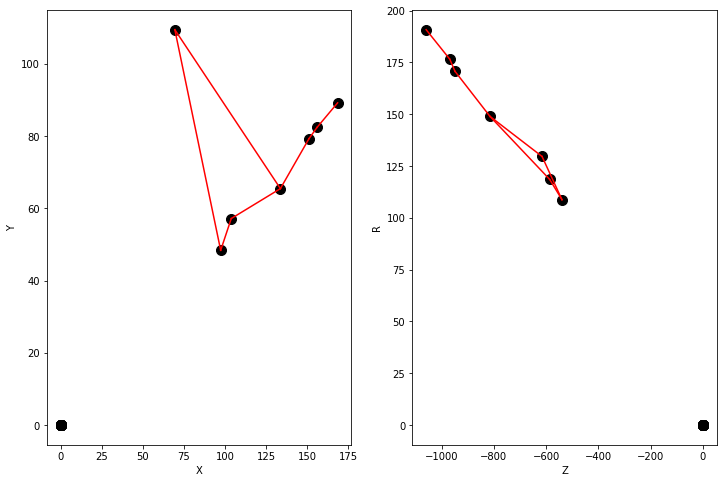

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00027002 0.00023779 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


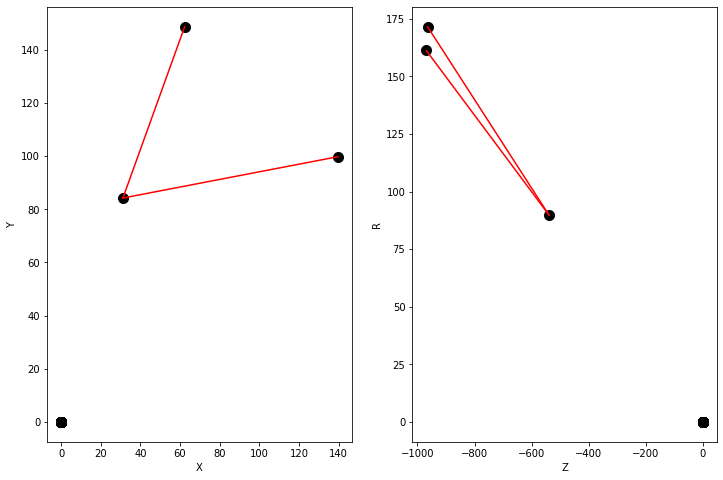

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.08238077 0.06725428 0.06049236 0.05047198 0.08049531 0.06538901
 0.20026723 0.12750193 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


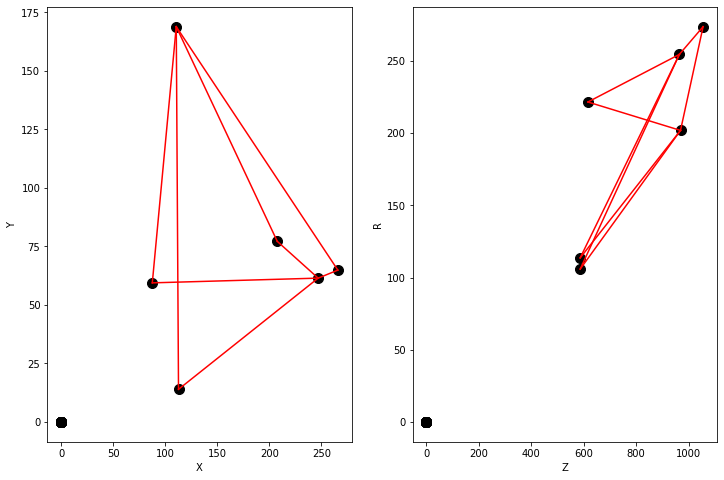

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.05079702 0.03278342 0.04207726 0.02781703 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


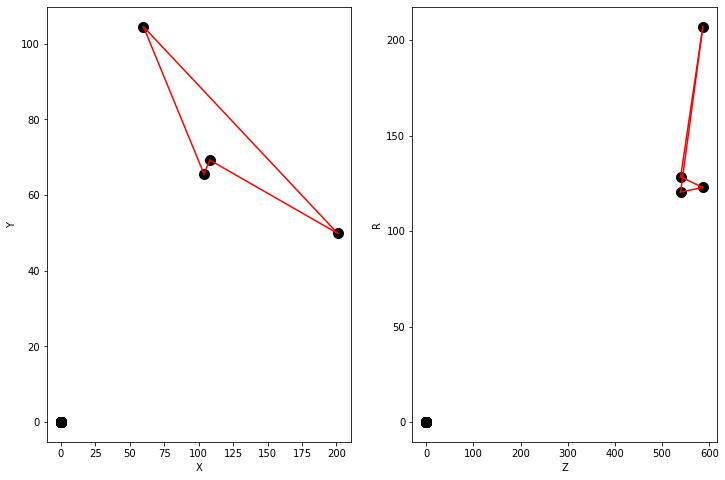

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00049905 0.00069518 0.00043031 0.00041834 0.00042957 0.00041752
 0.00029751 0.00029185 0.0002483  0.00022993 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


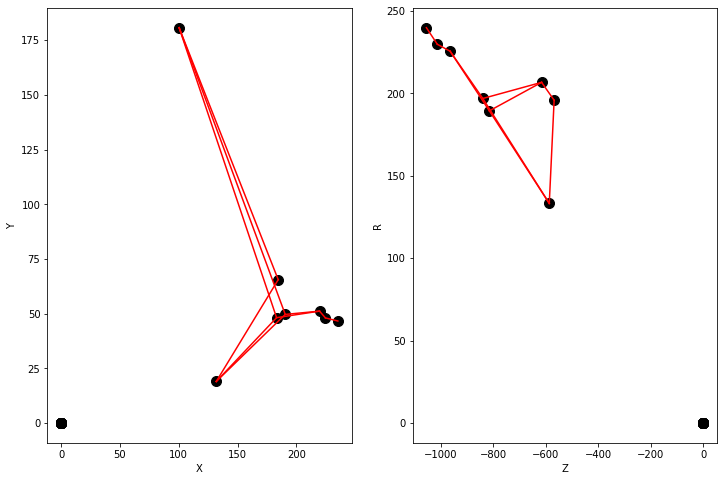

Y = [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.29285267 0.31066397 0.3826038  0.40049285 0.7313916  0.71608984
 0.58999896 0.5111202  0.39886376 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.934, precision 1.000, recall 0.556


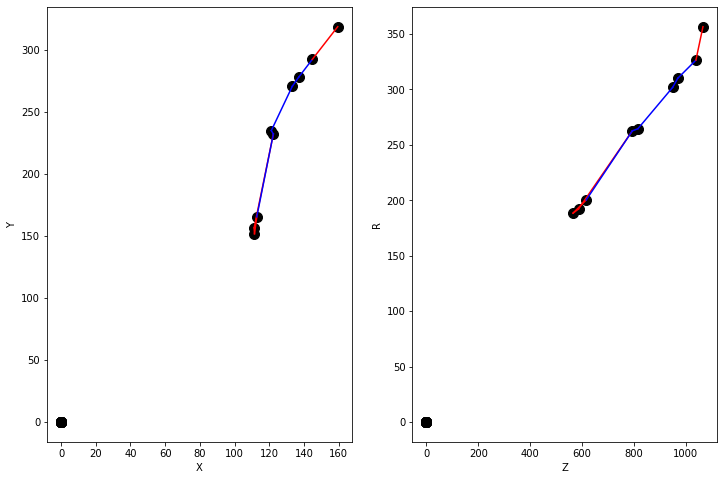

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.34911472 0.20625237 0.20162636 0.12606244 0.15290737 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


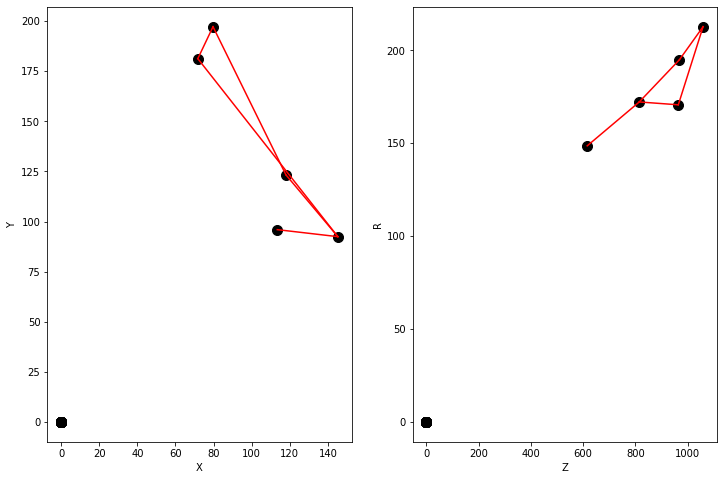

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.33327904 0.3573031  0.33013266 0.25404307 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


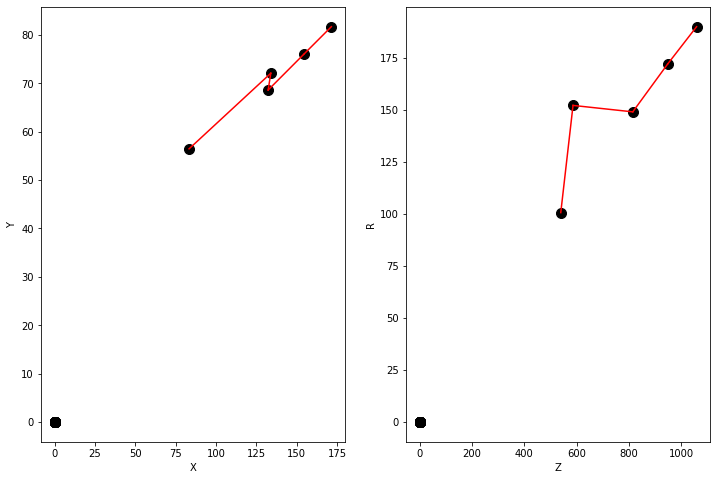

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.05263536 0.05244485 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


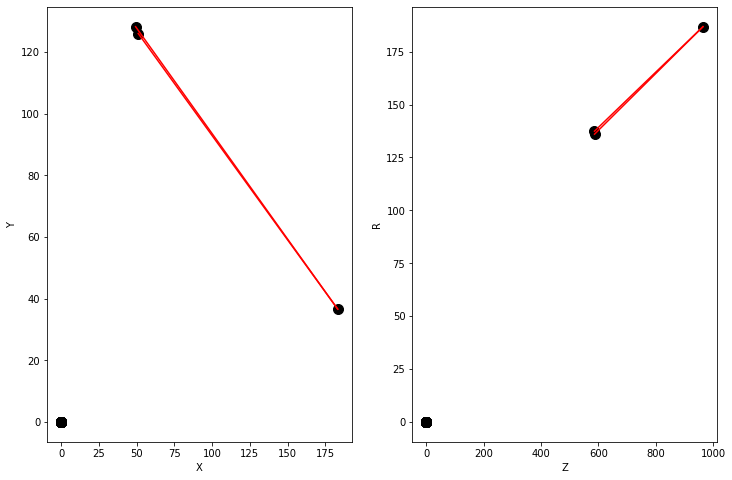

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.38325    0.24125446 0.14153609 0.12320174 0.15609623 0.17498699
 0.16864268 0.24743232 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


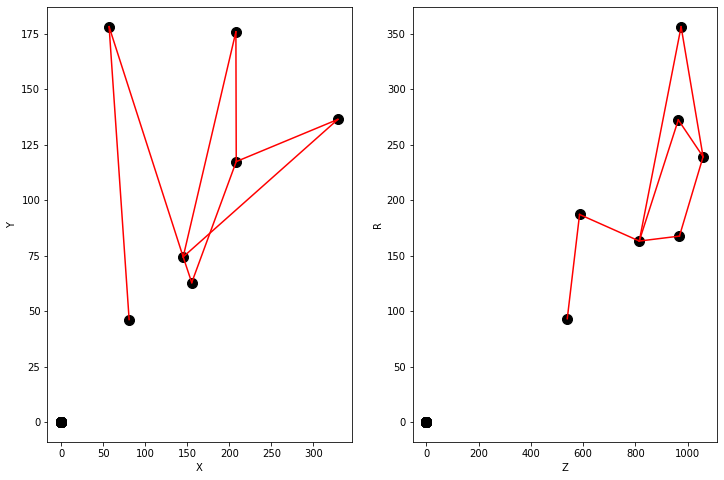

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00030546 0.00021877 0.00017531 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


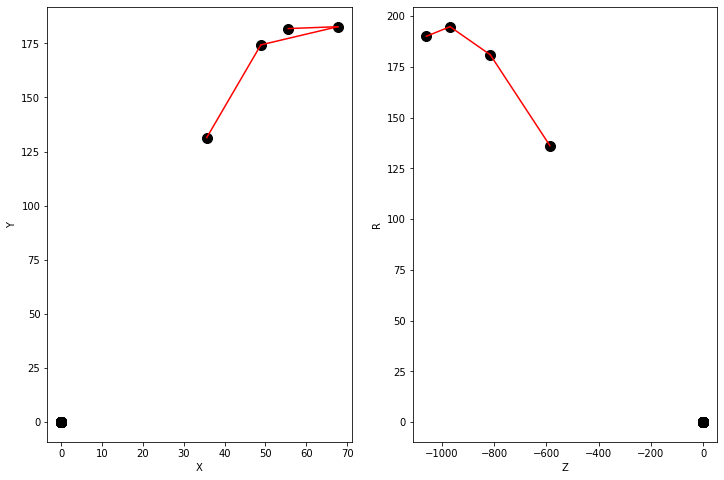

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.11226731 0.09342857 0.07469065 0.24856448 0.25977582 0.2682848
 0.3159045  0.41705883 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.984, precision 0.000, recall 0.000


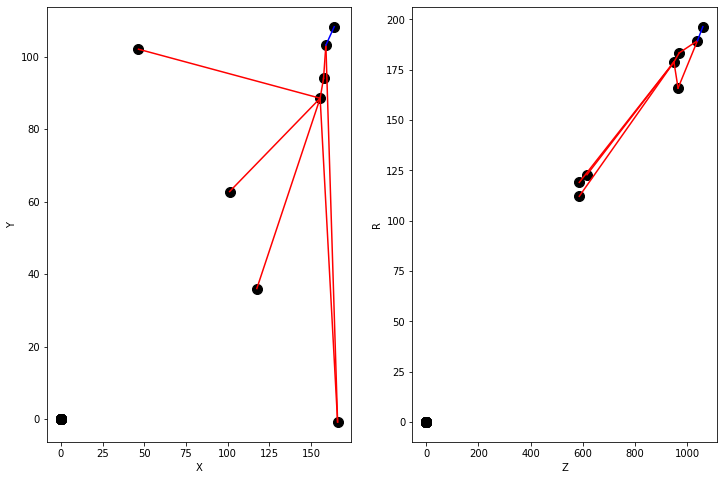

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.05819319 0.05724671 0.04886746 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


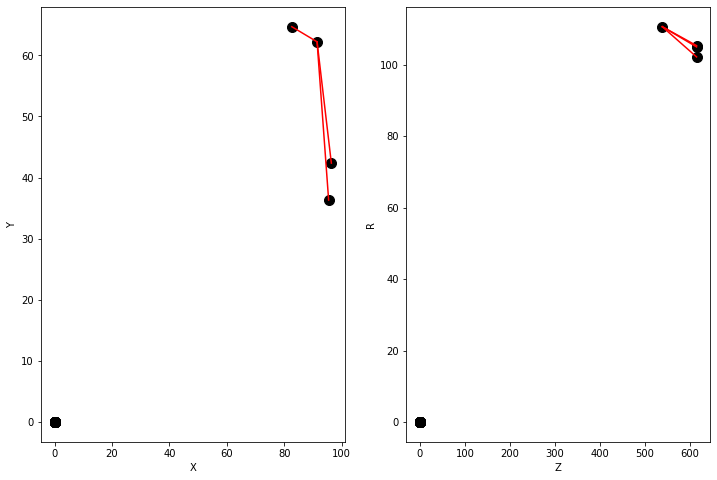

Y = [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.6680266  0.6482416  0.60228884 0.57592666 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 1.000, recall 1.000


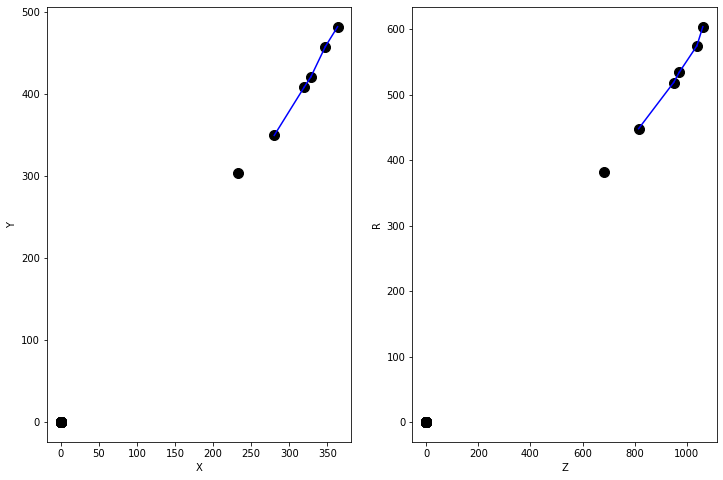

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.04693714 0.05831145 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


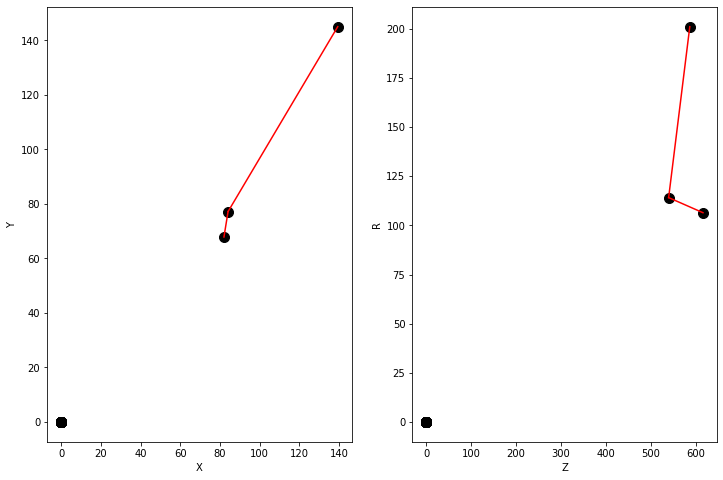

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00028198 0.00028102 0.00021549 0.00019787 0.00018806 0.00017965
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


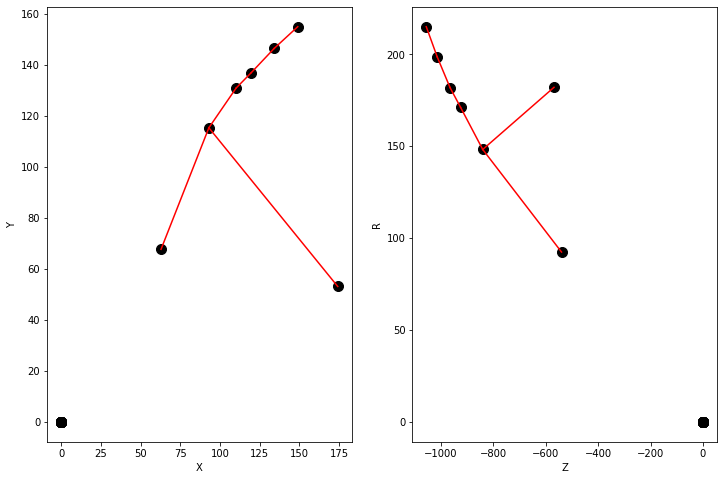

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.42196184 0.34895745 0.3331137  0.33405817 0.24579449 0.22547396
 0.24197058 0.2219094  0.31624034 0.2812398  0.33790696 0.30358014
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.984, precision 0.000, recall 0.000


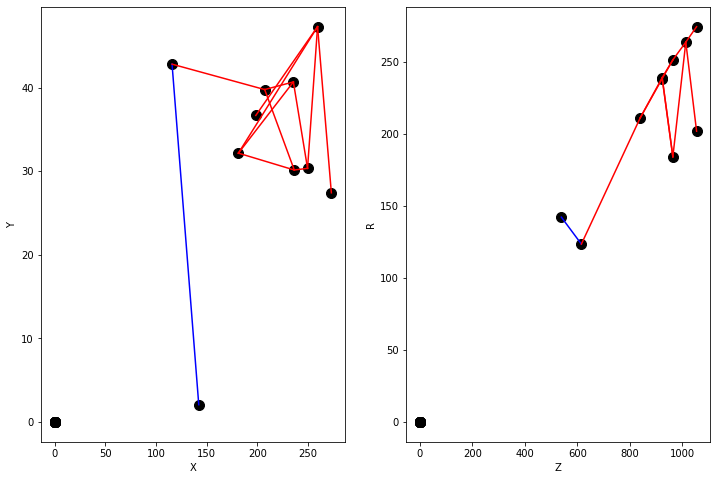

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00022957 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


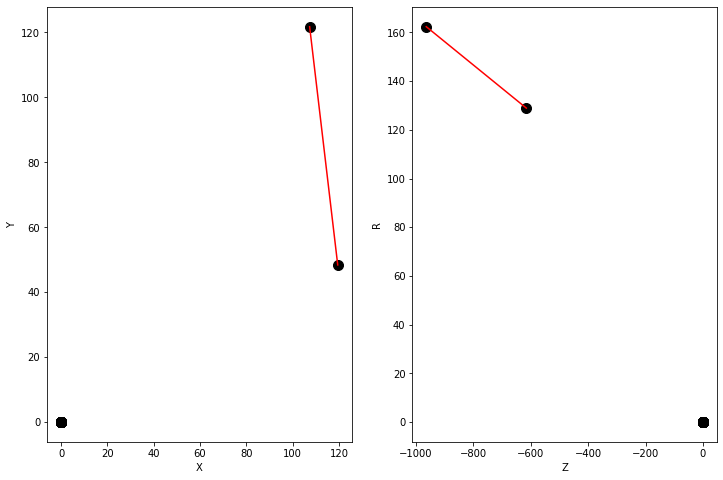

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.34069577 0.3481542  0.33591577 0.21843494 0.21182327 0.20524299
 0.19890173 0.31670925 0.30413195 0.42985806 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.984, precision 0.000, recall 0.000


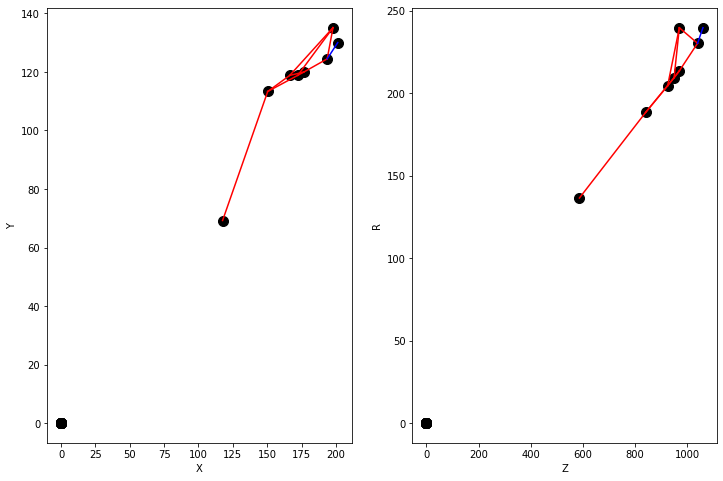

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00020731 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


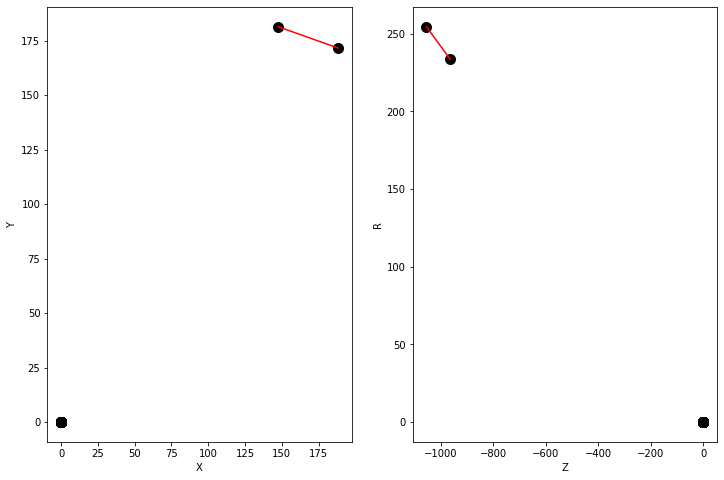

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00024734 0.00024587 0.00035596 0.00017639 0.00017675 0.00017295
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


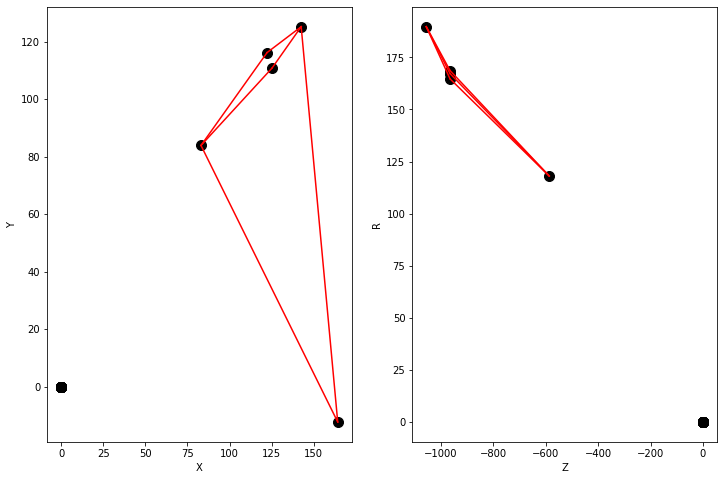

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.2820111  0.31345016 0.23908268 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


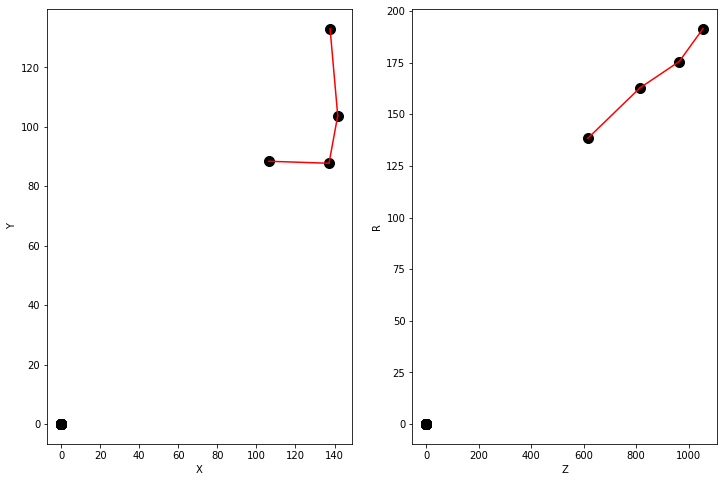

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00023599 0.00023741 0.00023684 0.00023822 0.00021926 0.00022279
 0.00017601 0.00017336 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


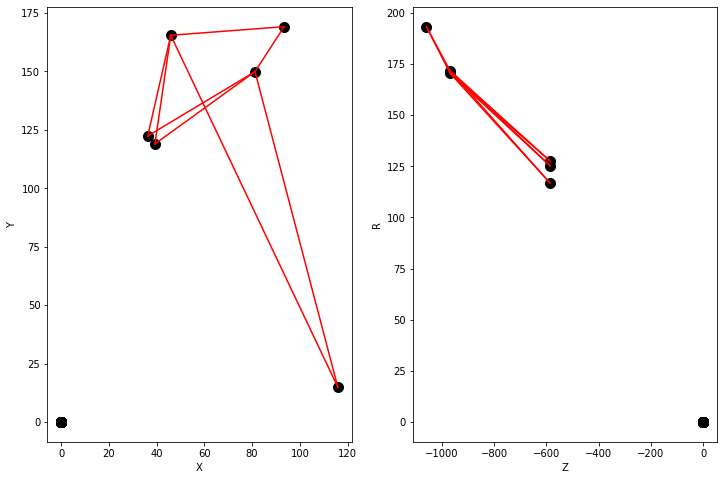

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00029956 0.00030459 0.00030854 0.00023432 0.00019907 0.00018734
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


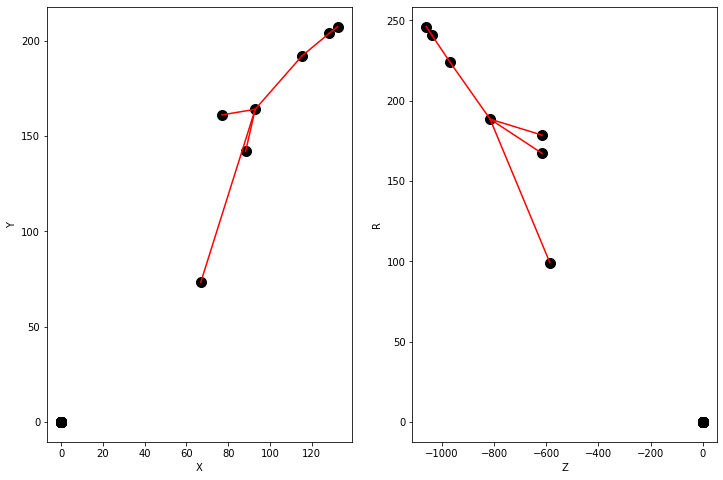

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00062356 0.00049727 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


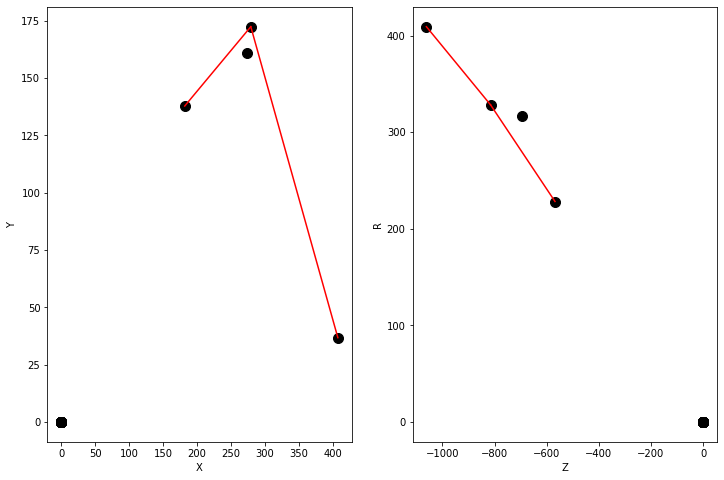

Y = [1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.12927225 0.13519171 0.11920555 0.10854309 0.10726707 0.60298693
 0.5124941  0.4975604  0.4199488  0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.967, precision 1.000, recall 0.667


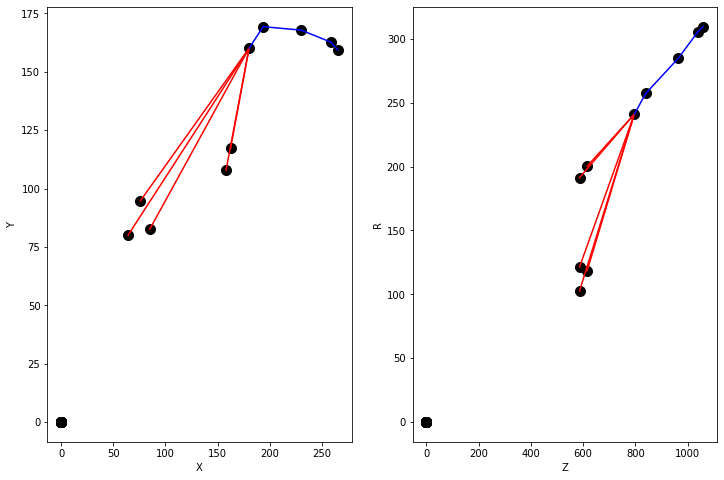

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00038642 0.00027173 0.00023981 0.00021873 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


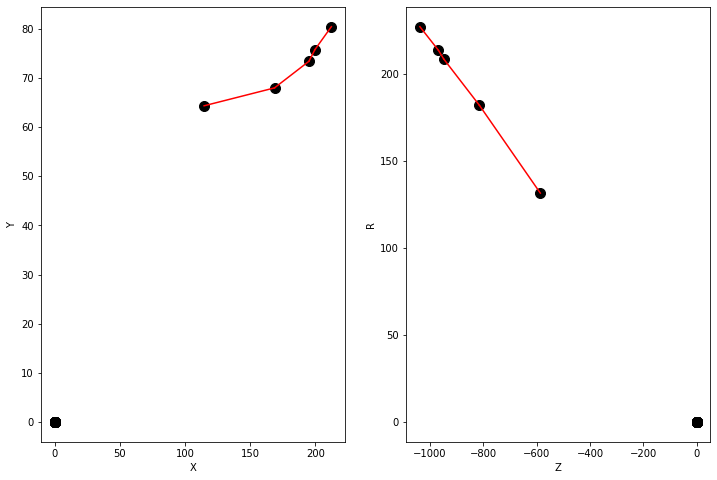

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.08177831 0.1166441  0.09871545 0.23292093 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


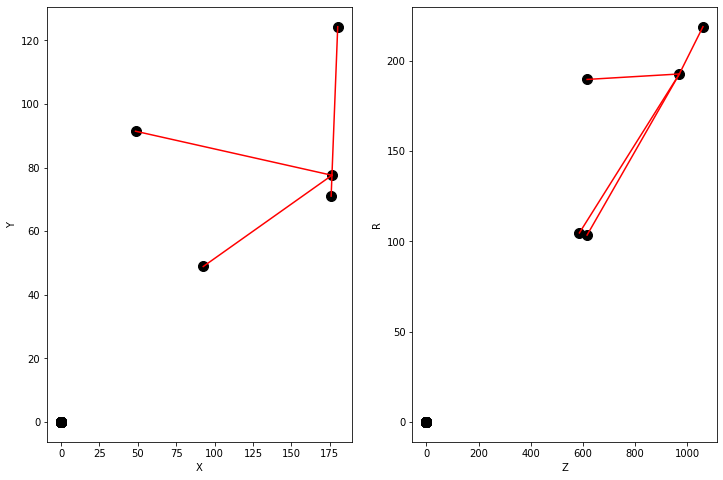

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.03864785 0.02965342 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


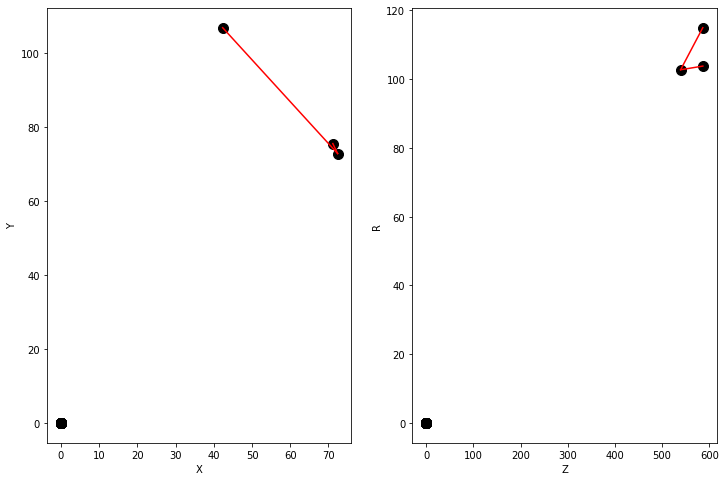

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.05251036 0.04021106 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


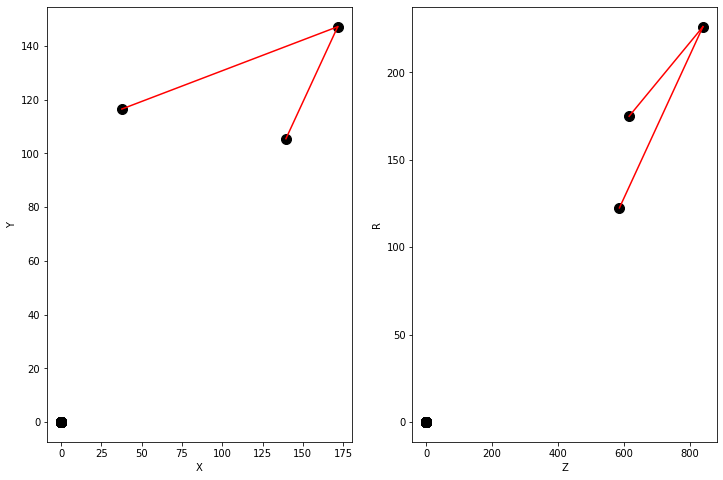

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.28546643 0.32254928 0.50924    0.4115805  0.23502952 0.21068317
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.967, precision 0.000, recall 0.000


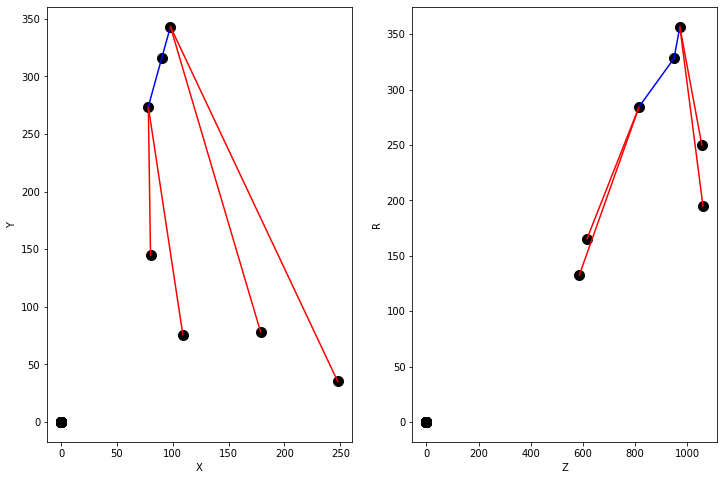

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.09750743 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


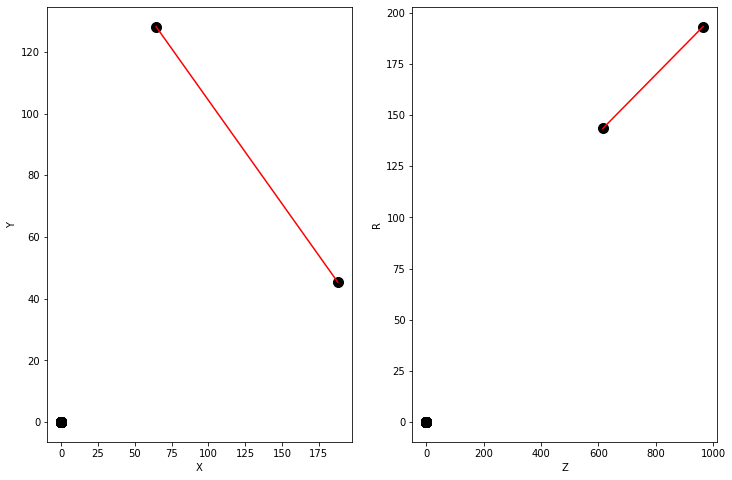

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.21922265 0.15236028 0.17164336 0.19355166 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


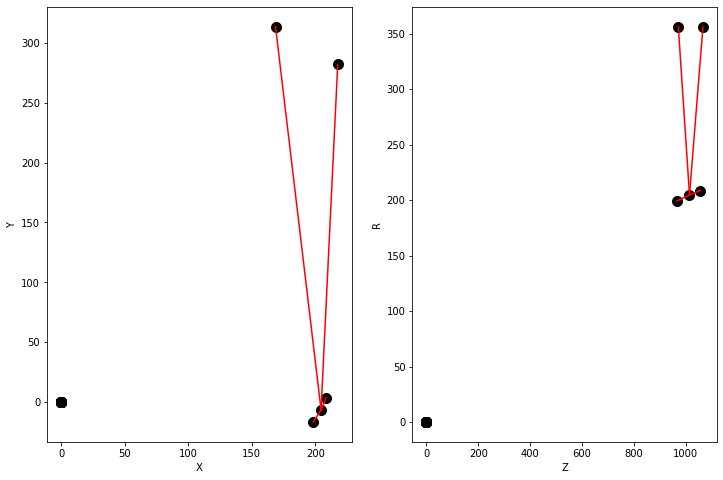

Y = [1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.43980935 0.6013793  0.7218025  0.7231489  0.61966807 0.552135
 0.4547138  0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 1.000, recall 1.000


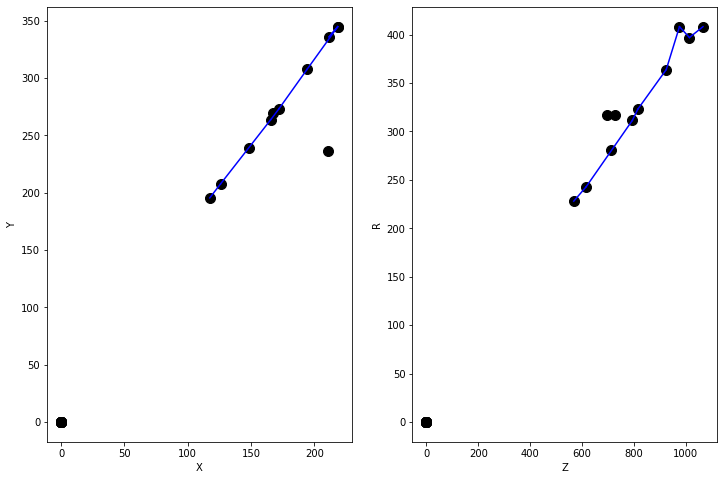

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.44032732 0.44166893 0.42657518 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.951, precision 0.000, recall 0.000


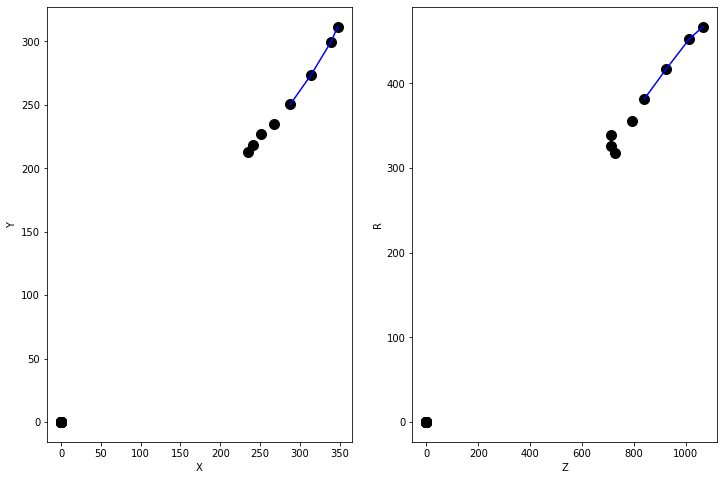

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.24493524 0.17173888 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


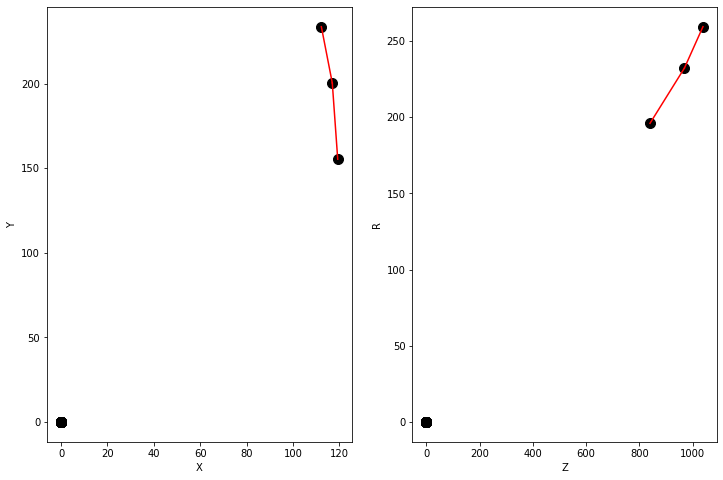

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.0007182  0.00058835 0.00047653 0.00040536 0.0002632  0.00032116
 0.00030281 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


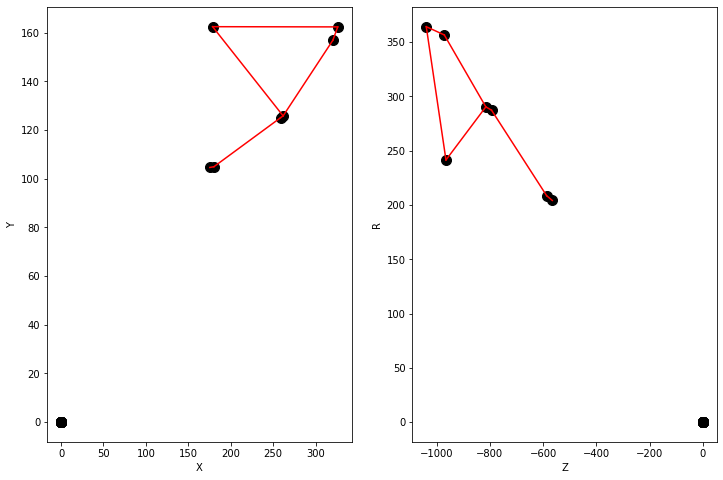

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00053036 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


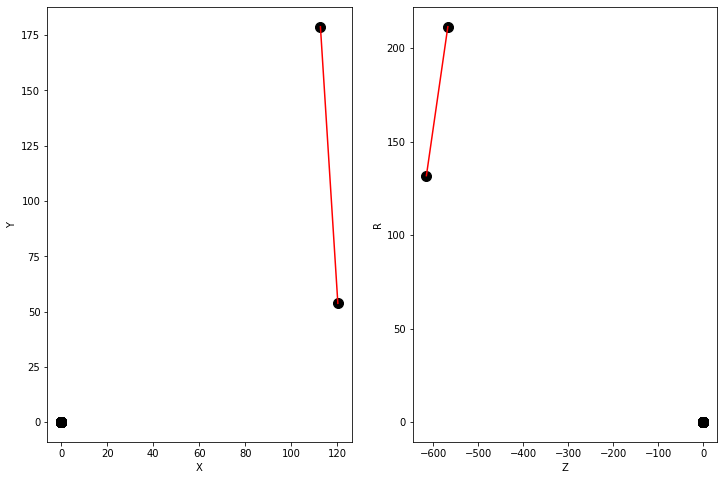

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00029936 0.00022044 0.0002211  0.0002051  0.00020544 0.00019358
 0.00018009 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


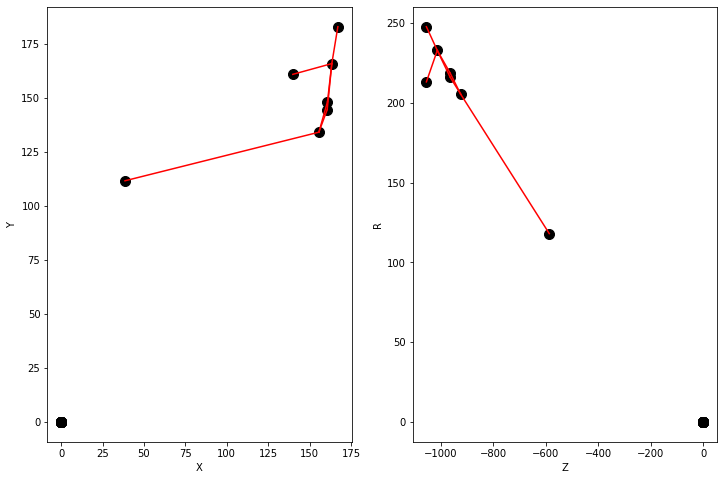

Y = [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.30634362 0.22227402 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.967, precision 0.000, recall 0.000


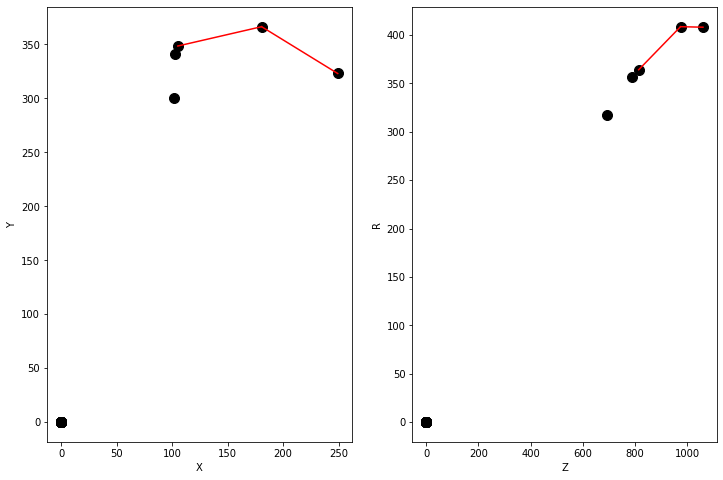

Y = [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.40452522 0.40525752 0.46139085 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 1.000, recall 1.000


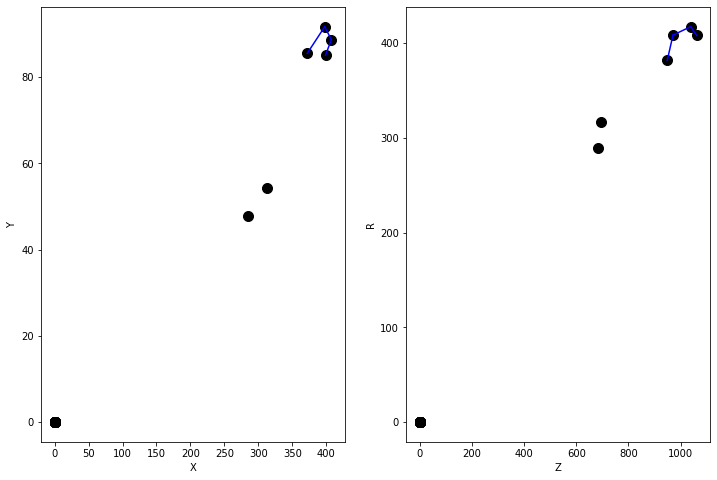

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.37819526 0.37010956 0.28691813 0.3354916  0.20172825 0.26894495
 0.23496325 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


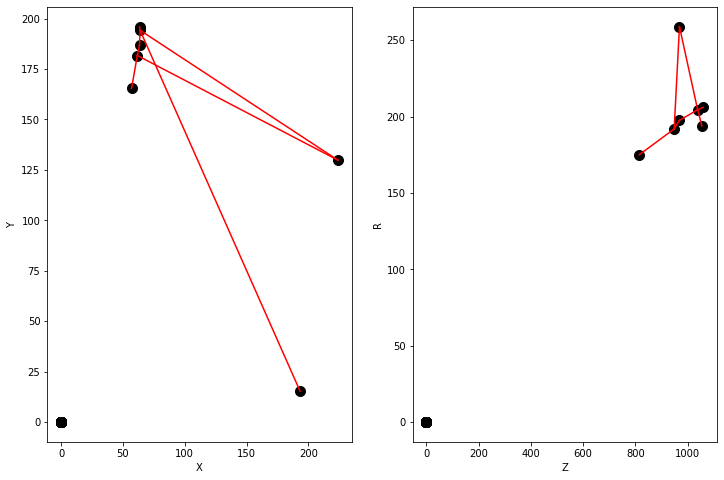

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00045619 0.00035428 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


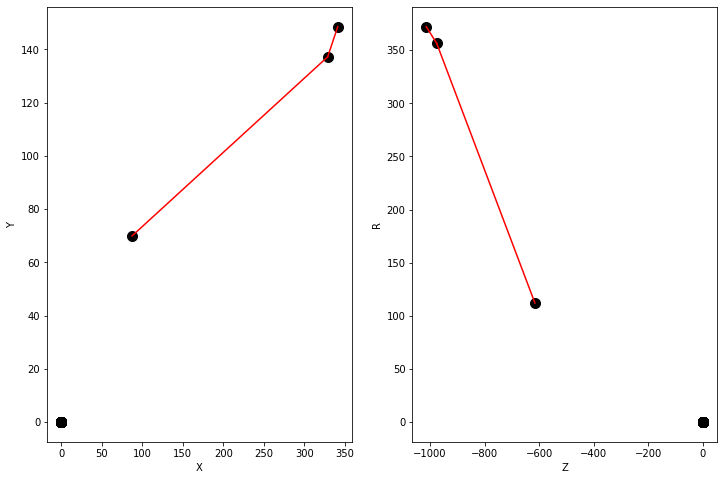

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00039126 0.00039155 0.00039778 0.00028959 0.00025752 0.00023468
 0.00021715 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


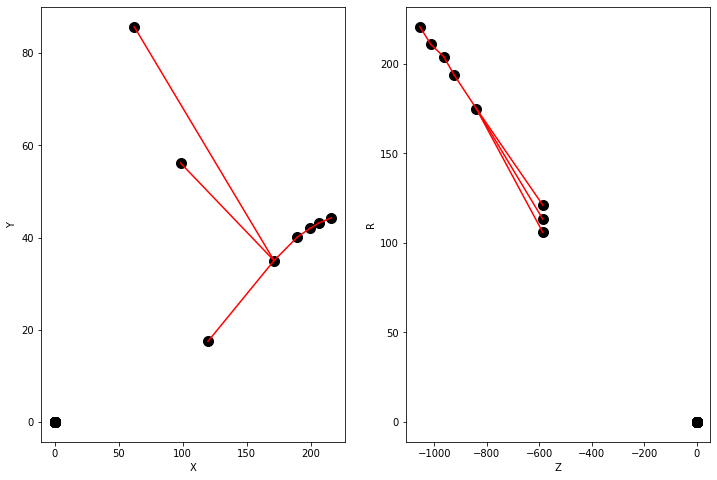

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.17959398 0.15382256 0.11804035 0.18334718 0.13728842 0.11698034
 0.09166051 0.13855524 0.12449703 0.11425795 0.09466041 0.13910045
 0.34452134 0.33134753 0.28068736 0.35812882 0.28058702 0.46304232
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.984, precision 0.000, recall 0.000


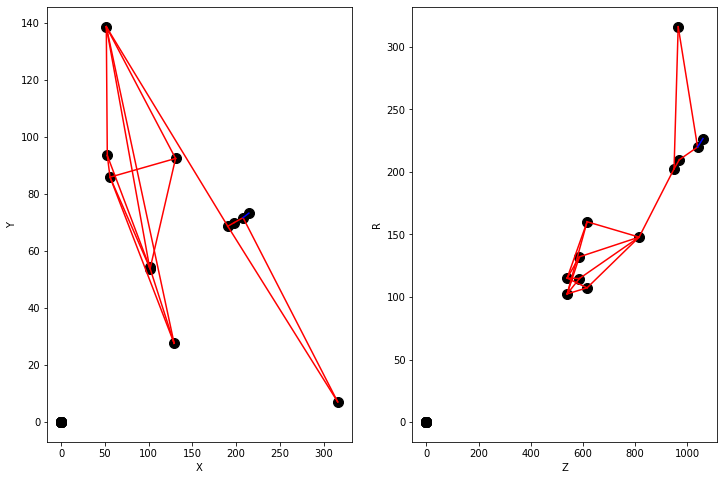

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.0004725  0.00033612 0.00029424 0.00026897 0.00025172 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


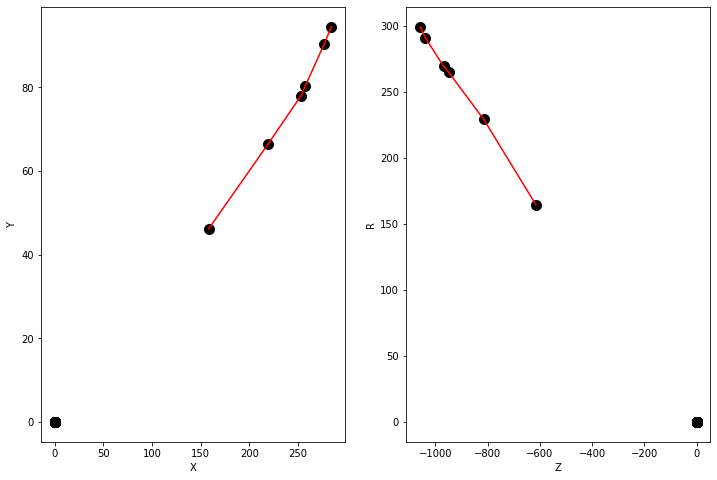

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.12435022 0.13140076 0.21417685 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


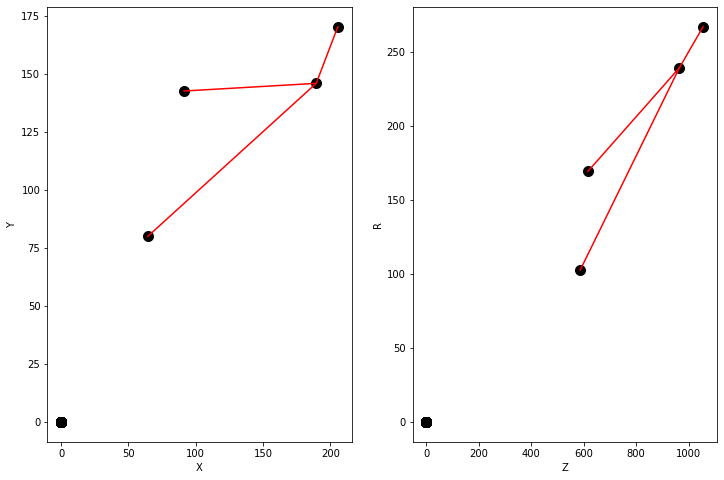

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00059269 0.0005932  0.00048039 0.00048078 0.00041468 0.00033611
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


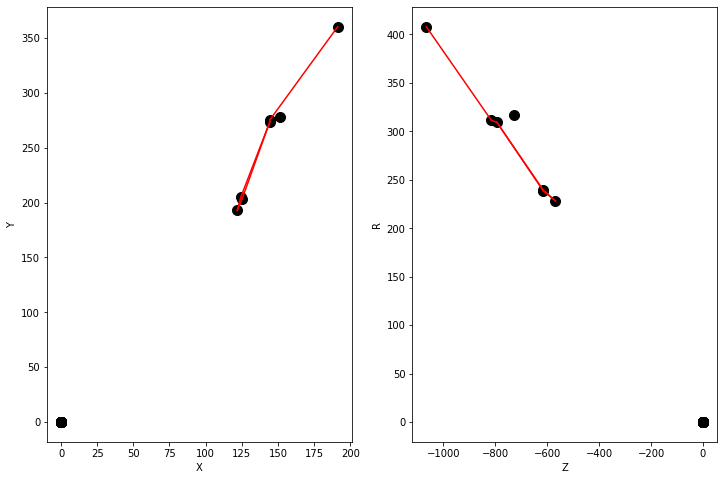

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00037886 0.00034896 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


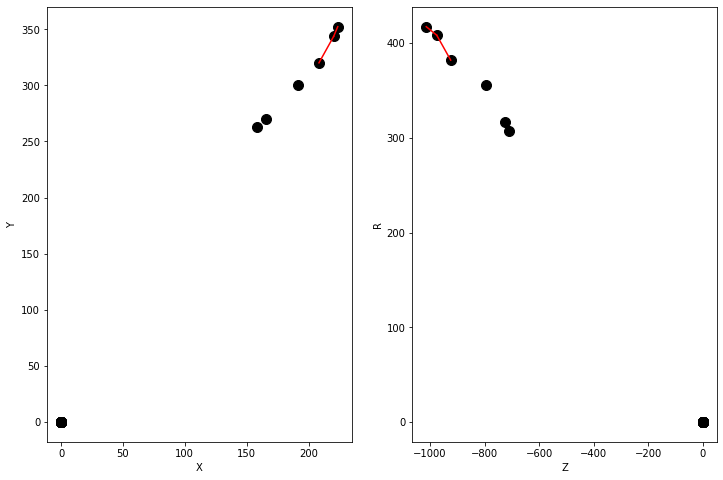

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.2715871  0.17316207 0.16723032 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


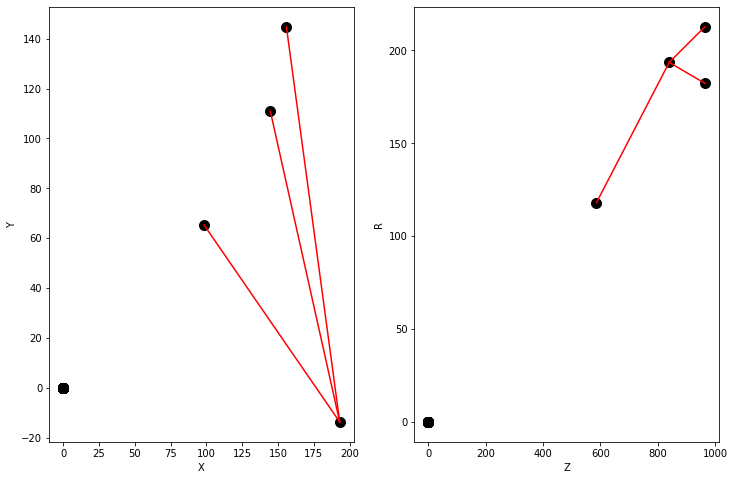

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00056371 0.00057852 0.00058771 0.00060598 0.00036777 0.00036796
 0.00027792 0.00019814 0.00020504 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


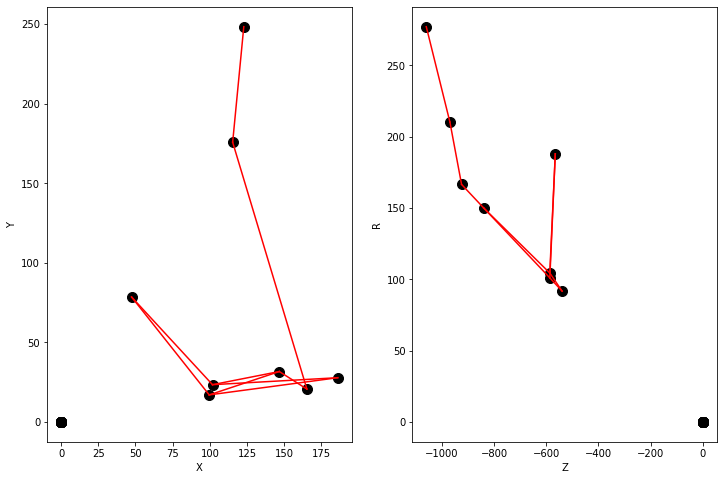

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00046443 0.00031268 0.00023155 0.00020129 0.00019159 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


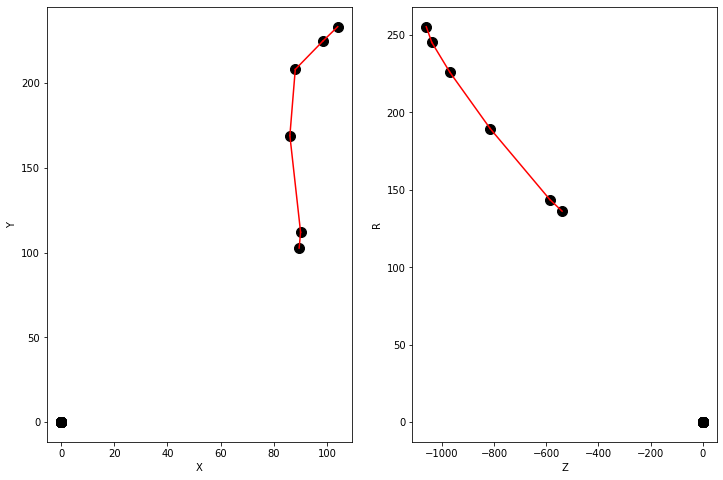

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00045874 0.00072629 0.00077991 0.00078399 0.00025093 0.00024428
 0.00024925 0.00024881 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


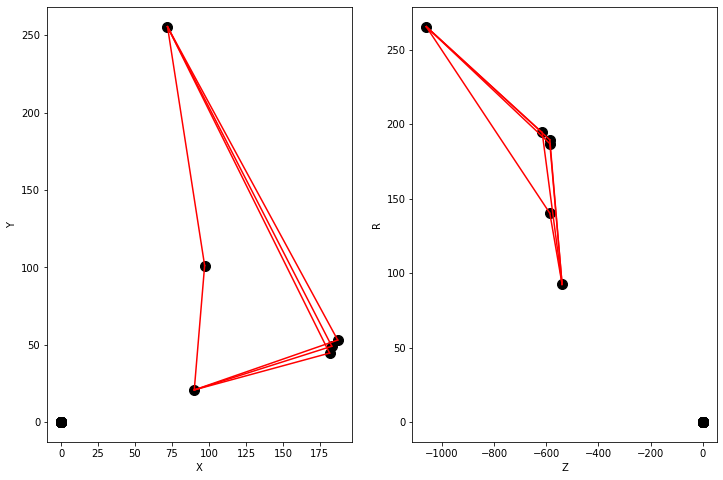

Y = [1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.19771363 0.19841246 0.2316887  0.1974751  0.19817261 0.2313846
 0.248691   0.249698   0.32117504 0.8127787  0.76308084 0.45170635
 0.4012416  0.42025223 0.37973276 0.3230423  0.26953956 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.869, precision 0.600, recall 0.333


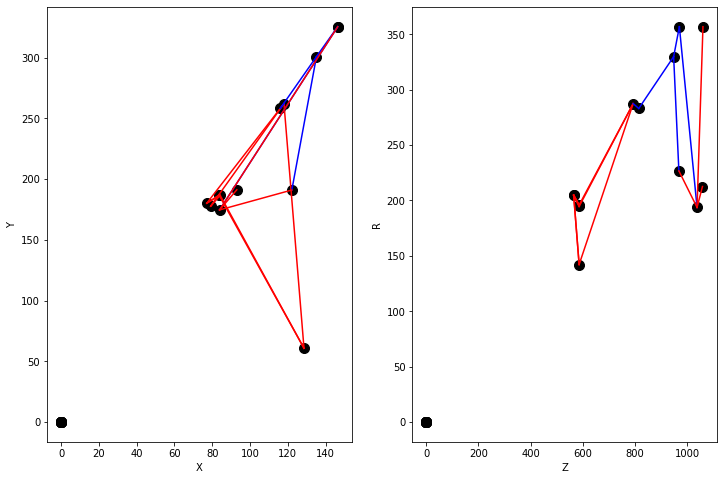

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.4029089  0.48413417 0.44260812 0.4034211  0.30876043 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.934, precision 0.000, recall 0.000


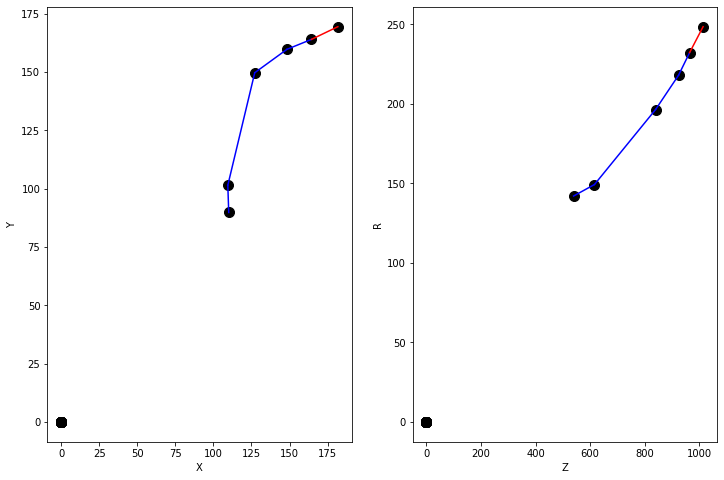

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00040977 0.00039927 0.00038382 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


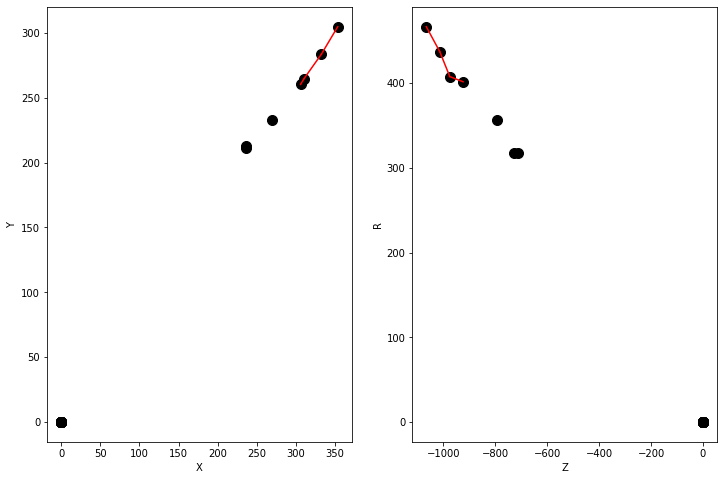

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.000304   0.00030465 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


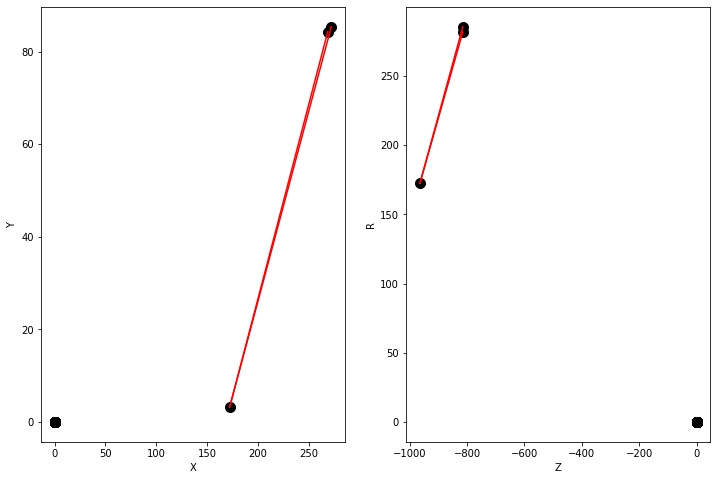

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00035293 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


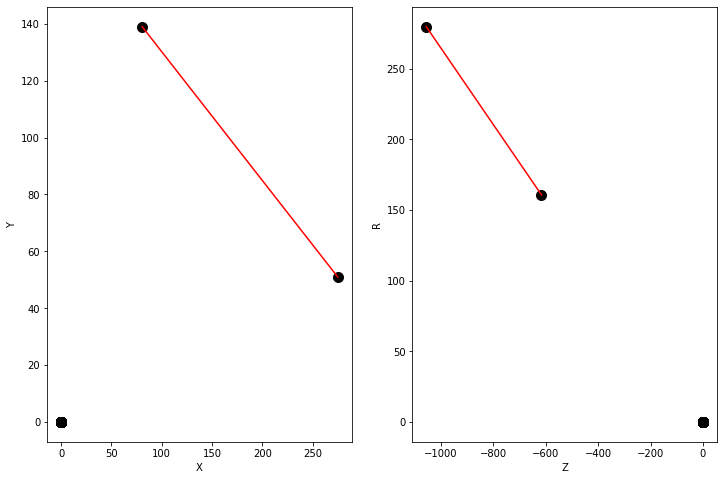

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00038176 0.00062612 0.00027754 0.00027279 0.00021228 0.00021871
 0.00019095 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


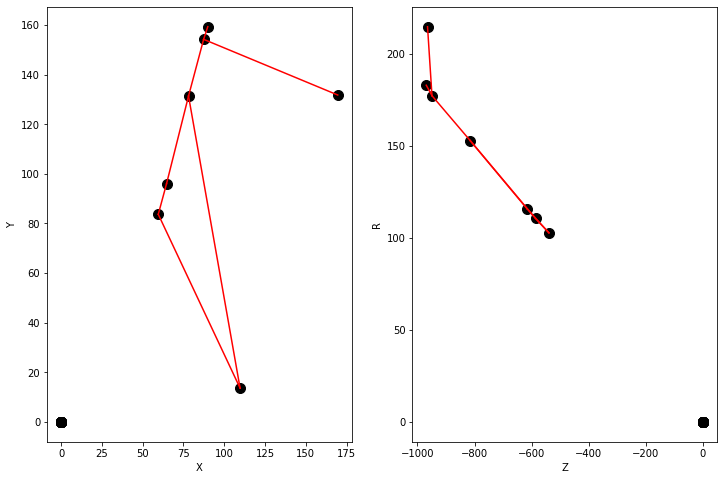

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00057497 0.00044204 0.00044354 0.00046563 0.00037237 0.00063444
 0.00058624 0.000645   0.00029134 0.0003133  0.00031371 0.00034054
 0.00031551 0.00034268 0.00030216 0.00032657 0.00029552 0.00031991
 0.00029494 0.00031727 0.00029035 0.00031199 0.00029389 0.00031588
 0.00024601 0.00025913 0.0002591  0.00027376 0.00021594 0.00023043
 0.00023322 0.00022008 0.00023583 0.0002387  0.00019933 0.00020617
 0.00020665 0.00020553 0.00018401 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


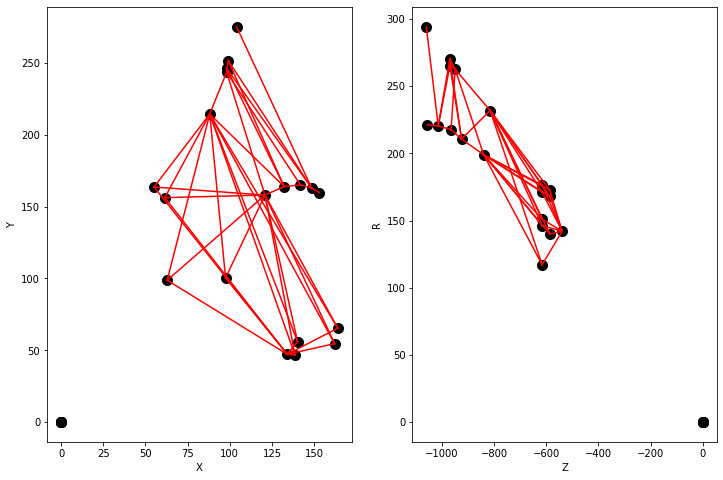

Y = [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.42905447 0.3414271  0.3654144  0.36155286 0.32884422 0.32631096
 0.32334226 0.20028386 0.2208962  0.15558778 0.1722181  0.50784177
 0.43582743 0.44354412 0.36051533 0.5504167  0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.918, precision 0.200, recall 0.500


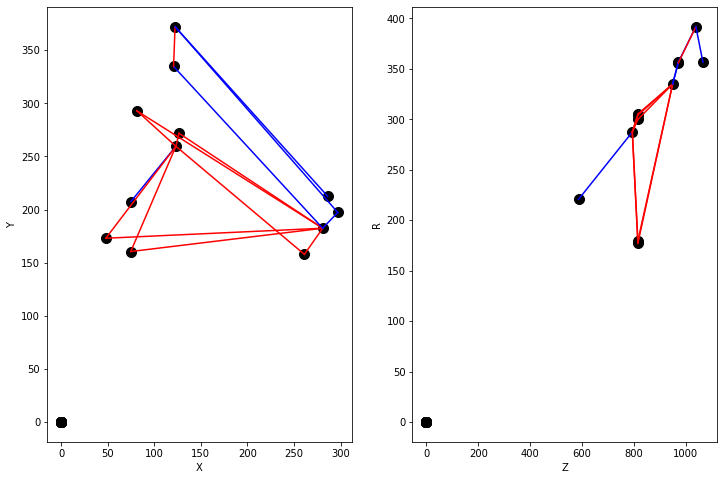

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.26827505 0.18043362 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


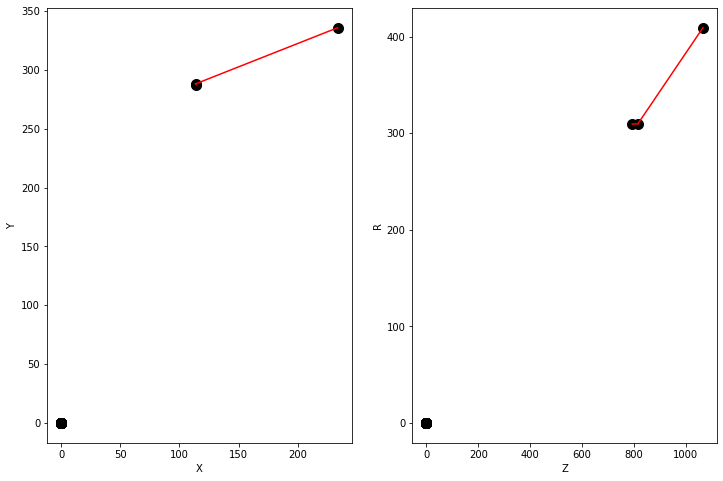

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.14481422 0.10190913 0.12354342 0.12611611 0.12710403 0.13748989
 0.13401704 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


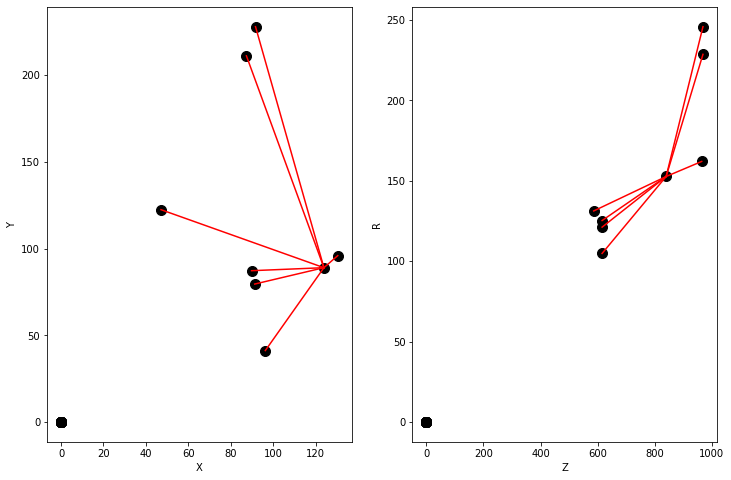

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.1184462  0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


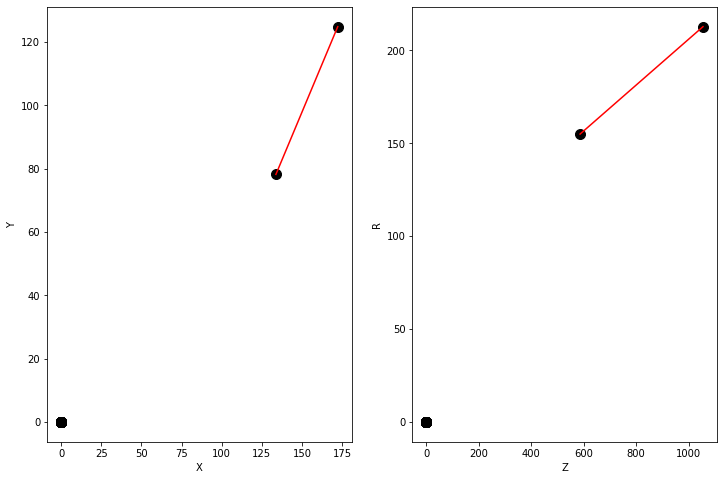

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00063271 0.00037478 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


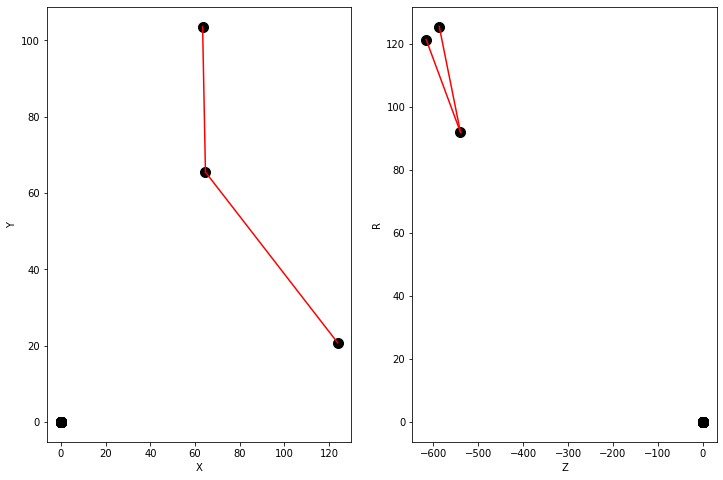

Y = [0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.3980566  0.4948413  0.46877956 0.47803894 0.29293624 0.31417435
 0.3540691  0.36822665 0.30188468 0.33117542 0.37364346 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.934, precision 0.667, recall 0.400


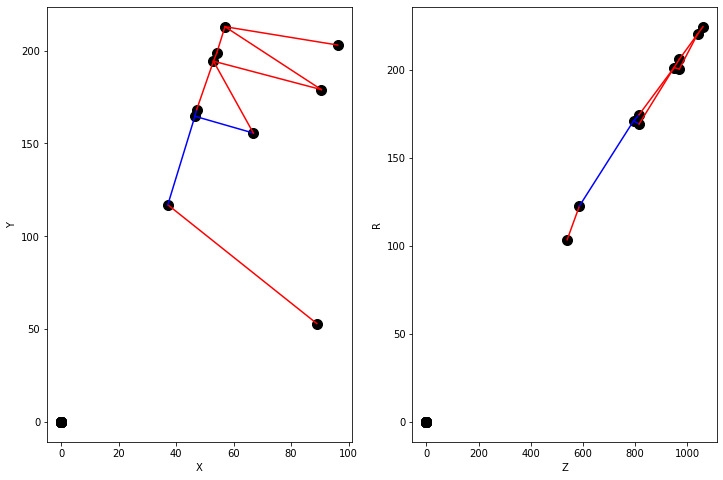

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.1686002  0.16055904 0.15128887 0.4670894  0.45292497 0.37779406
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.967, precision 0.000, recall 0.000


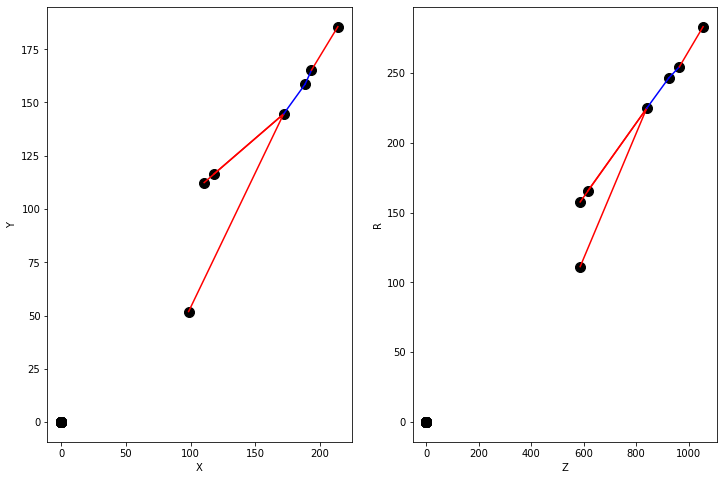

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.09070141 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


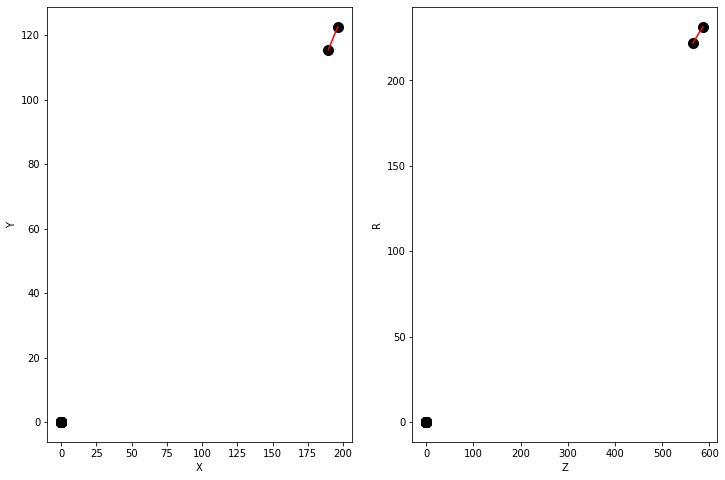

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.05388429 0.04160289 0.05374302 0.04150232 0.03967188 0.0314007
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


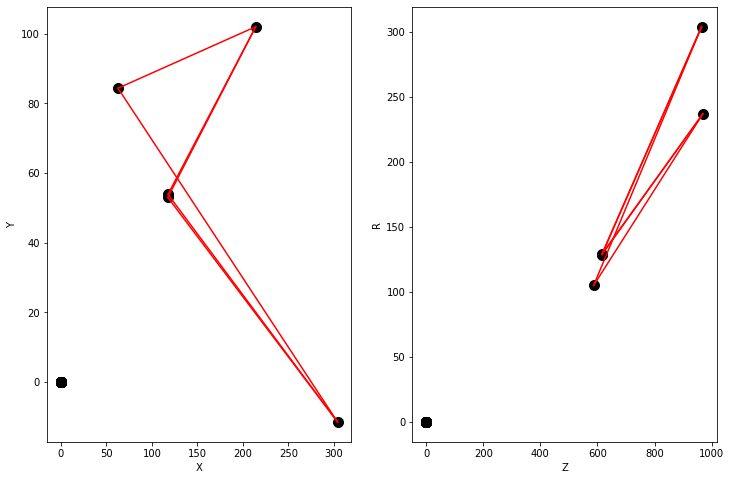

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00028932 0.00028256 0.00026277 0.00024505 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


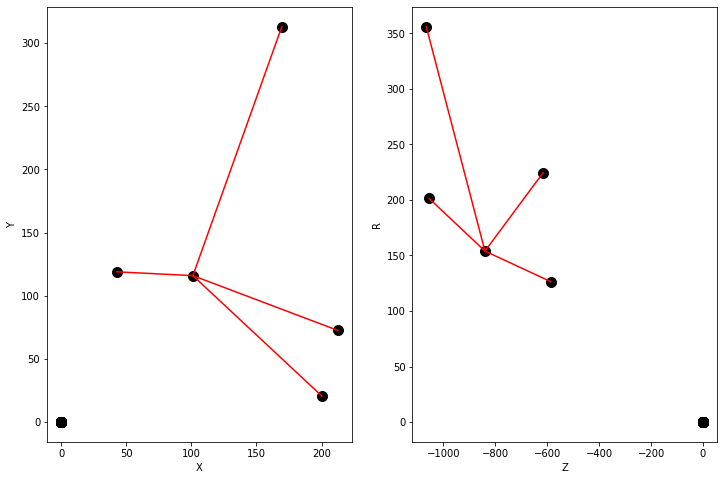

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00037787 0.00065714 0.00037586 0.0006605  0.0002965  0.000287
 0.00027798 0.00026928 0.00038873 0.00029673 0.00028486 0.0002778
 0.00026694 0.00040712 0.00022721 0.00028911 0.00022918 0.00029015
 0.00022465 0.00028545 0.00022661 0.00028652 0.00022238 0.00029037
 0.00020887 0.00019422 0.00026182 0.00020487 0.0001897  0.00026349
 0.00018349 0.00023182 0.00018273 0.00022956 0.00017968 0.00023314
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


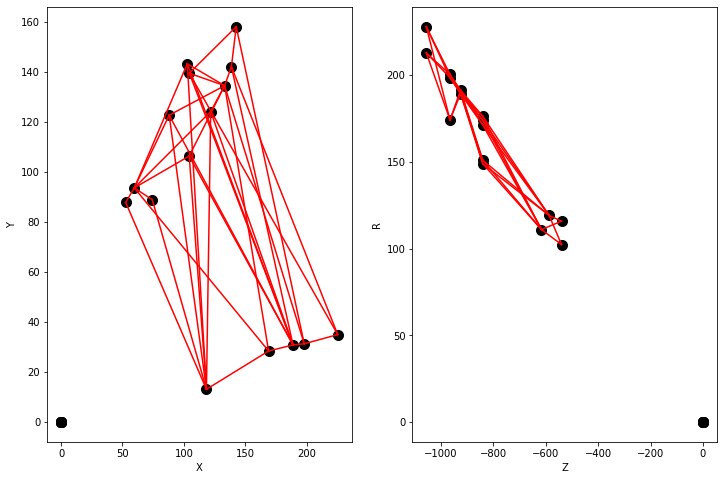

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.124977   0.12875184 0.12328156 0.12712146 0.20403665 0.16508421
 0.29057184 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


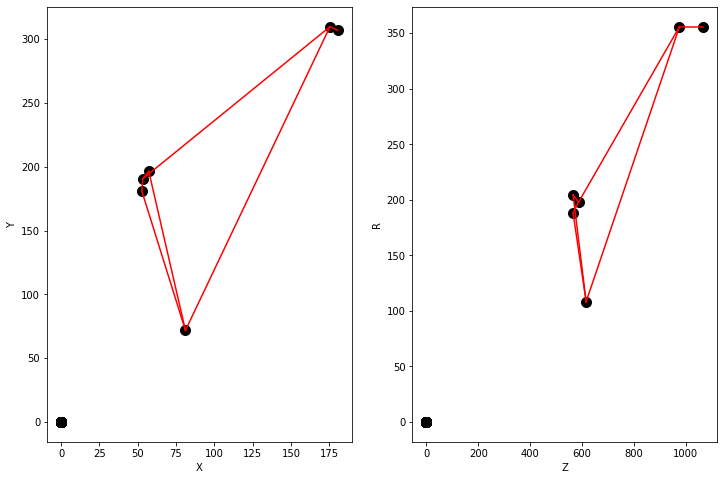

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00063715 0.00064421 0.00027326 0.00027035 0.00045326 0.00021634
 0.00045209 0.00021594 0.00019514 0.00018294 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


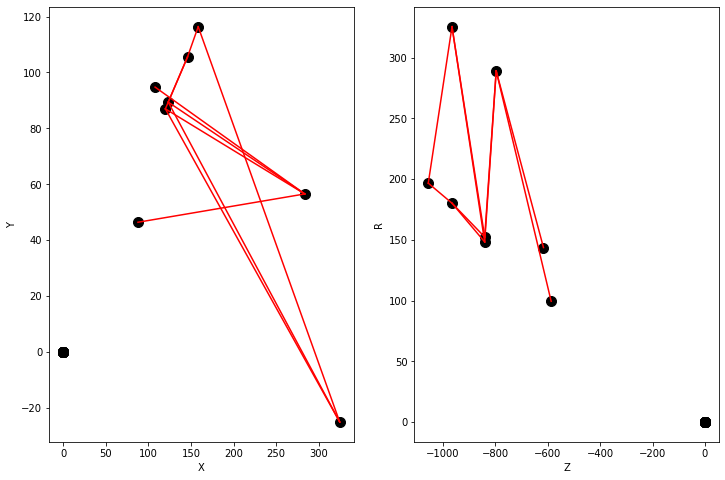

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00024492 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


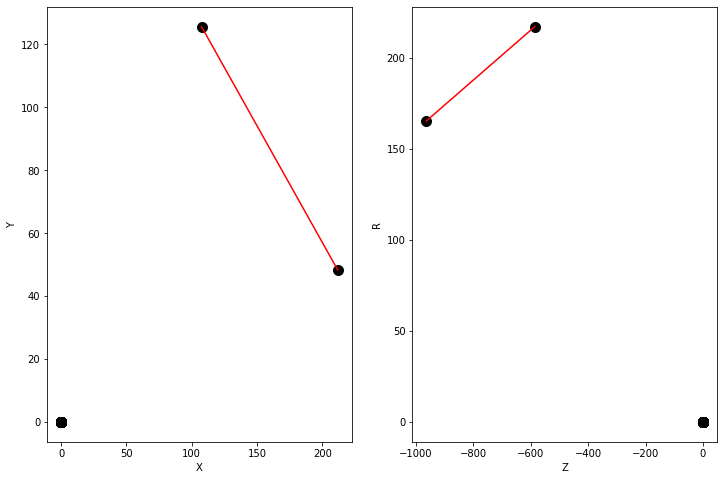

Y = [1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.34773397 0.39902878 0.26954275 0.34633136 0.44024825 0.48644438
 0.23058526 0.21141817 0.29091853 0.26410708 0.288191   0.24304247
 0.20214671 0.1746067  0.26742774 0.23084465 0.18891999 0.16813233
 0.22681378 0.2640781  0.18179731 0.2092155  0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.885, precision 0.500, recall 0.143


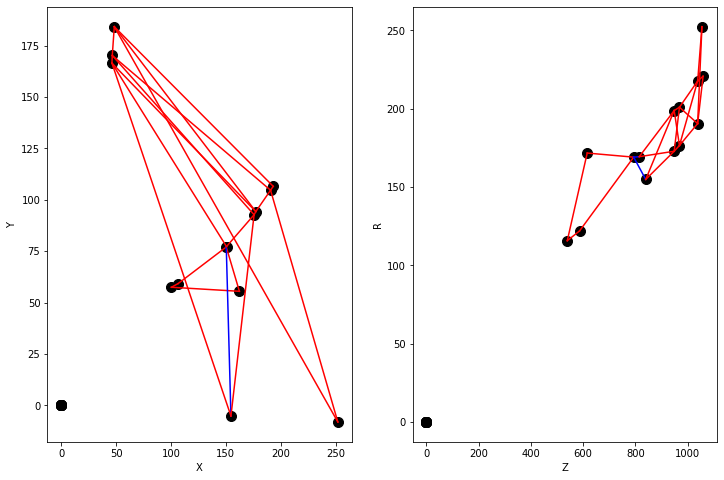

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.0566668  0.04563921 0.04415776 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


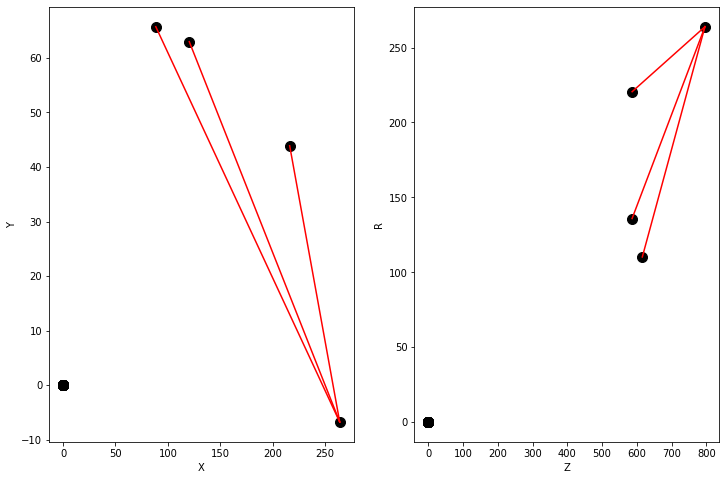

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00034548 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


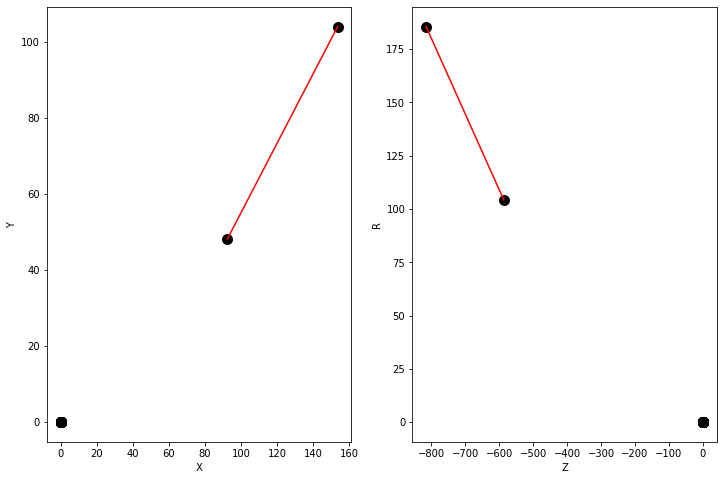

Y = [0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.15278083 0.18750088 0.4756168  0.4634593  0.42544952 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 1.000, recall 1.000


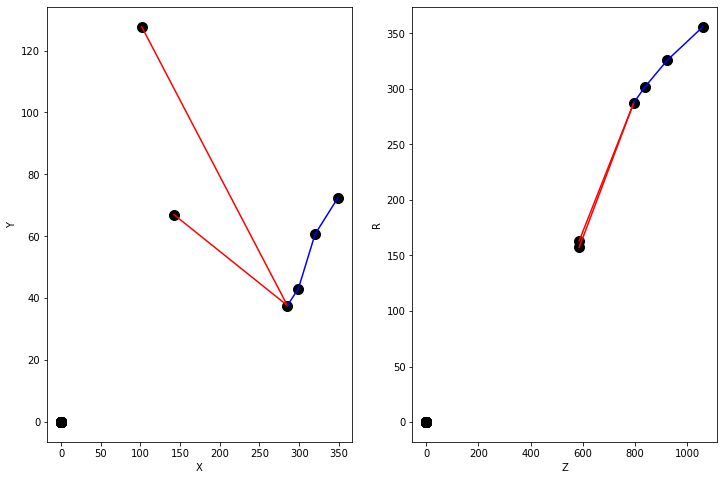

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.1639029  0.1054616  0.10444795 0.4485665  0.44552872 0.39505833
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.967, precision 0.000, recall 0.000


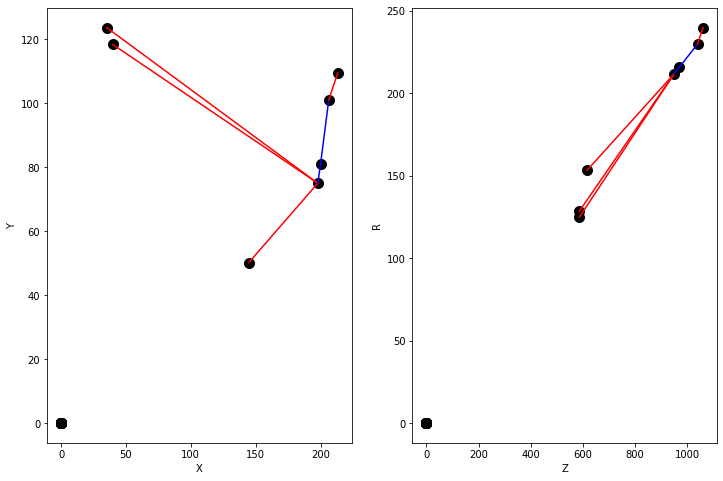

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00077236 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


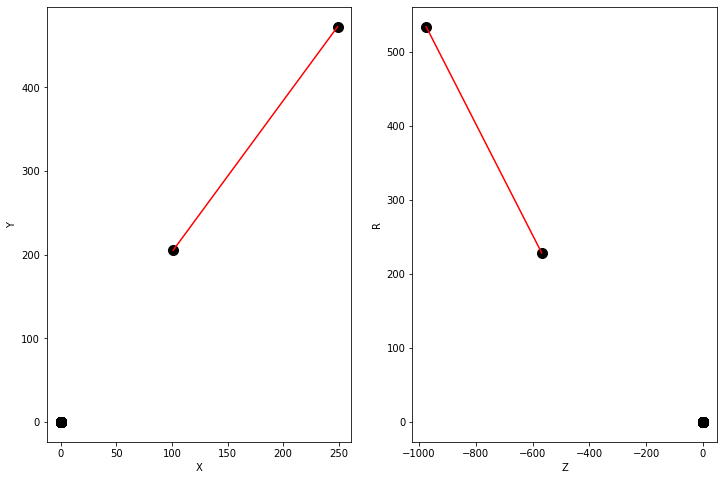

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.0005145  0.00033716 0.00030992 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


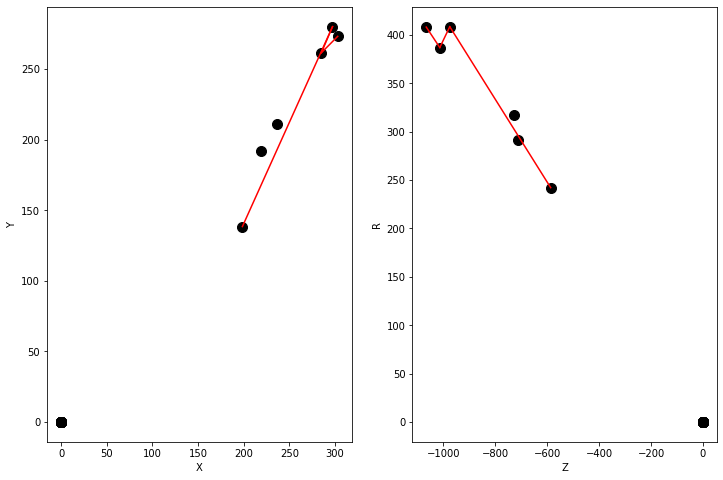

Y = [1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.45108774 0.6420192  0.3488087  0.36834234 0.37692326 0.2346778
 0.17845759 0.1953673  0.55338806 0.4563082  0.42214215 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.967, precision 0.800, recall 0.800


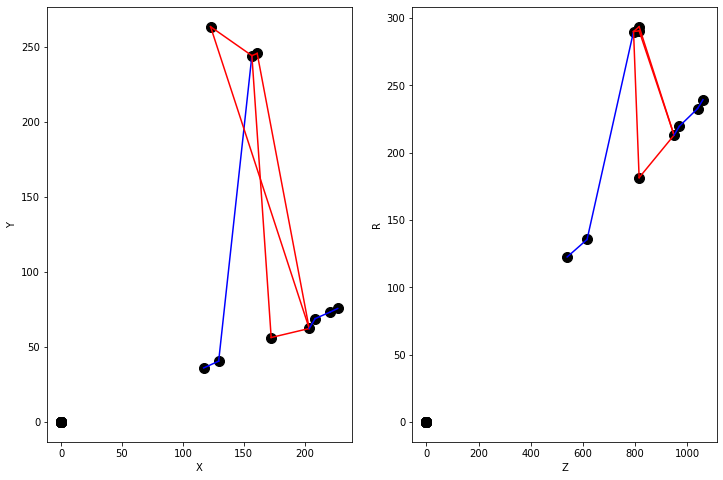

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.34911472 0.20625237 0.20162636 0.12606244 0.15290737 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


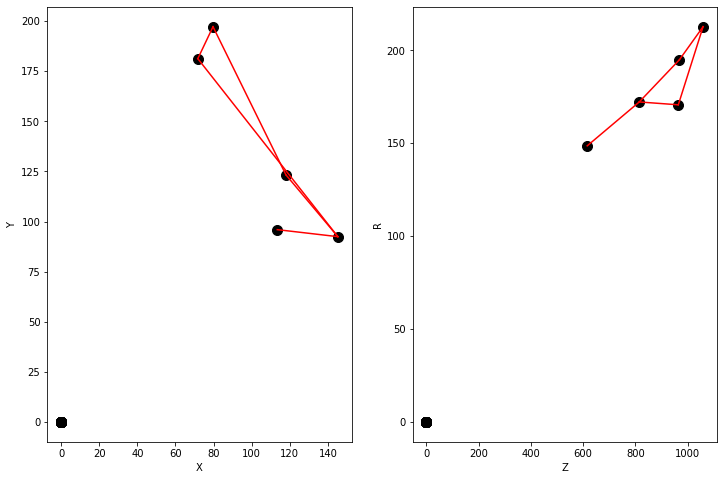

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.42361936 0.53426445 0.49559668 0.4613326  0.37741372 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.934, precision 0.000, recall 0.000


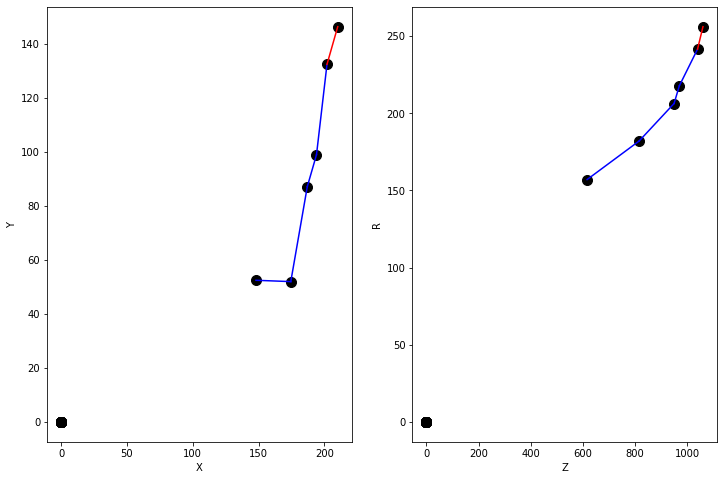

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.35624248 0.2700639  0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


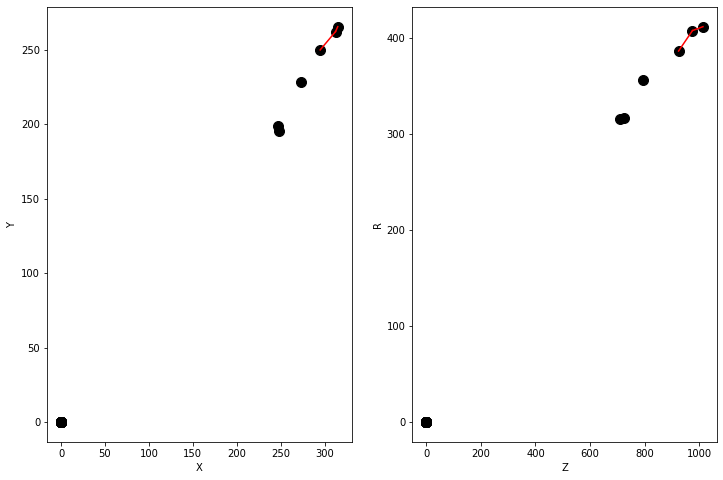

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.26369622 0.25539127 0.21964201 0.20363384 0.43875483 0.43033725
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.967, precision 0.000, recall 0.000


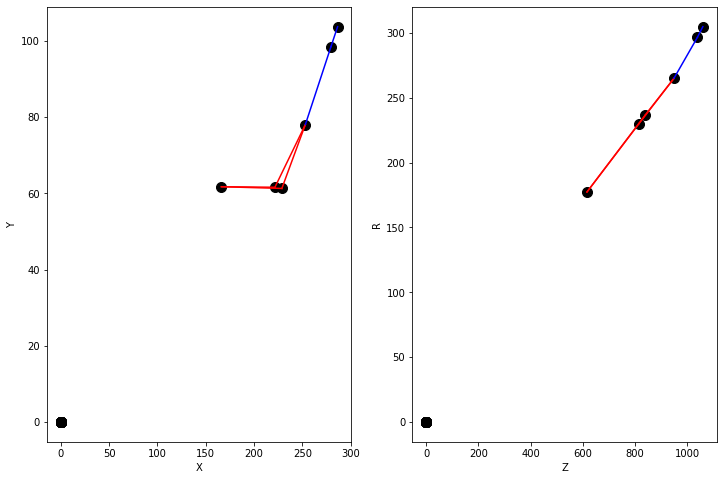

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00038485 0.0002761  0.00037304 0.00038468 0.0002757  0.00037288
 0.00039729 0.00028085 0.00038499 0.00027807 0.0002881  0.00026833
 0.00027777 0.0002726  0.00028235 0.00019324 0.00019323 0.00024737
 0.00019645 0.00019643 0.00025224 0.00021773 0.00022435 0.00021806
 0.00022469 0.00022139 0.00022825 0.00019441 0.00020683 0.00017043
 0.00019776 0.00021054 0.00017304 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


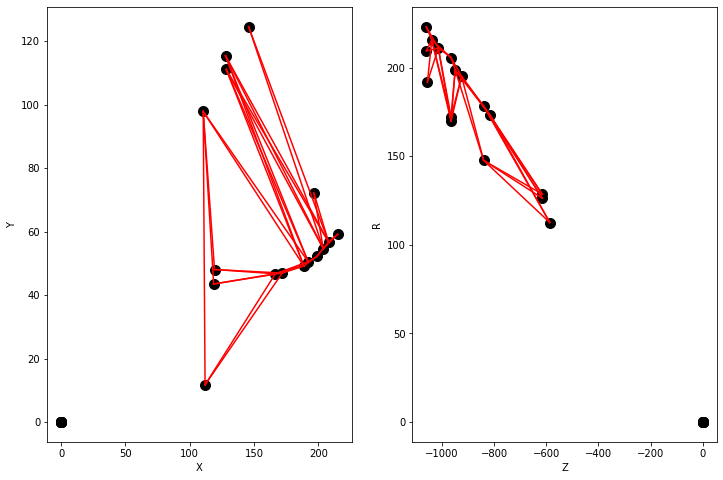

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.2398933  0.13320647 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


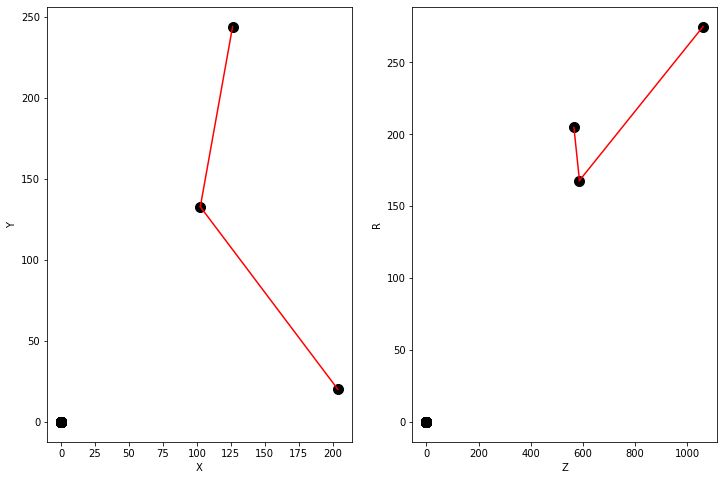

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.16933136 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


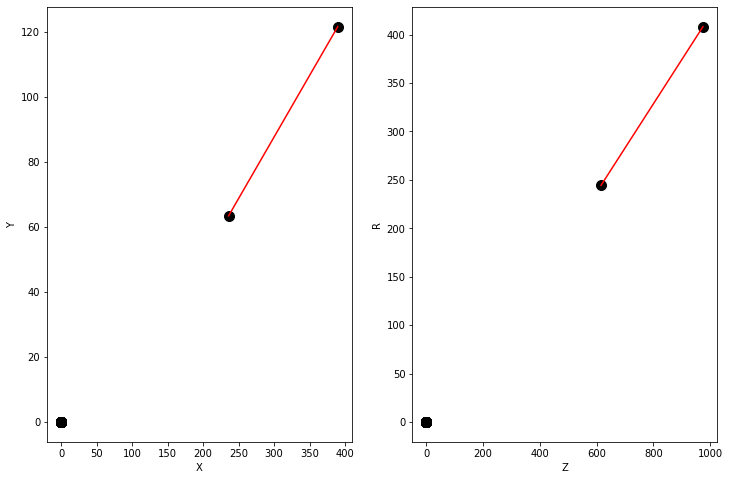

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00078696 0.00069552 0.00046639 0.00045736 0.00019128 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


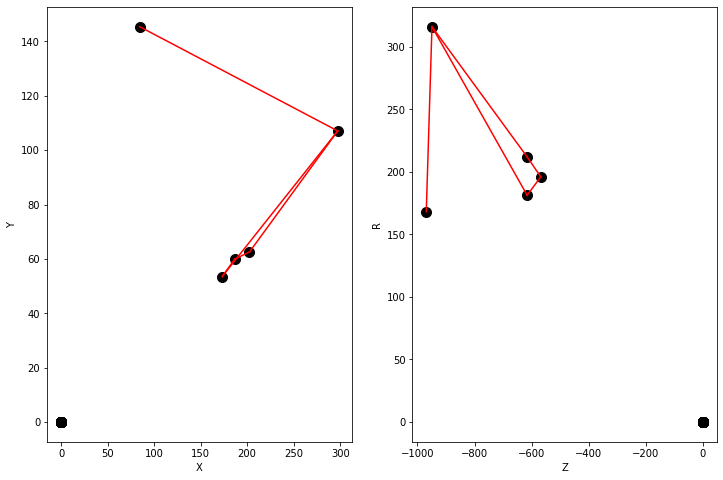

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00035522 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


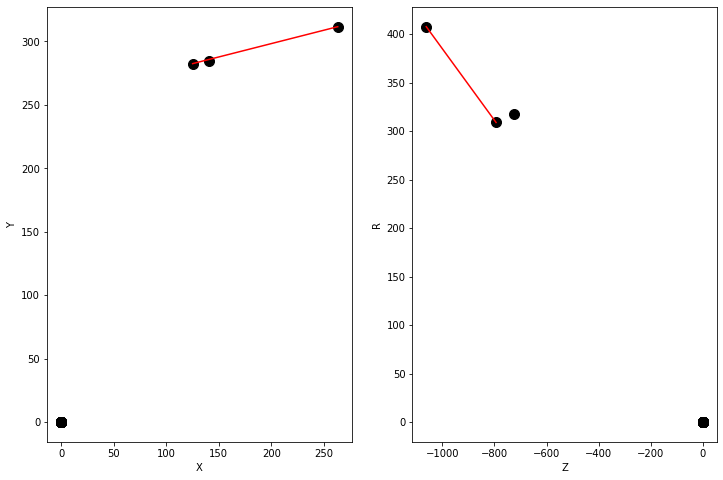

Y = [1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.16941795 0.1607141  0.14105824 0.1983338  0.16406485 0.1425941
 0.582679   0.5834274  0.5130217  0.43679193 0.3786481  0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.951, precision 1.000, recall 0.571


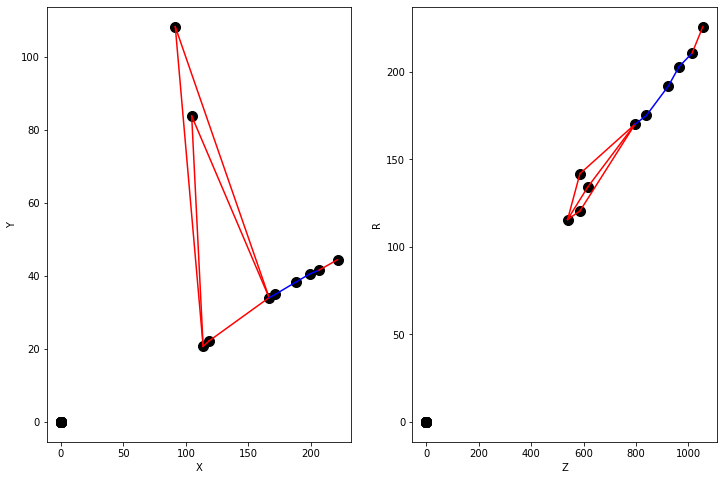

Y = [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.1148925  0.11578066 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.984, precision 0.000, recall 0.000


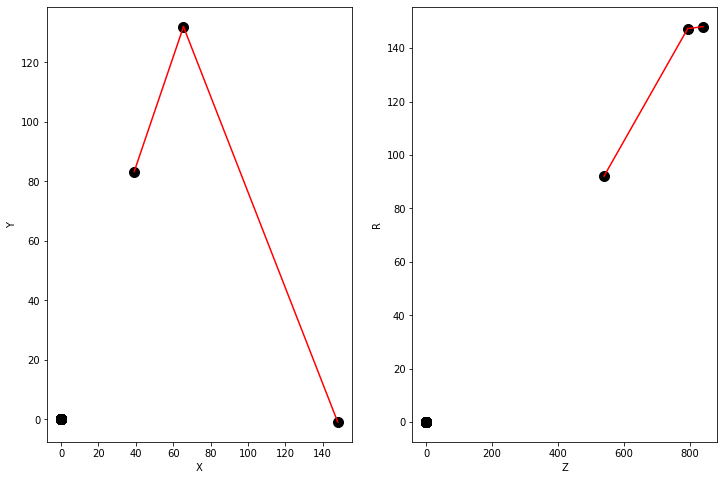

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.0002633  0.00025656 0.00027432 0.00026728 0.00028488 0.00027749
 0.0002853  0.00027789 0.00027067 0.00026377 0.00027046 0.00026356
 0.00028096 0.00027364 0.00028117 0.00027385 0.00022395 0.00022272
 0.00020116 0.00022309 0.00020336 0.00017756 0.00020764 0.00018441
 0.0001802  0.00021047 0.00018341 0.00021466 0.00019029 0.00018593
 0.00019951 0.00017503 0.0002481  0.0001938  0.00017039 0.00024011
 0.00019729 0.00017331 0.00024625 0.00019408 0.00017078 0.00024206
 0.00019149 0.00016858 0.00023806 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


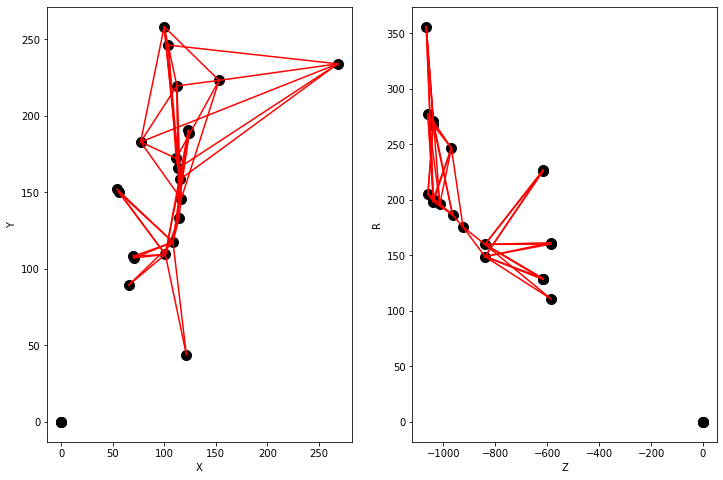

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.29753405 0.19763425 0.391526   0.2881383  0.60620797 0.5165848
 0.44345826 0.31824315 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.951, precision 0.000, recall 0.000


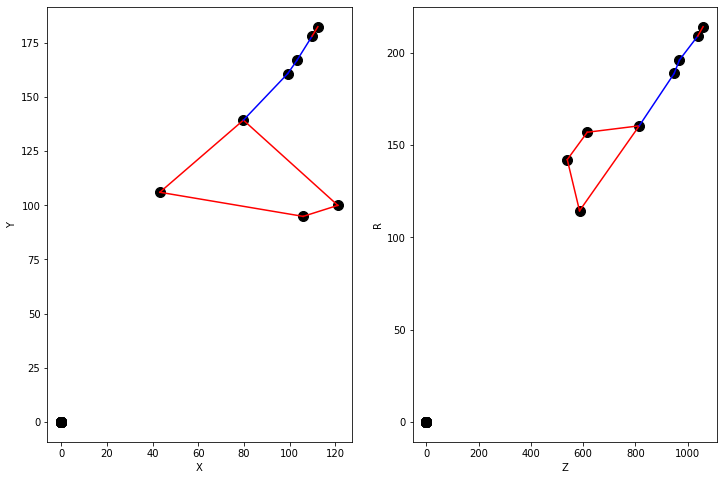

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.2736269  0.30911475 0.3267875  0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


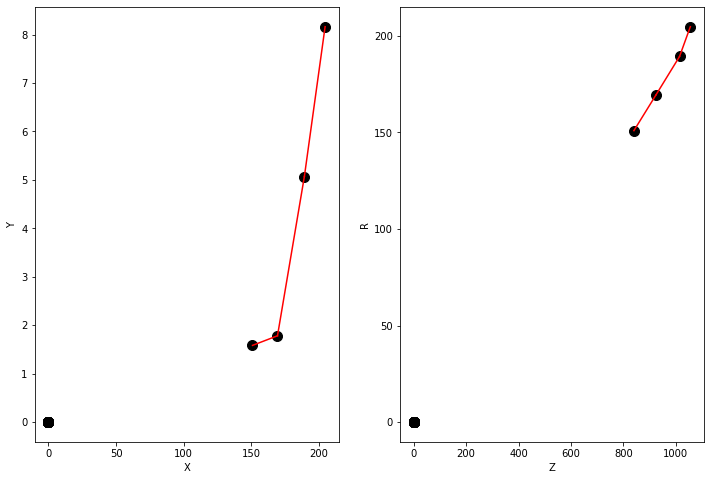

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00049026 0.00054088 0.00037782 0.00025351 0.00025529 0.0002645
 0.00025661 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


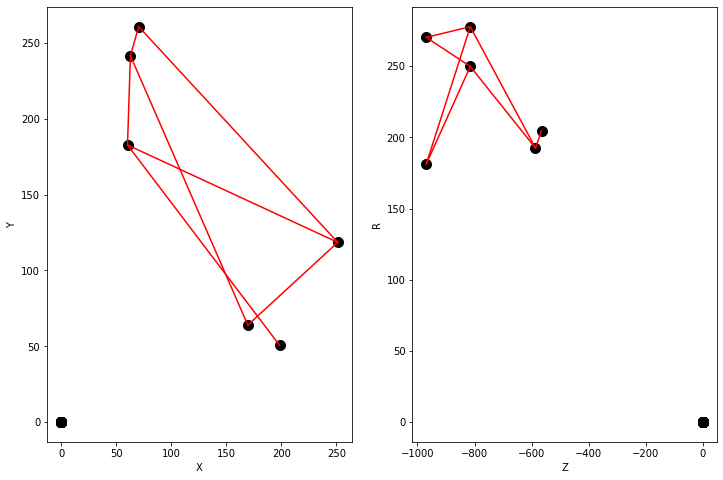

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.04416293 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


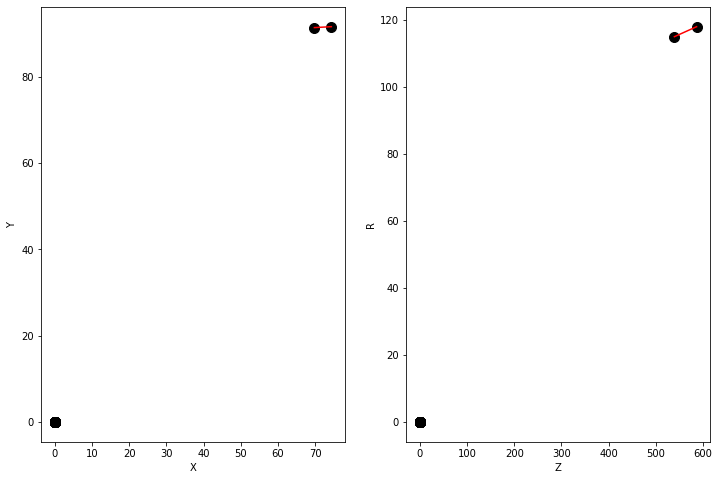

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.15174462 0.1415268  0.24429712 0.24397835 0.33382225 0.29230884
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


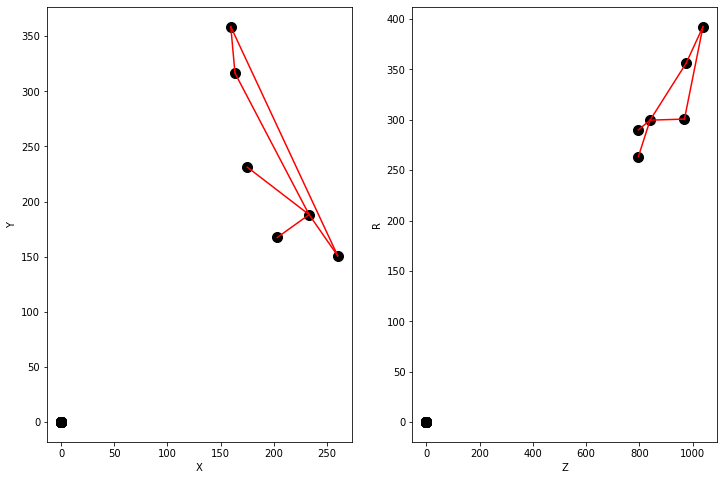

Y = [0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.17095636 0.18878768 0.16601004 0.15472277 0.532883   0.6019959
 0.51721215 0.4242147  0.2840142  0.26476696 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.951, precision 0.500, recall 0.667


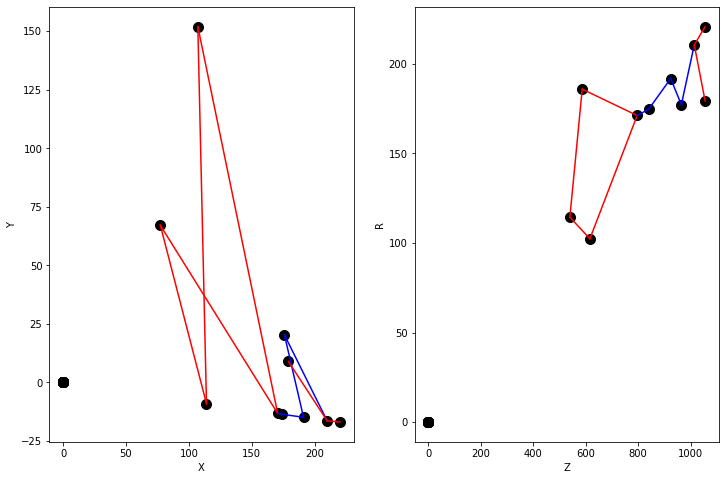

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00059741 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


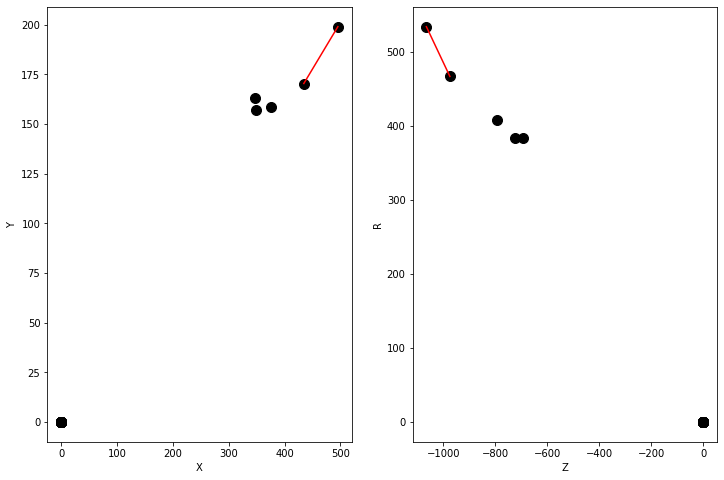

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00026165 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


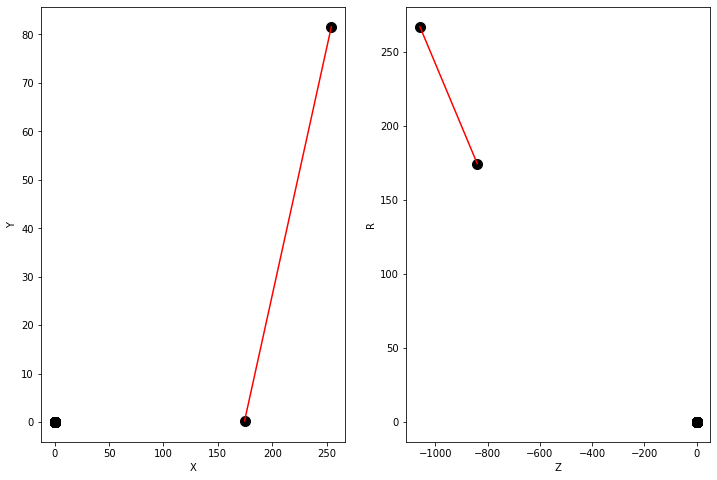

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.2183012  0.12665819 0.21239467 0.35522762 0.21492274 0.30610976
 0.6369051  0.5342402  0.45252094 0.31301904 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.951, precision 0.000, recall 0.000


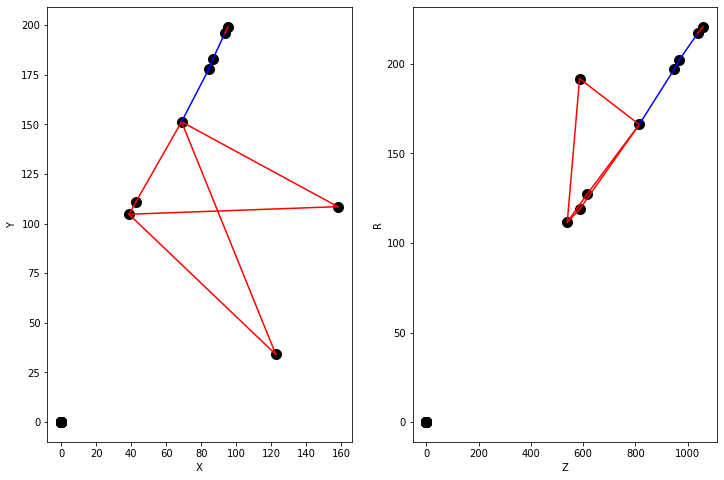

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00073041 0.0005505  0.0004394  0.00045131 0.00046292 0.00038845
 0.00031303 0.00033861 0.00031935 0.00029064 0.00028942 0.00029497
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


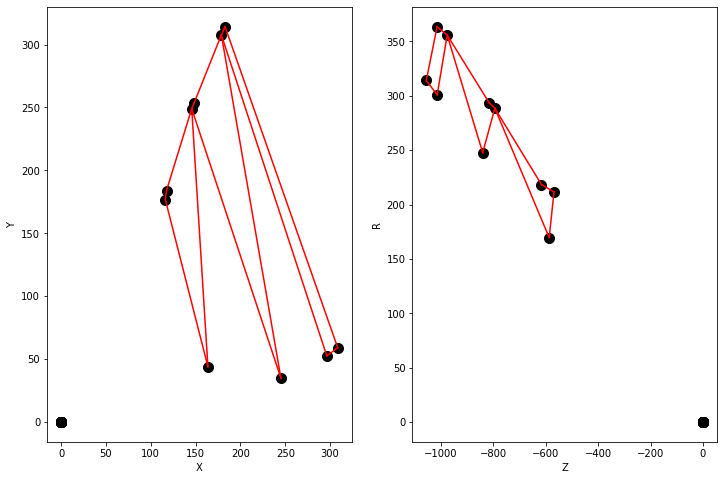

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.16899188 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


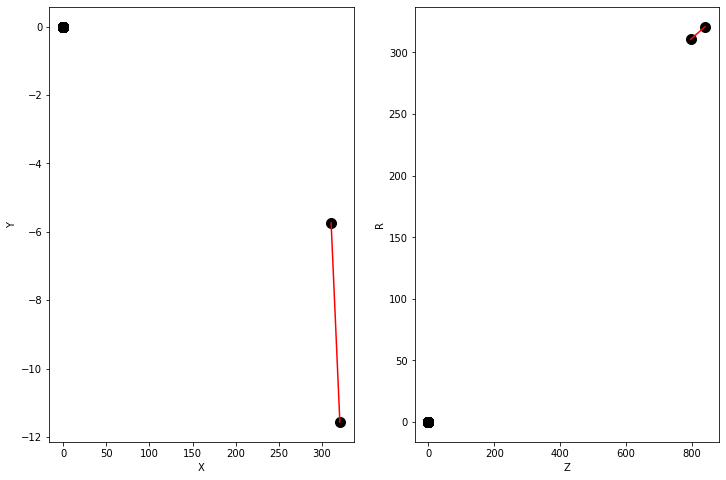

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00025041 0.00025055 0.00024507 0.0002452  0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


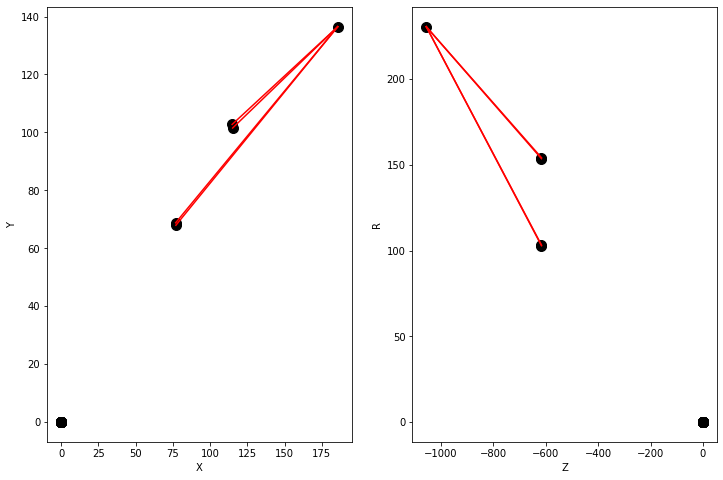

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00041221 0.00024085 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


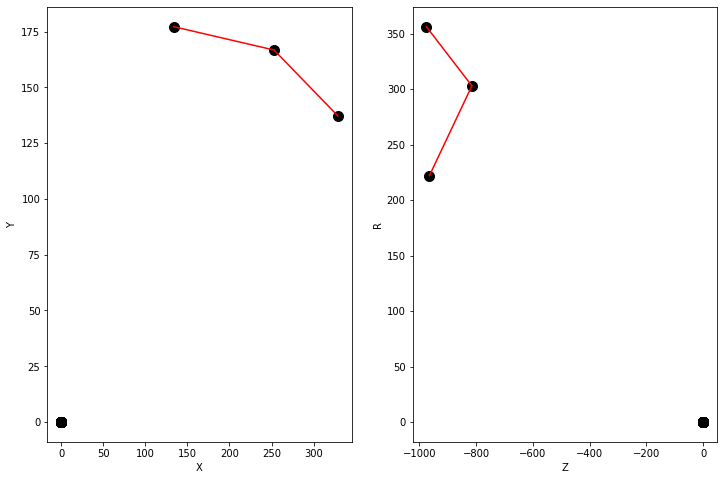

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00052429 0.00042347 0.00035552 0.00031781 0.00029829 0.00029435
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


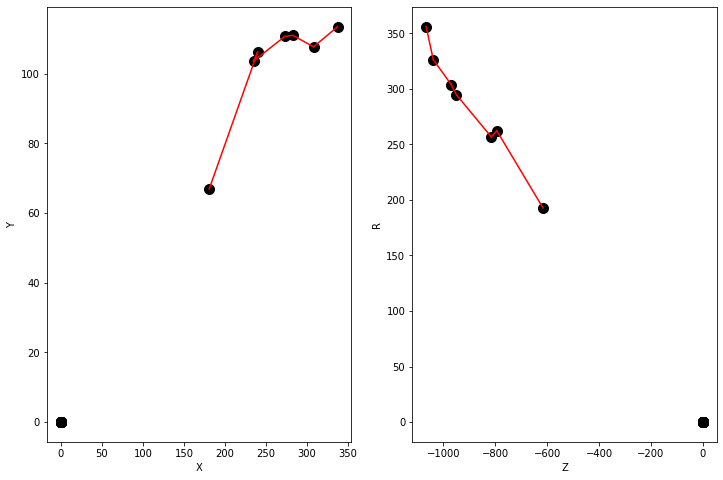

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00057394 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


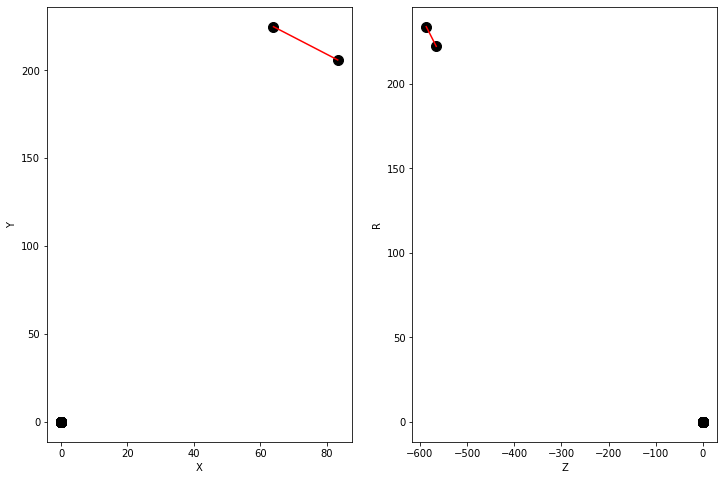

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00062243 0.00060966 0.00052505 0.00045817 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


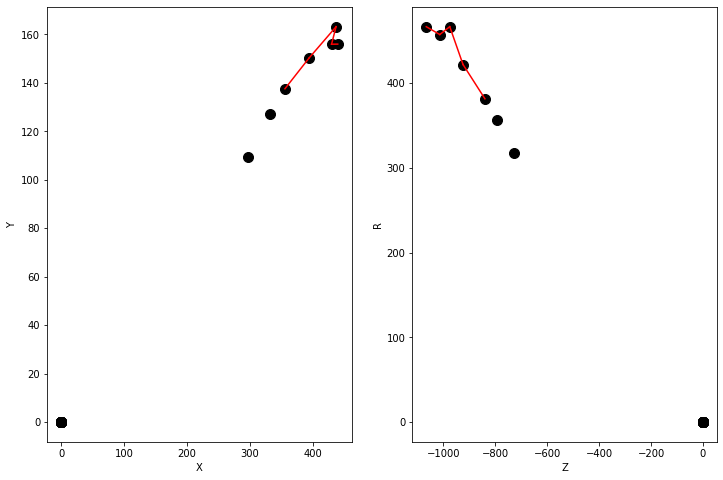

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.39715725 0.41004652 0.2120963  0.22543147 0.21001622 0.21715282
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.984, precision 0.000, recall 0.000


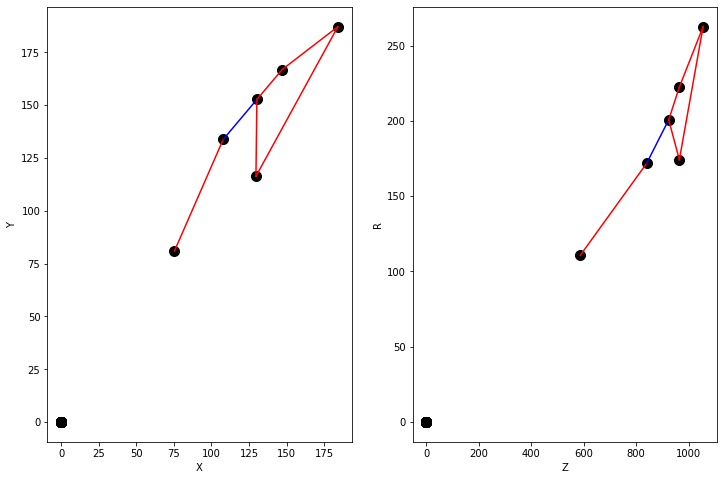

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.22747663 0.17303035 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


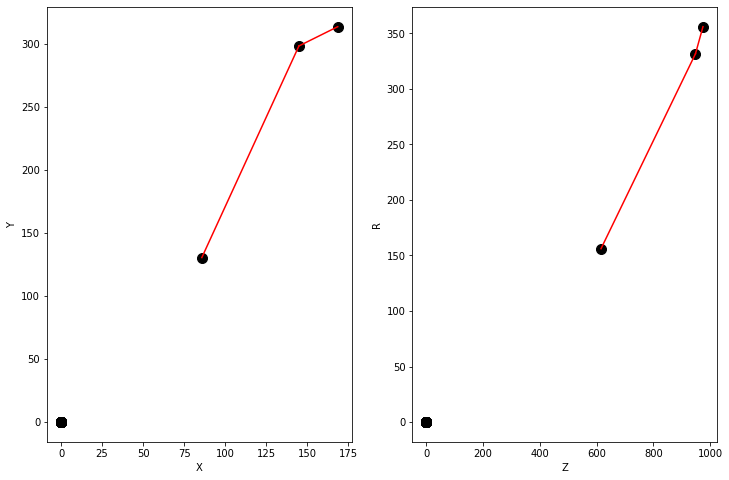

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.38496736 0.4346409  0.19023696 0.1995764  0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.984, precision 0.000, recall 0.000


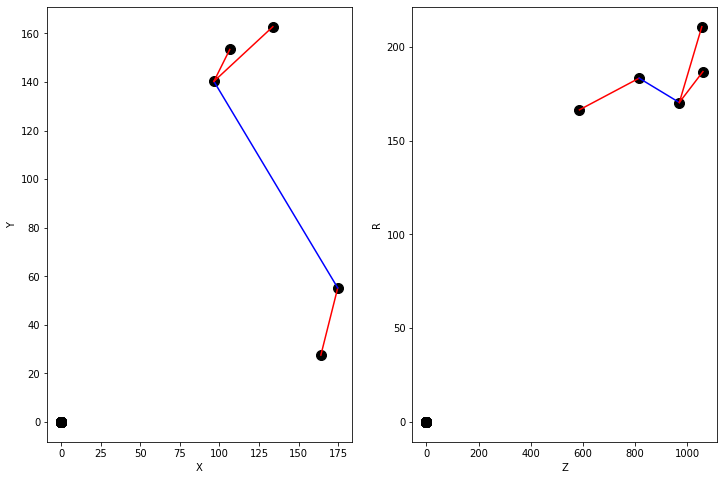

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.02945297 0.02664633 0.02571412 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


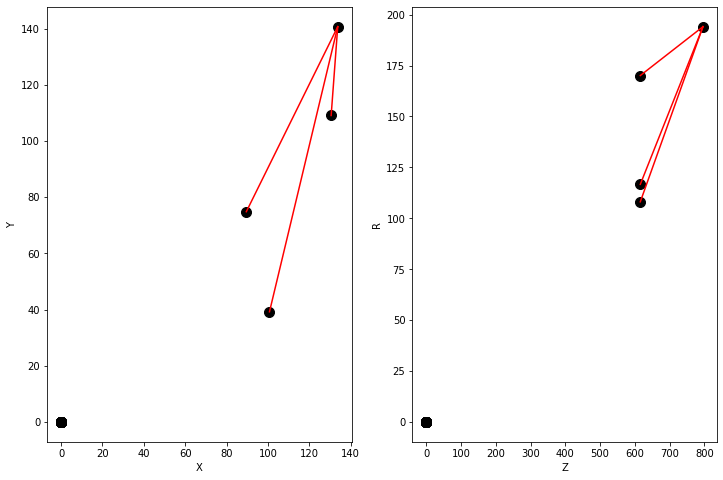

Y = [0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.39925623 0.309956   0.5798485  0.53378767 0.47594053 0.36057392
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.967, precision 1.000, recall 0.600


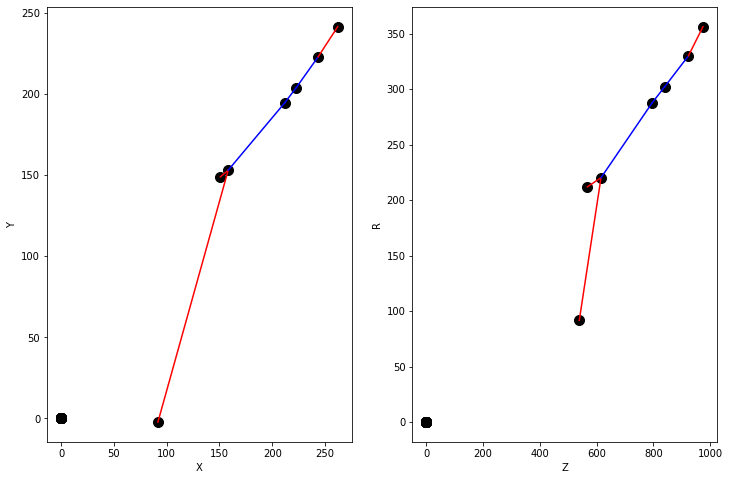

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.3650613  0.2783553  0.62984836 0.5537945  0.51536036 0.37899306
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.951, precision 0.000, recall 0.000


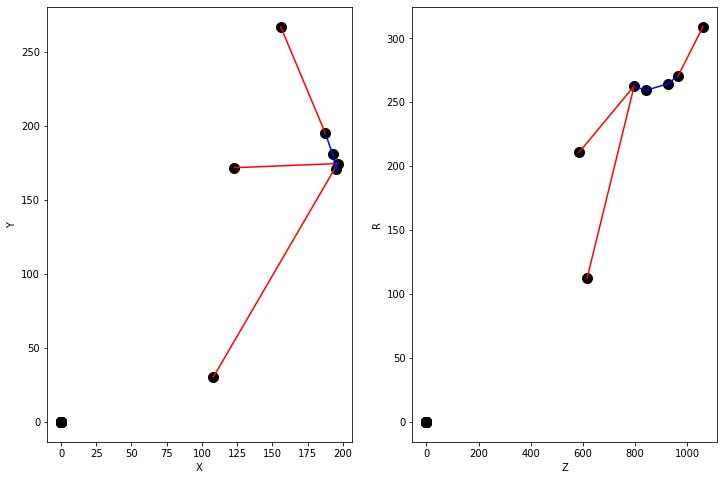

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00032907 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


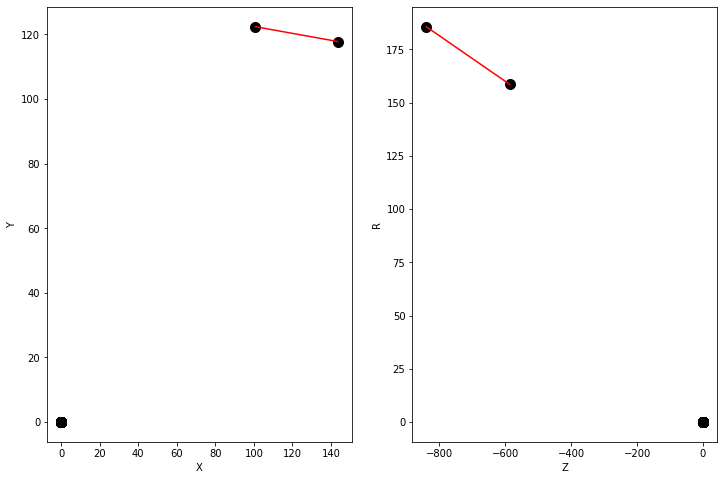

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.08902135 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


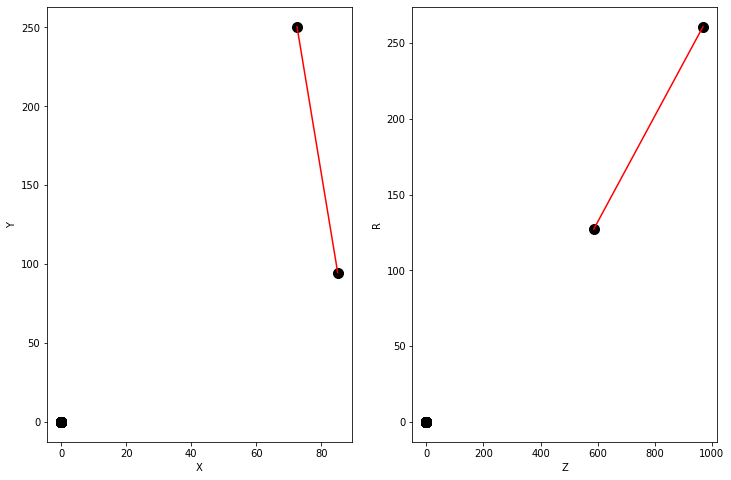

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.0002807  0.00071826 0.00027681 0.00070374 0.0002705  0.00070342
 0.00022887 0.00024576 0.00021482 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


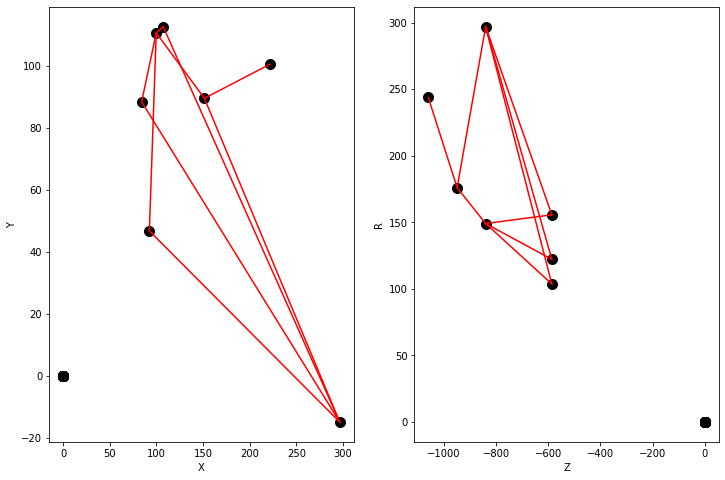

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00035337 0.00033807 0.00035475 0.00033946 0.00034986 0.00033477
 0.00035116 0.00033608 0.00035286 0.00033617 0.00035156 0.00033473
 0.00026444 0.00026467 0.00024719 0.0002373  0.00022112 0.00022163
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


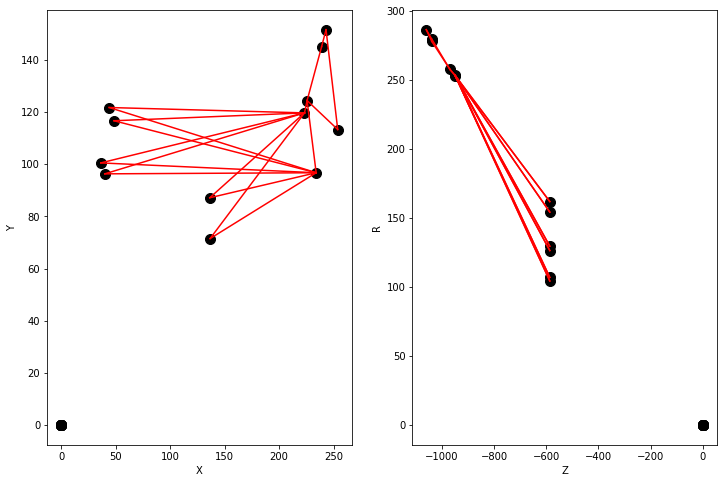

Y = [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.39950317 0.26202586 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.967, precision 0.000, recall 0.000


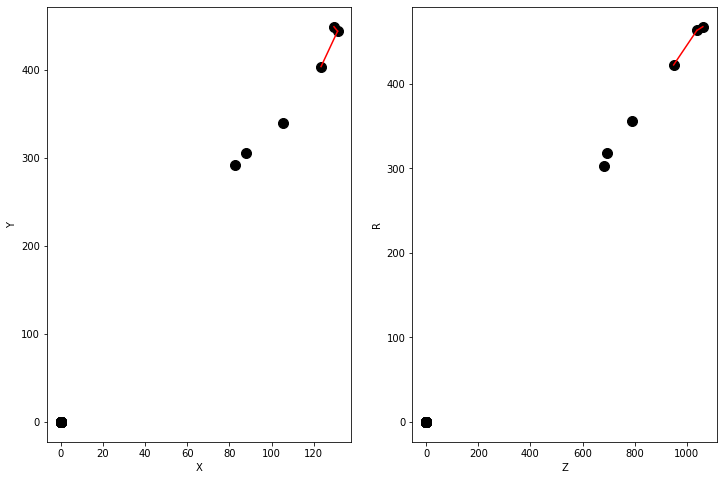

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.23366265 0.24968684 0.2219266  0.22267714 0.4655621  0.43394065
 0.38351107 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.967, precision 0.000, recall 0.000


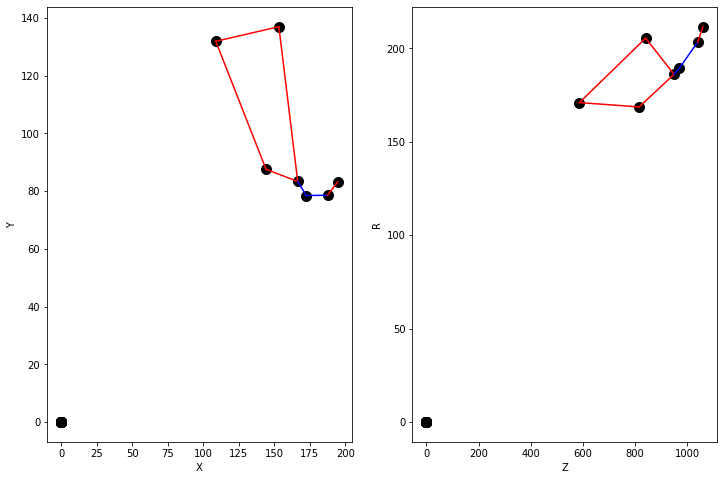

Y = [0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.4578939  0.5560612  0.5574951  0.24394384 0.24769261 0.24711458
 0.2453363  0.24909516 0.24851541 0.22117433 0.23473993 0.23306386
 0.5519233  0.48327443 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 0.803, precision 0.400, recall 0.182


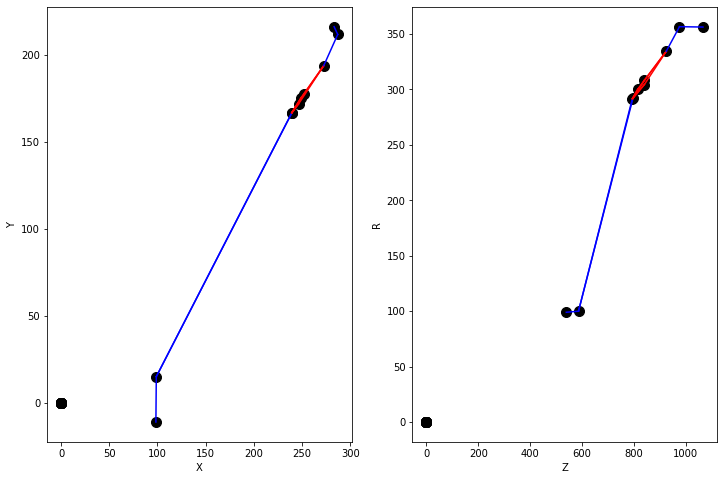

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00105044 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


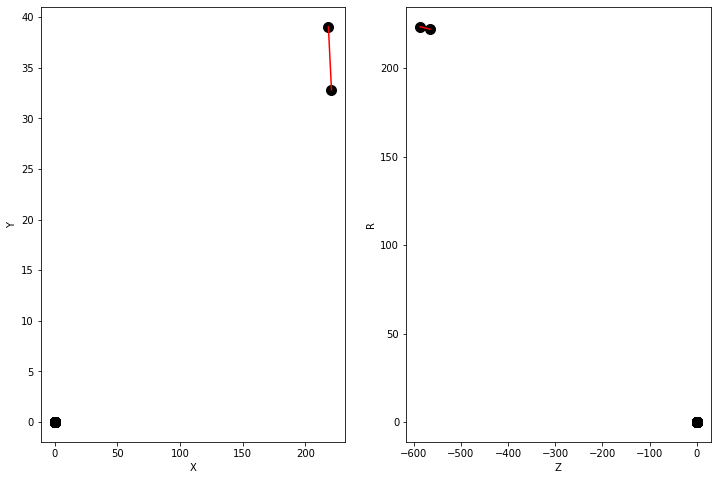

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00024734 0.00024587 0.00035596 0.00017639 0.00017675 0.00017295
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


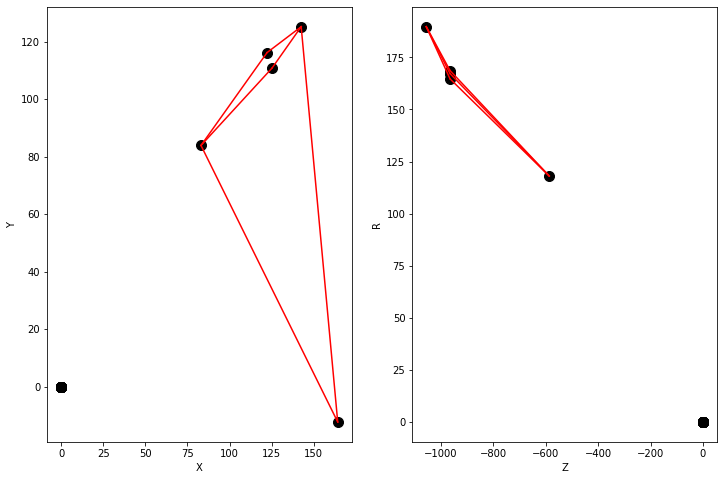

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.31619993 0.373417   0.38578933 0.31995907 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


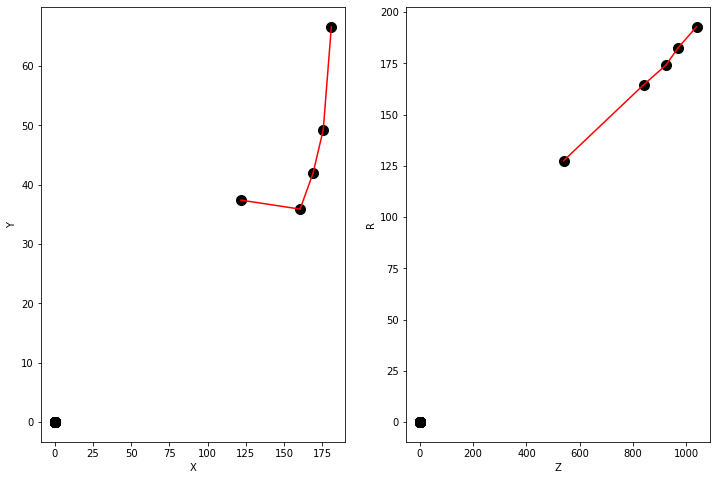

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.3042491  0.25918245 0.391241   0.3905231  0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


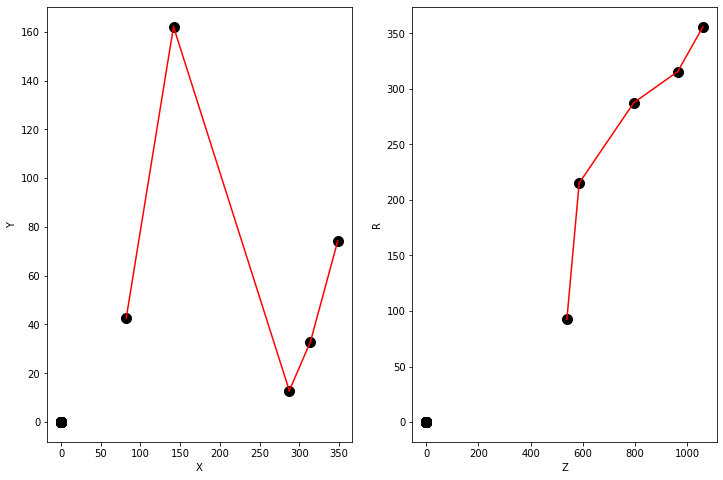

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.10332695 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


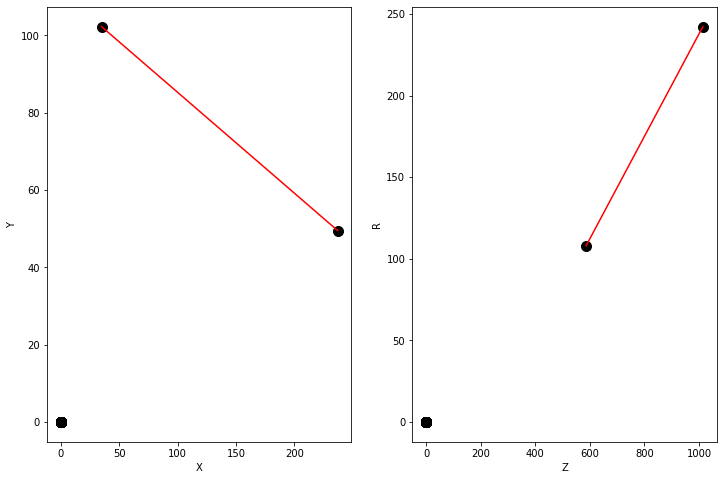

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.35961416 0.24359812 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


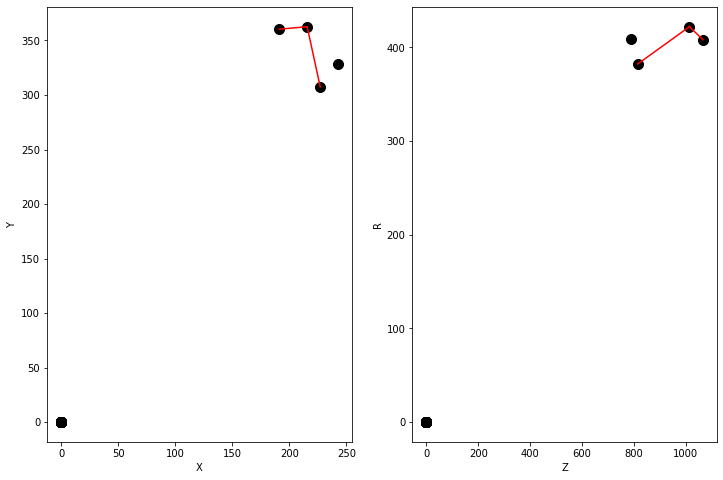

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.00050369 0.00047085 0.00042003 0.00056306 0.00039967 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


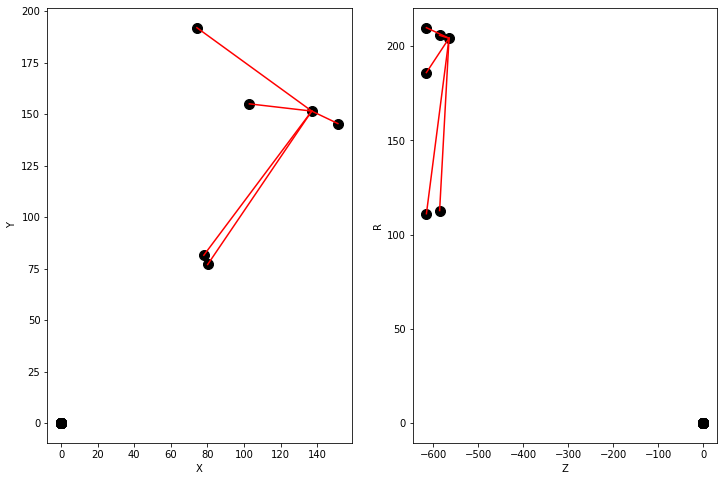

Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PRED = [0.17257139 0.16899686 0.15150486 0.1451898  0.18548086 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797 0.00322797
 0.00322797]
--------------------------------------
accuracy 1.000, precision 0.000, recall 0.000


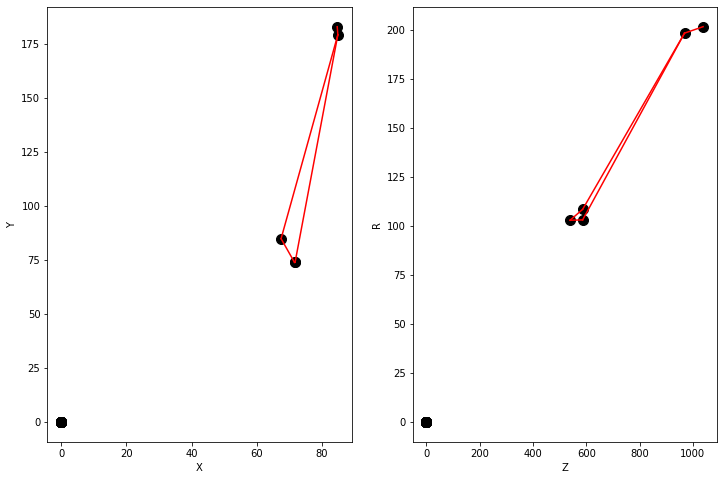

In [12]:
def drawGraph(X, Ri, Ro, y, pred): 
    # Select the i/o node features for each segment    
    # Prepare the figure
 
    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(12,8))
#    cmap = plt.get_cmap('bwr_r')

    # Rescale for plotting purposes
    X=X*feature_scale
    # HITS features 
    R=X[:,0]
    Phi=(np.pi/180.)*X[:,1]
    Z=X[:,2] # Don't save isMuon X[:,3] component in graph feature
    XX=R*np.cos(Phi)
    YY=R*np.sin(Phi)

    # Transform 0 and 1 labels into color list using the dictionary 
    colordic={1:'blue' , 0:'red'}
#    cl=[colordic.get(n) for n in X[:,3]] # use the hit target value for color

    # Plot the hits
    ax0.scatter(XX,YY, s=100., color='black' )
    ax1.scatter(Z,R, s=100., color='black' )
    
    # Get the hits indices from the SGMENTS arrays
    idx_i = find(np.rot90(Ri))[1]
    idx_o = find(np.rot90(Ro))[1]
  
    # Reverse to get correct hits order as in dh_hits 
    idx_i=idx_i[::-1]
    idx_o=idx_o[::-1]

    # Get SEGMENTS begin and end hits coordinates
    R_i=X[idx_i,0]
    Phi_i=(np.pi/180.)*X[idx_i,1]
    Z_i=X[idx_i,2]
    X_i=R_i*np.cos(Phi_i)
    Y_i=R_i*np.sin(Phi_i)
  
    R_o=X[idx_o,0]
    Phi_o=(np.pi/180.)*X[idx_o,1]
    Z_o=X[idx_o,2]
    X_o=R_o*np.cos(Phi_o)
    Y_o=R_o*np.sin(Phi_o)
  
    # Create a list of SEGMENTS colors 
#    cl=[colordic.get(n) for n in y]
    cl=[colordic.get(np.round((n-thresh+0.5),0)) for n in pred]

    # Plot segments

    for j in range(len(X_i)):
      ax0.plot([X_i[j], X_o[j]], [Y_i[j], Y_o[j]], '-', color=cl[j])
      ax1.plot([Z_i[j], Z_o[j]], [R_i[j], R_o[j]], '-', color=cl[j])


    # Show plots
    ax0.set_xlabel('X')
    ax0.set_ylabel('Y')
    ax1.set_xlabel('Z')
    ax1.set_ylabel('R')
    plt.show()


# Loop to draw one graph per event

for i in range(n_test):
    X = test_X[i,:,:] 
    Ri = test_Ri[i,:]
    Ro = test_Ro[i,:]
#    pred = test_pred[i].squeeze(0)
    pred = test_pred[i,:]
    y = test_y[i,:]

    print('Y =',y)
    print('PRED =',pred)
    print('--------------------------------------')

    print('accuracy %.3f, precision %.3f, recall %.3f' % (
        sklearn.metrics.accuracy_score(y, pred>thresh),
        sklearn.metrics.precision_score(y, pred>thresh),
        sklearn.metrics.recall_score(y, pred>thresh)))
    drawGraph(X, Ri, Ro, y , pred);